# FLoC Cohorts from sessions data for panels stratified on income x race 

What are the right cohort sizes to use?

Precompute simhash and cohorts for panel samples.

The cohort assignments are saved to an output file.

We also generate a comparison cohort assignment file.
- this is used to represent expected results if domains visited / cohorts assigned did not correlate with demographics.
- weekly domains visited are randomly assigned to samples (based on real distribution)
- cohorts are assigned using the same algorithm and parameters as for the real data

In [3]:
from datetime import datetime
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import floc

from utils.data import read_weeks_machines_domains
import prefixLSH

## Precompute panel samples simhash

read in pre-processed sessions data

In [3]:
# read in preprocessed weeks-machines data with precomputed simhash values
wmd_simhash_fpath = '../output/wmd_simhash.csv'

weeks_machines_domains_df = pd.read_csv(wmd_simhash_fpath)
print('read in %s total rows' % len(weeks_machines_domains_df))
weeks_machines_domains_df.drop(['domains'], axis=1).head()

read in 4877236 total rows


machine_id  week  n_domains       simhash
0   169007206     1        104  1.585204e+14
1   170331223     1          0           NaN
2   170422065     1         20  5.322881e+14
3   170911221     1         49  7.213568e+14
4   171771316     1         64  6.710488e+14

___

read in panels that were created based on the sessions data and demographic data

attach the simhash computed from the domains

(avoid keeping domains for efficiency gains -- unnessary memory load when we just need simhash values that are computed from them)

precompute cohorts for each panel

In [8]:
panels_fpath = '../output/comscore_cps_income_race_panels.csv'
all_panels_df = pd.read_csv(panels_fpath)
print('read in all panels: %s total rows' % len(all_panels_df))
print('%s panels' % all_panels_df.panel_id.nunique())
all_panels_df.head()

read in all panels: 11375020 total rows
520 panels


machine_id  week  n_domains  household_income  racial_background  \
0   216306561     1         33              11.0                1.0   
1   218977211     1         15              11.0                1.0   
2   227099882     1          7              11.0                1.0   
3   205507144     1          8              11.0                1.0   
4   205274490     1          7              11.0                1.0   

   collapsed_income_code stratify  panel_id  
0                      1  1.0,1.0         1  
1                      1  1.0,1.0         1  
2                      1  1.0,1.0         1  
3                      1  1.0,1.0         1  
4                      1  1.0,1.0         1

In [9]:
all_panels_df['simhash'] = all_panels_df.set_index(
    ['machine_id','week']
).index.map(
    weeks_machines_domains_df.set_index(
        ['machine_id','week']
)['simhash'])
all_panels_df.head()

machine_id  week  n_domains  household_income  racial_background  \
0   216306561     1         33              11.0                1.0   
1   218977211     1         15              11.0                1.0   
2   227099882     1          7              11.0                1.0   
3   205507144     1          8              11.0                1.0   
4   205274490     1          7              11.0                1.0   

   collapsed_income_code stratify  panel_id       simhash  
0                      1  1.0,1.0         1  2.389685e+14  
1                      1  1.0,1.0         1  8.594196e+14  
2                      1  1.0,1.0         1  1.029867e+15  
3                      1  1.0,1.0         1  5.930436e+13  
4                      1  1.0,1.0         1  8.445503e+14

## Pre-compute cohorts for each panel

each sample's cohort is dependent on the rest of the simhashes in the panel

for this reason, cohorts must be computed per panel

In [40]:
# some helper functions for plotting
import math

dpi = 100
t = 0.1

race_values = {1:'white', 2:'black', 3:'asian', 5:'other'}
collapsed_income_code_values = {
    1:'less than $25,000',
    2:'\$25,000 - $75,000',
    3:'\$75,000 - $150,000',
    4:'\$150,000 or more'
}

def get_cohort_demo_portions_df(panel_df, demo_col, cohort_name='cohort'):
    df = panel_df.groupby(
        [cohort_name, demo_col]
    ).count()['panel_id'].rename('count').to_frame().reset_index(demo_col)
    df['total'] = panel_df.groupby(cohort_name).count()['panel_id']
    df['portion'] = df['count']/df['total']
    return df


def plot_cohort_demo_fractions(panel_df, demo_col, demo_value_names_dict, cohort_name='cohort', 
                               ncols=4, print=False):
    
    nrows = math.ceil(len(demo_value_names_dict)/ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), dpi=dpi)
    axes = axes.flatten()
    axes[0].set_ylabel('fraction')
    fig.tight_layout()

    cohort_demo_portions_df = get_cohort_demo_portions_df(
        panel_df, demo_col, cohort_name=cohort_name)
    demo_fractions = panel_df.groupby(demo_col)['panel_id'].count() / len(panel_df)
    
    for i, (val,name) in enumerate(demo_value_names_dict.items()):
        ax = axes[i]
        cohort_demo_mean = cohort_demo_portions_df[cohort_demo_portions_df[demo_col]==val].portion.mean()
        # Google's sensitivity analysis actually looked at avg for sensitive categories
        # across all users rather than across cohorts
        demo_fraction = demo_fractions[val]
        if print:
            print('mean fraction %s across cohorts = %0.2f' % (name, cohort_demo_mean))
            print('fraction %s across all users in cohorts = %0.2f' % (name, demo_fraction))
        cohort_demo_portions_df[cohort_demo_portions_df[demo_col]==val].portion.sort_values(ascending=False).plot.bar(ax=ax, label="")
        ax.hlines(y=demo_fraction, xmin=0, xmax=len(ax.get_xticks()), 
                  linestyles='-', color='black', label='mean')
        ax.hlines(y=demo_fraction+t, xmin=0, xmax=len(ax.get_xticks()), 
                  linestyles='--', color='black', label='mean + t=0.1')
        ax.set_xticks([])
        ax.set_xlabel('cohorts')
        #ax.set_ylabel('fraction "%s"' % name)
        ax.set_title(name)
    plt.show()
    return cohort_demo_portions_df

### Comparing values of k for cohort creation

What is a good size of k to use? The Google Chrome origin trial (OT) used k=2000 but with much larger samples than our panel.

It is important for there to be enough cohorts in order to separate the browsing histories.

e.g. for the extreme example, if we were to use k=2000 but only have 8 cohorts, then users that exhibit what would be considered very different browsing behaviors if there were more cohorts, such as in the OT trial, may instead be grouped into the same cohort. 

Here we compare various values of k before choosing values to precompute cohorts for.

In [11]:
33872 / 2000

16.936


For the OT, the number of cohorts was 33,872. i.e. More than 16.5x the minimum k.

We try to use a similar ratio of `k : |C| = 2 : 33.9`

We check what value of min k would achieve this ratio by checking panels from weeks distributed across the year.

In [36]:
# panel ids correspond to week in year
panel_ids = [2,22,32,42,52] 
panels = [(p_id, all_panels_df[all_panels_df.panel_id==p_id].copy()) for p_id in panel_ids] 
print('using panel ids %s' % panel_ids)

using panel ids [2, 22, 32, 42, 52]


In [37]:
def show_panel_info(panel_df, k, cohort_name='cohort'):
    print('|C| = %s total cohorts' % panel_df[cohort_name].nunique())
    print('k = %s' % k)
    print('|C| / k = %0.3f' % (panel_df[cohort_name].nunique()/k))
    
    print('cohort sizes:')
    cohort_counts = panel_df[cohort_name].value_counts()
    print(cohort_counts.describe())

    fig,ax = plt.subplots(2,1,figsize=(4,3), sharex=True, dpi=100)
    cohort_counts.hist(ax=ax[0])
    ax[0].set_ylabel('cohorts')
    ax[1].set_ylabel('cohorts')
    _ = ax[1].set_xlabel('cohort size')
    _ = cohort_counts.hist(ax=ax[1], bins=50)
    
    _ = plot_cohort_demo_fractions(panel_df, 'racial_background', 
                                   race_values, cohort_name=cohort_name)
    _ = plot_cohort_demo_fractions(panel_df, 'collapsed_income_code', 
                                   collapsed_income_code_values, cohort_name=cohort_name)


k=2000 ---------------------------

checking panel 2 with size 23209
|C| = 8 total cohorts
k = 2000
|C| / k = 0.004
cohort sizes:
count       8.000000
mean     2901.125000
std       535.312042
min      2159.000000
25%      2504.000000
50%      2820.500000
75%      3443.250000
max      3534.000000
Name: cohort, dtype: float64


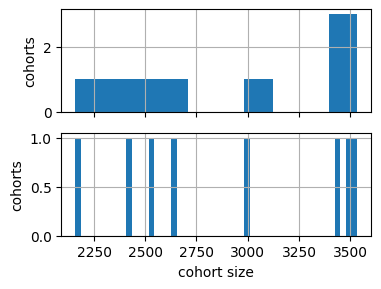

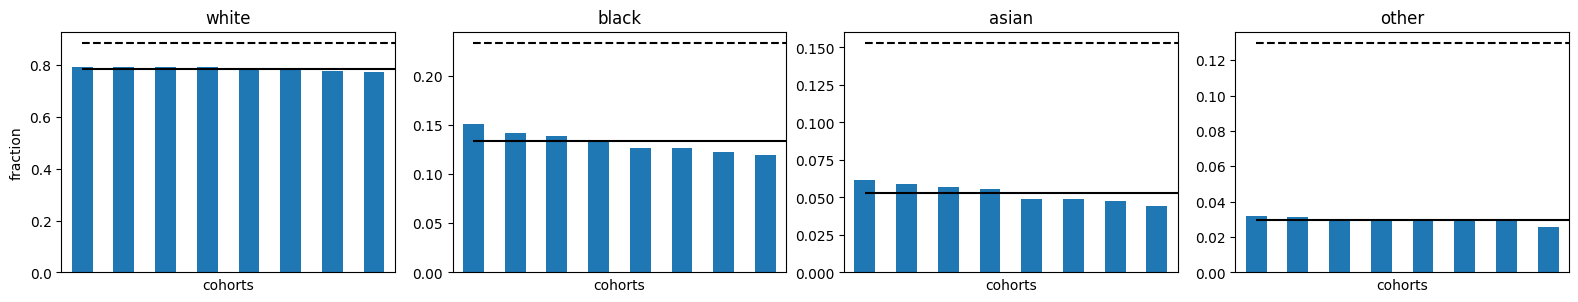

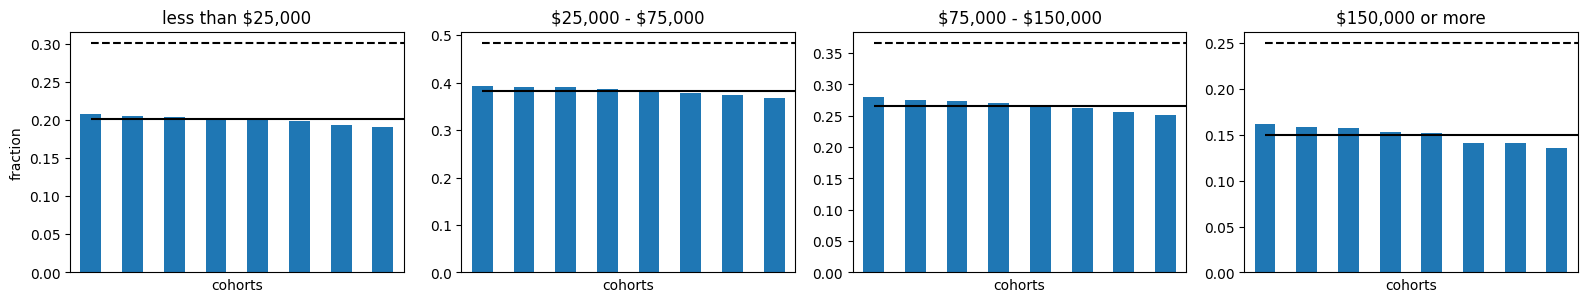

checking panel 22 with size 21768
|C| = 8 total cohorts
k = 2000
|C| / k = 0.004
cohort sizes:
count       8.000000
mean     2721.000000
std       503.391072
min      2158.000000
25%      2319.250000
50%      2589.000000
75%      3093.250000
max      3578.000000
Name: cohort, dtype: float64


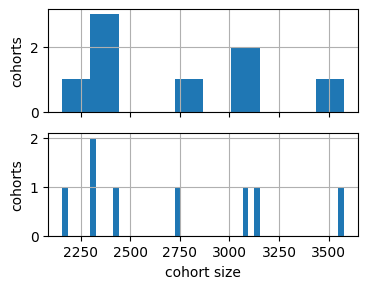

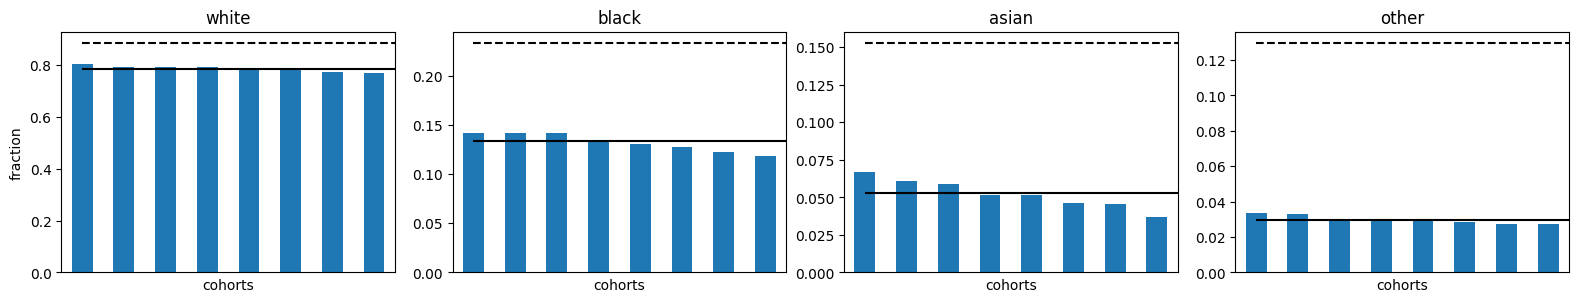

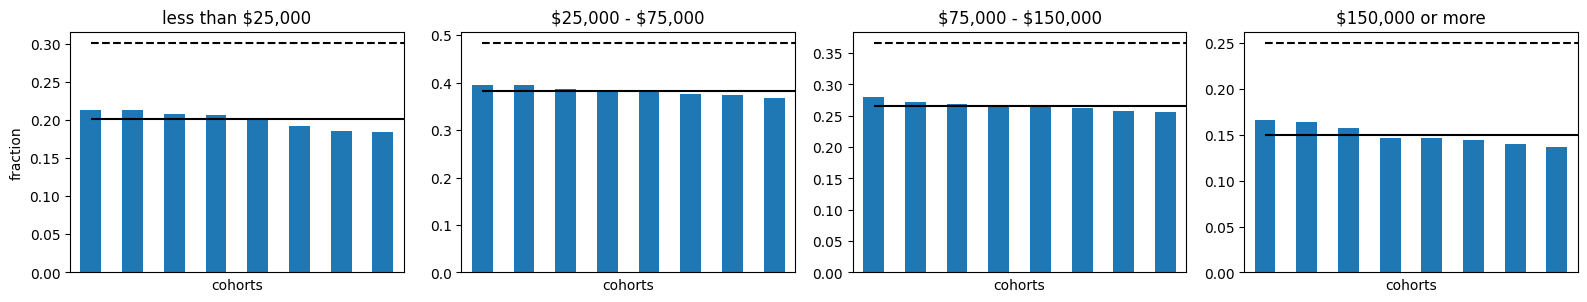

checking panel 32 with size 19579
|C| = 7 total cohorts
k = 2000
|C| / k = 0.004
cohort sizes:
count       7.000000
mean     2797.000000
std       512.578124
min      2189.000000
25%      2502.500000
50%      2799.000000
75%      2896.000000
max      3794.000000
Name: cohort, dtype: float64


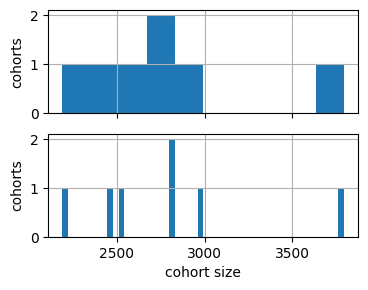

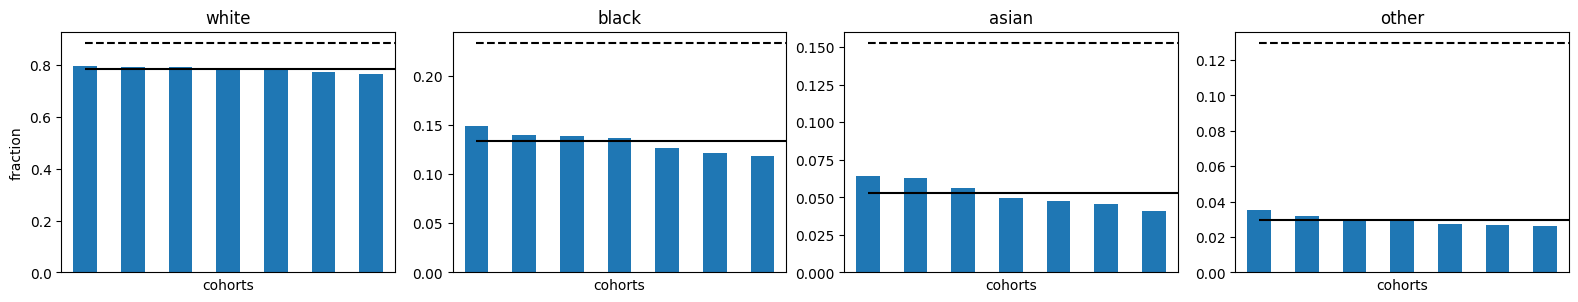

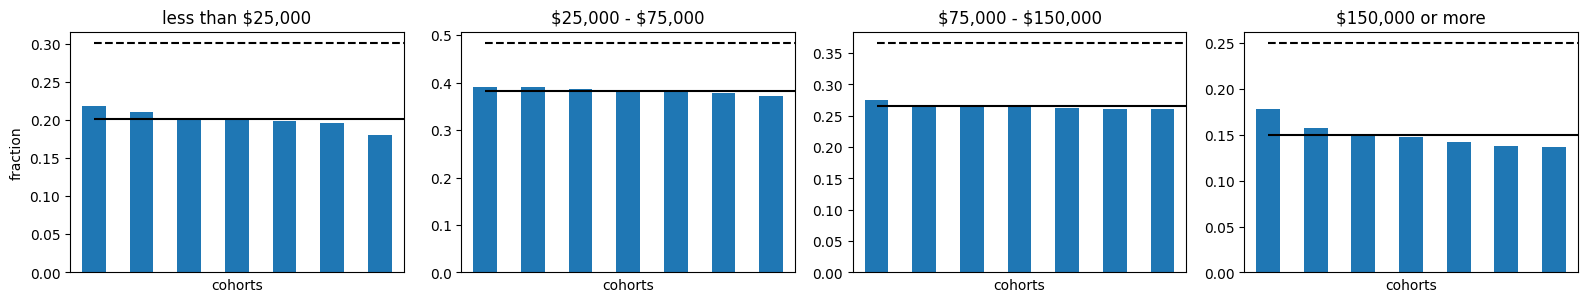

checking panel 42 with size 21745
|C| = 8 total cohorts
k = 2000
|C| / k = 0.004
cohort sizes:
count       8.000000
mean     2718.125000
std       574.892397
min      2018.000000
25%      2172.750000
50%      2770.000000
75%      3142.750000
max      3409.000000
Name: cohort, dtype: float64


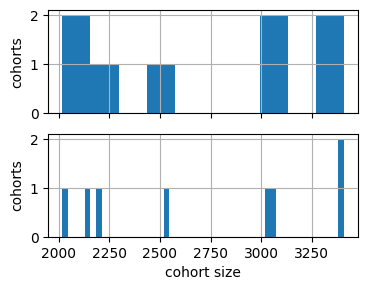

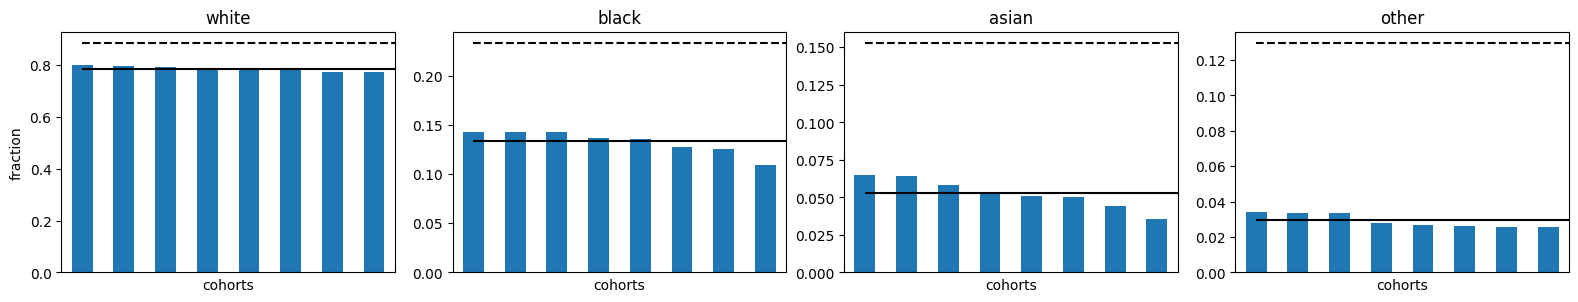

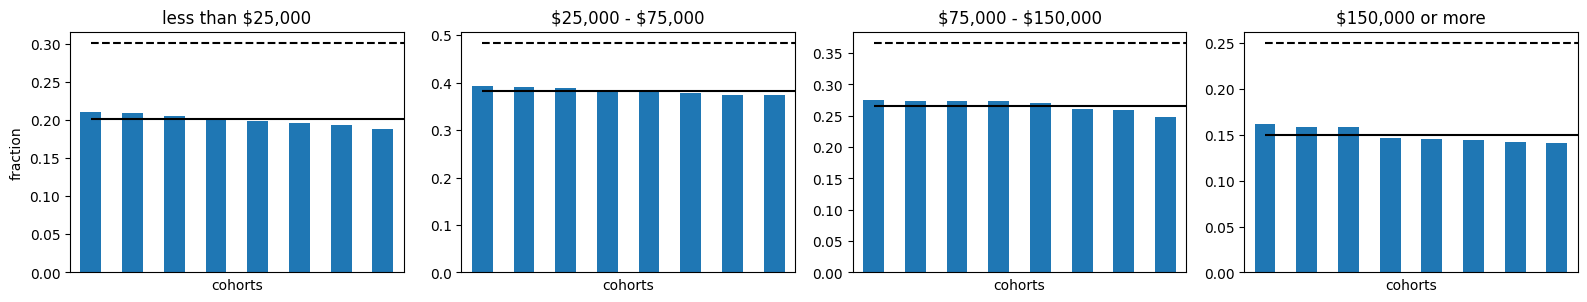

checking panel 52 with size 18286
|C| = 6 total cohorts
k = 2000
|C| / k = 0.003
cohort sizes:
count       6.000000
mean     3047.666667
std       614.417339
min      2373.000000
25%      2714.750000
50%      2823.000000
75%      3385.000000
max      4016.000000
Name: cohort, dtype: float64


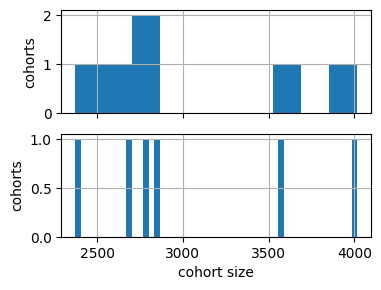

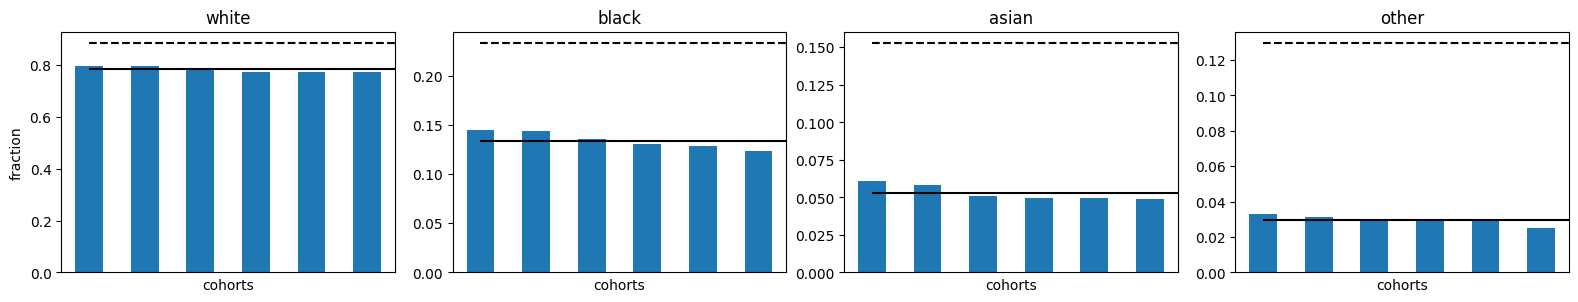

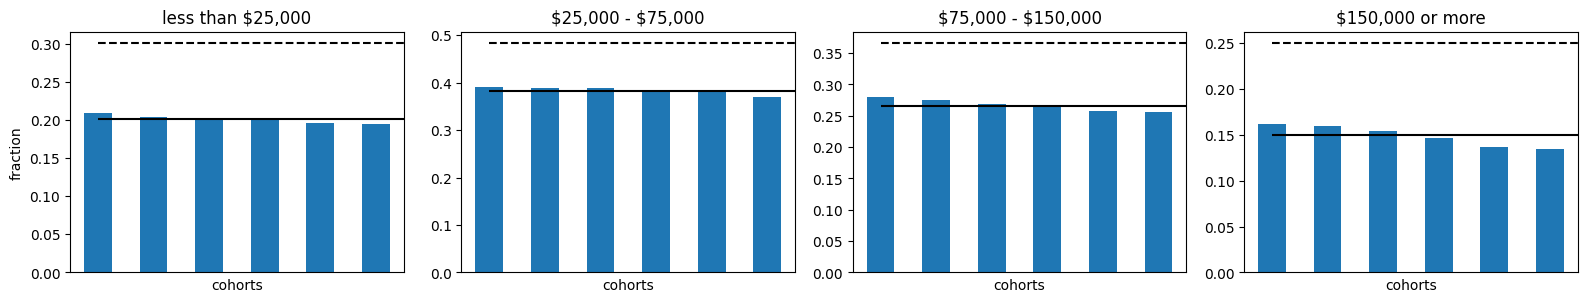


k=1000 ---------------------------

checking panel 2 with size 23209
|C| = 15 total cohorts
k = 1000
|C| / k = 0.015
cohort sizes:
count      15.000000
mean     1547.266667
std       529.071487
min      1009.000000
25%      1176.000000
50%      1279.000000
75%      1938.000000
max      2528.000000
Name: cohort, dtype: float64


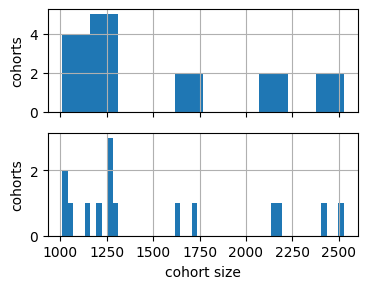

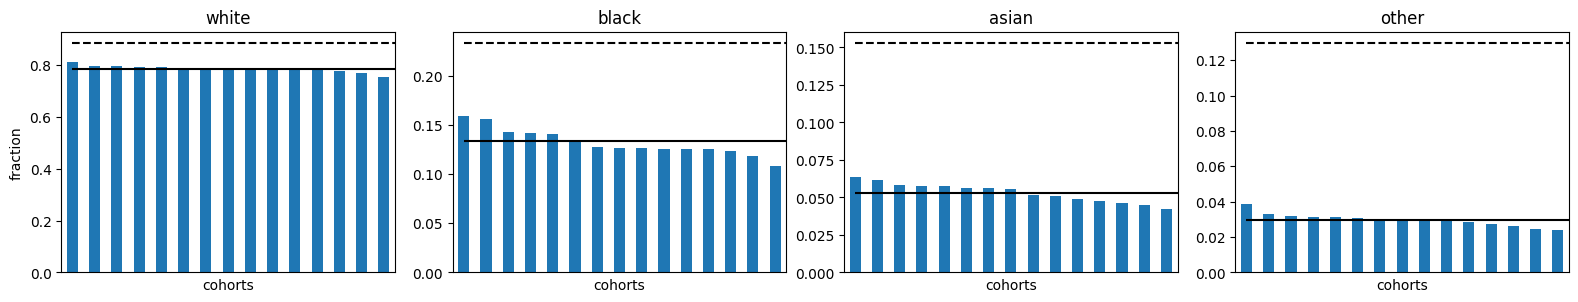

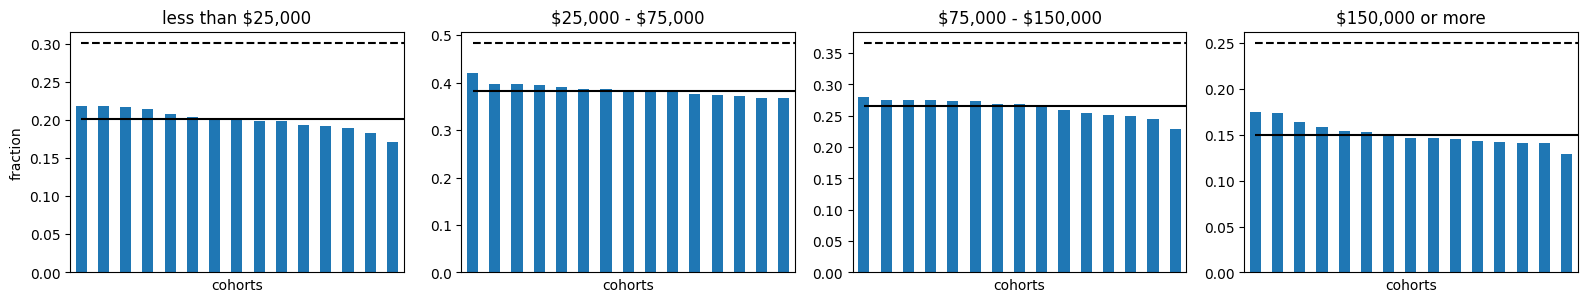

checking panel 22 with size 21768
|C| = 13 total cohorts
k = 1000
|C| / k = 0.013
cohort sizes:
count      13.000000
mean     1674.461538
std       514.127192
min      1075.000000
25%      1228.000000
50%      1629.000000
75%      2158.000000
max      2424.000000
Name: cohort, dtype: float64


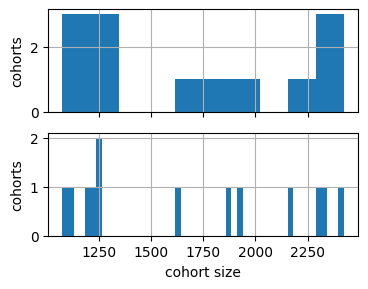

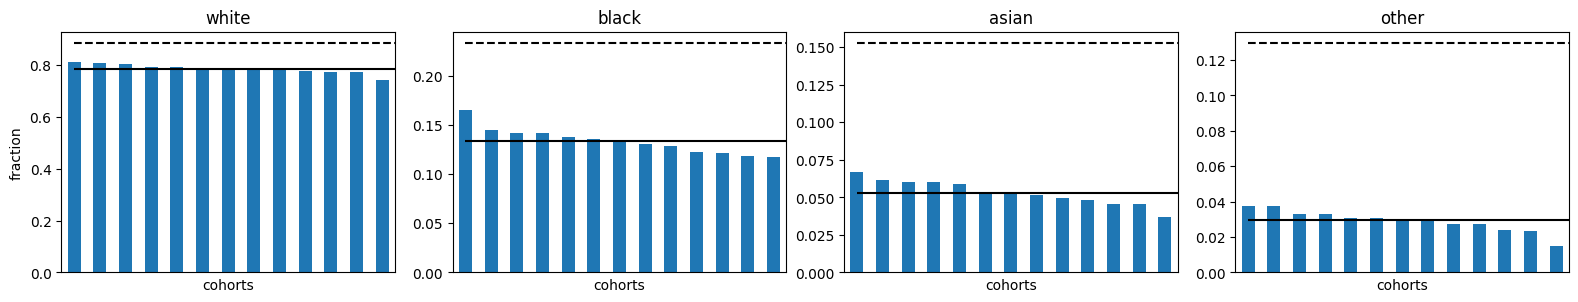

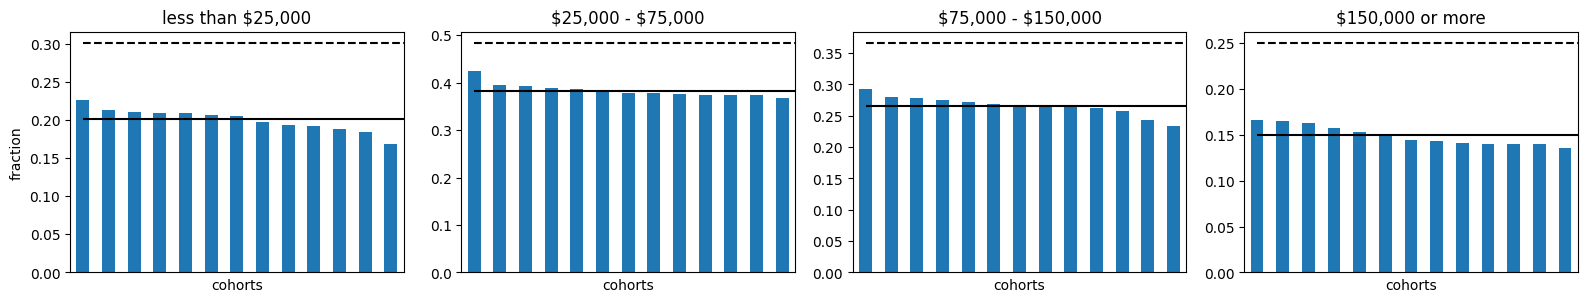

checking panel 32 with size 19579
|C| = 13 total cohorts
k = 1000
|C| / k = 0.013
cohort sizes:
count      13.000000
mean     1506.076923
std       409.947651
min      1006.000000
25%      1078.000000
50%      1531.000000
75%      1877.000000
max      2189.000000
Name: cohort, dtype: float64


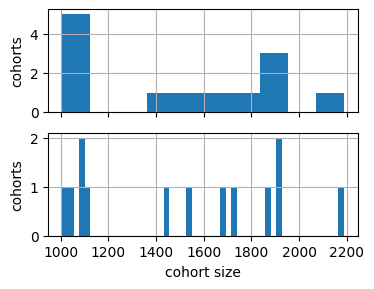

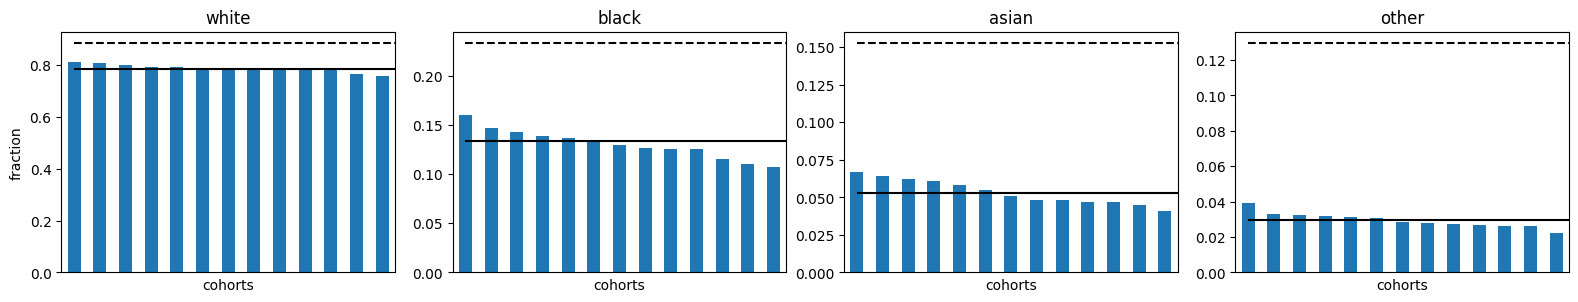

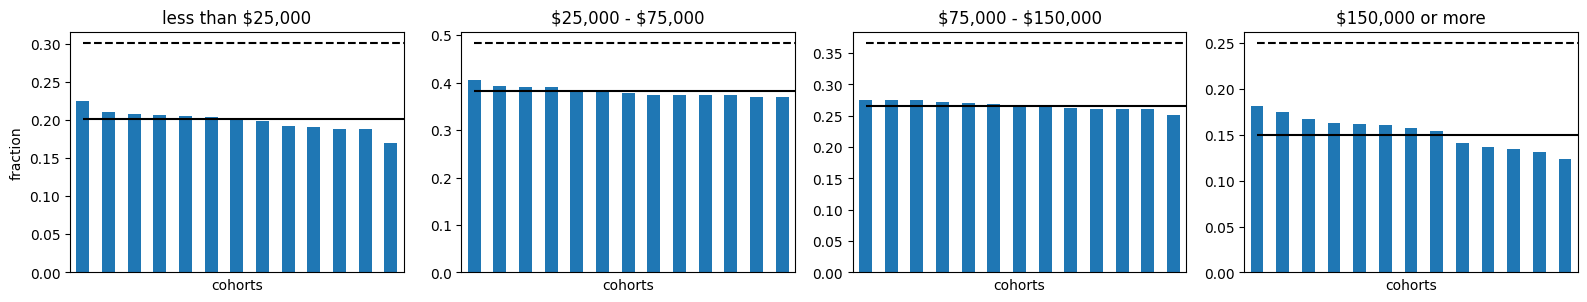

checking panel 42 with size 21745
|C| = 13 total cohorts
k = 1000
|C| / k = 0.013
cohort sizes:
count      13.000000
mean     1672.692308
std       515.465548
min      1048.000000
25%      1193.000000
50%      1828.000000
75%      2130.000000
max      2519.000000
Name: cohort, dtype: float64


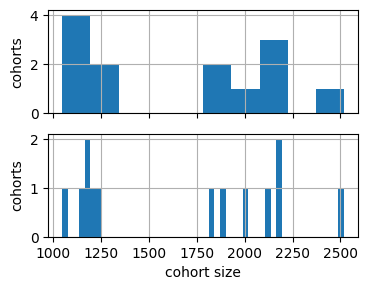

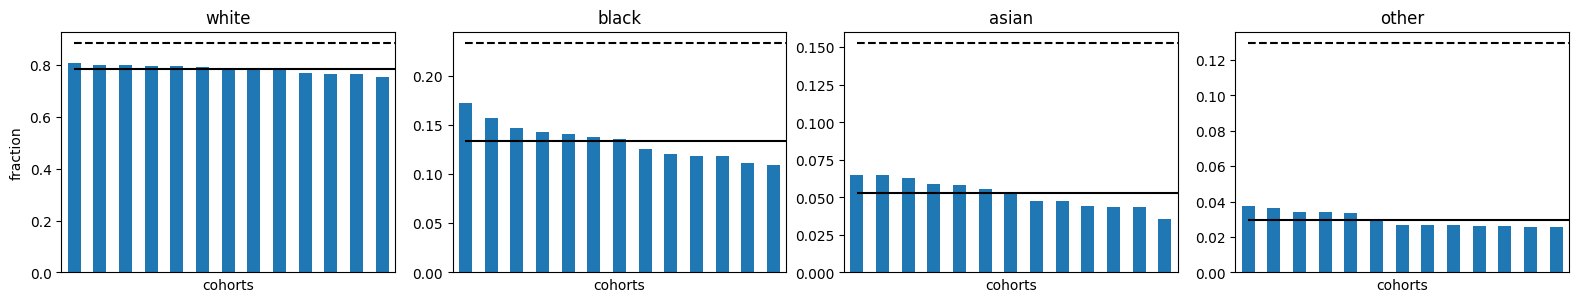

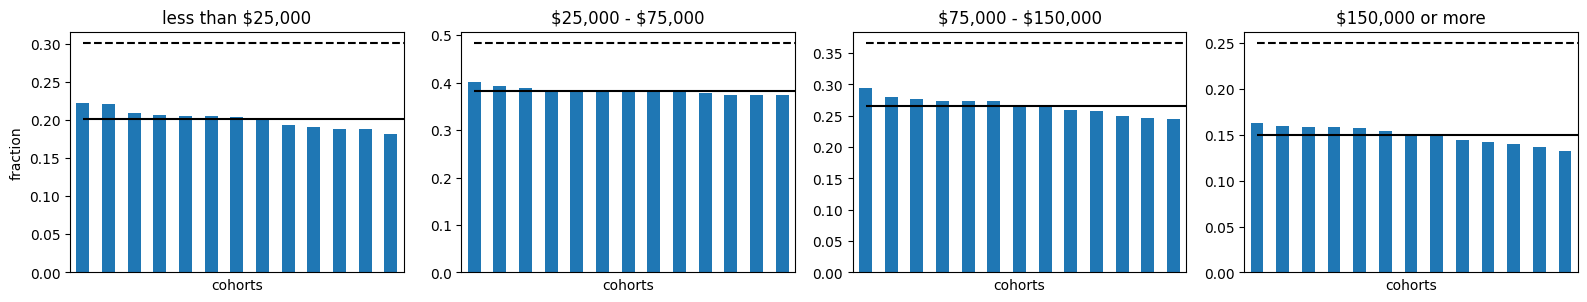

checking panel 52 with size 18286
|C| = 10 total cohorts
k = 1000
|C| / k = 0.010
cohort sizes:
count      10.000000
mean     1828.600000
std       560.967656
min      1013.000000
25%      1688.250000
50%      1786.500000
75%      2102.000000
max      2857.000000
Name: cohort, dtype: float64


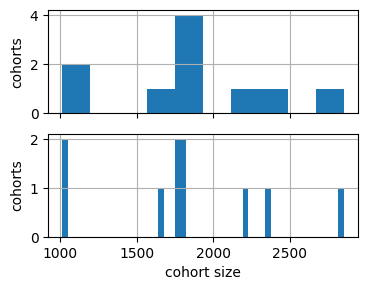

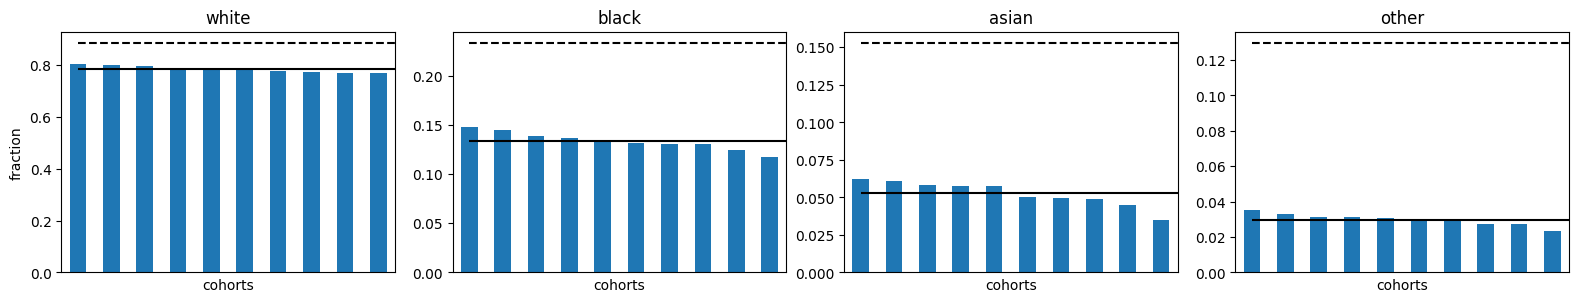

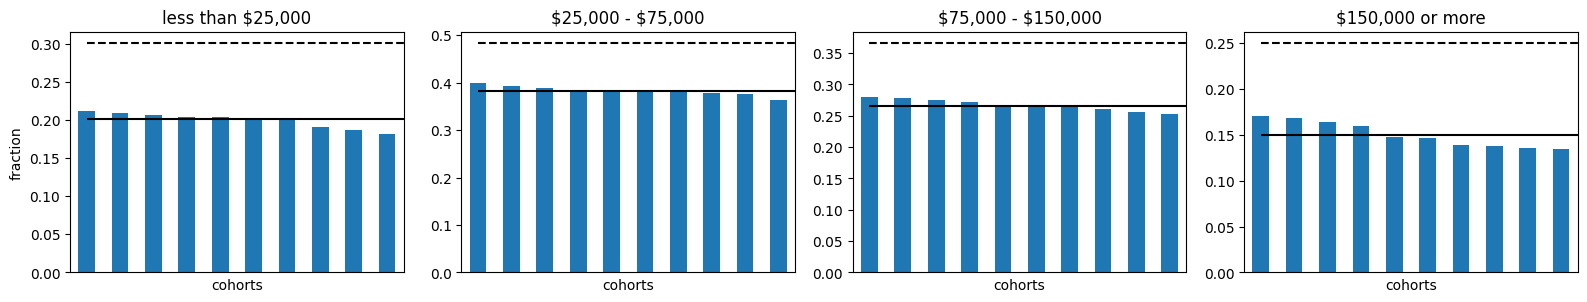


k=500 ---------------------------

checking panel 2 with size 23209
|C| = 29 total cohorts
k = 500
|C| / k = 0.058
cohort sizes:
count      29.000000
mean      800.310345
std       181.749259
min       515.000000
25%       650.000000
50%       775.000000
75%       934.000000
max      1194.000000
Name: cohort, dtype: float64


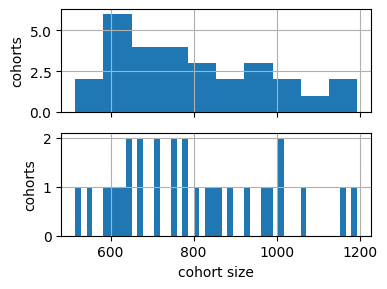

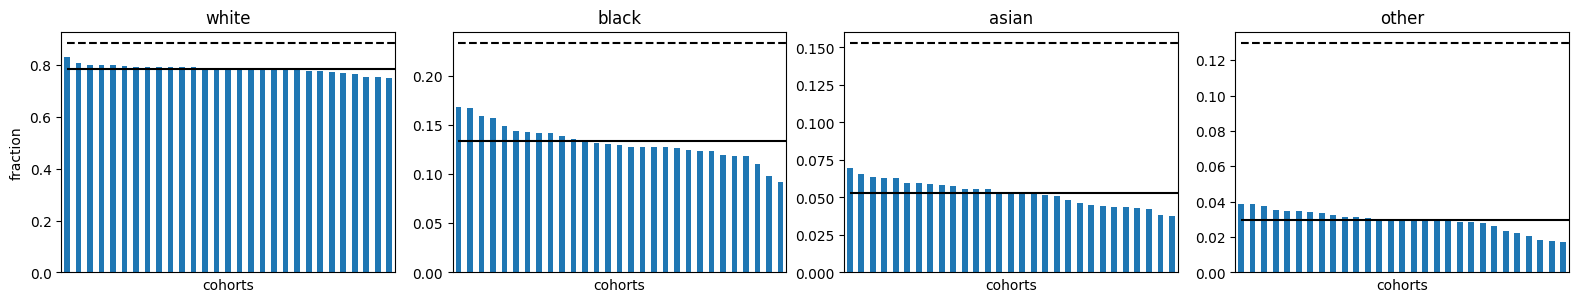

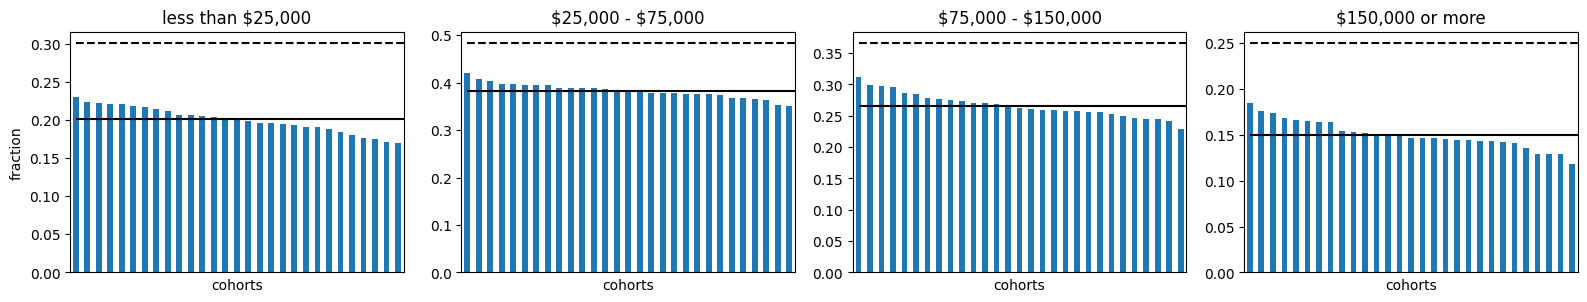

checking panel 22 with size 21768
|C| = 27 total cohorts
k = 500
|C| / k = 0.054
cohort sizes:
count      27.000000
mean      806.222222
std       186.133602
min       538.000000
25%       683.000000
50%       783.000000
75%       909.500000
max      1252.000000
Name: cohort, dtype: float64


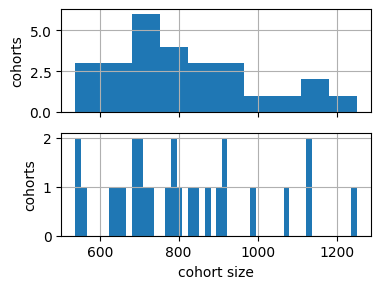

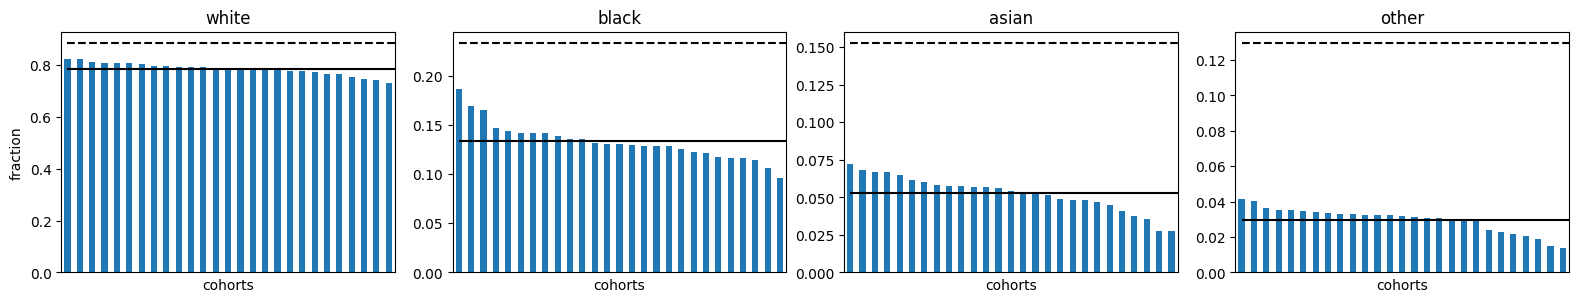

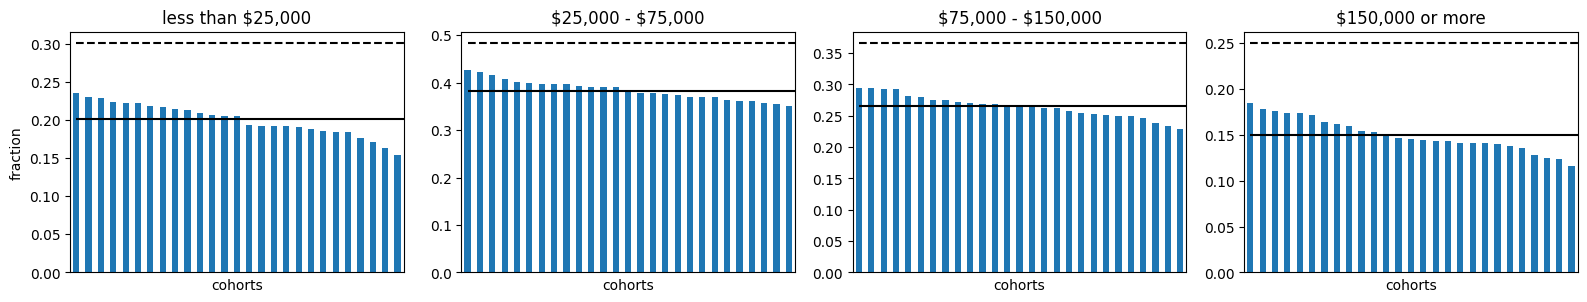

checking panel 32 with size 19579
|C| = 25 total cohorts
k = 500
|C| / k = 0.050
cohort sizes:
count      25.000000
mean      783.160000
std       181.978634
min       509.000000
25%       619.000000
50%       762.000000
75%       922.000000
max      1078.000000
Name: cohort, dtype: float64


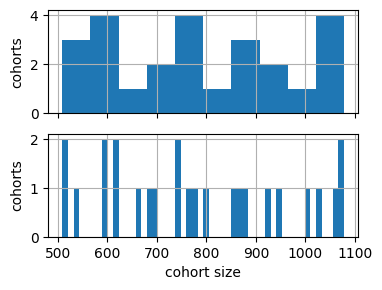

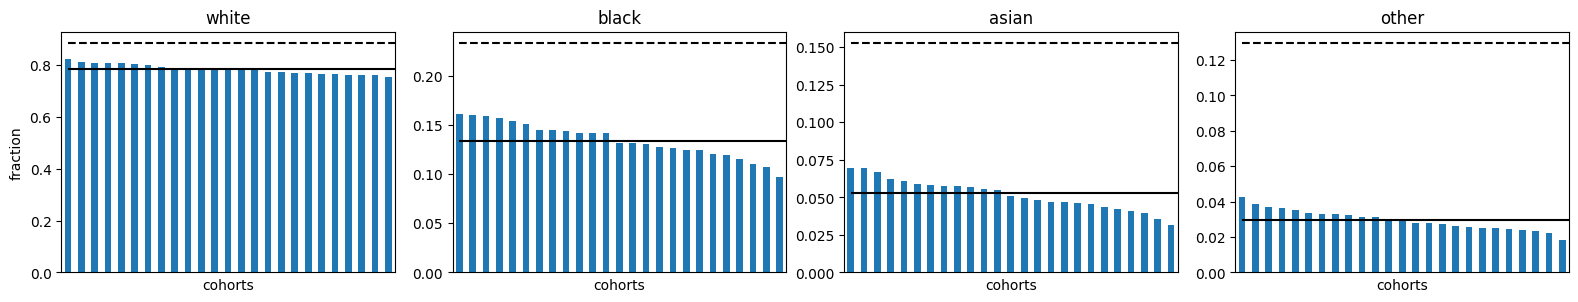

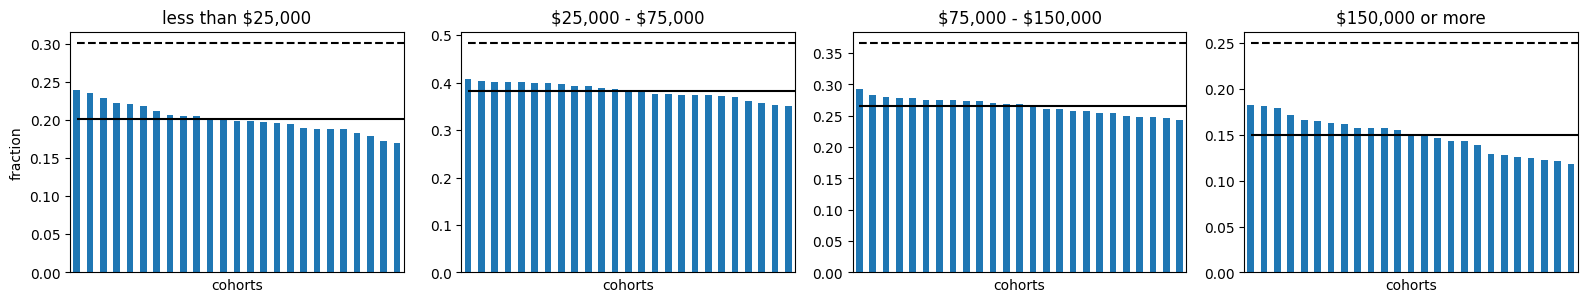

checking panel 42 with size 21745
|C| = 28 total cohorts
k = 500
|C| / k = 0.056
cohort sizes:
count      28.000000
mean      776.607143
std       206.562579
min       522.000000
25%       606.500000
50%       757.000000
75%       857.750000
max      1195.000000
Name: cohort, dtype: float64


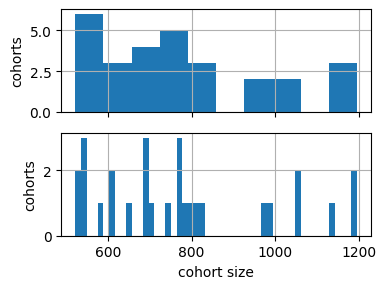

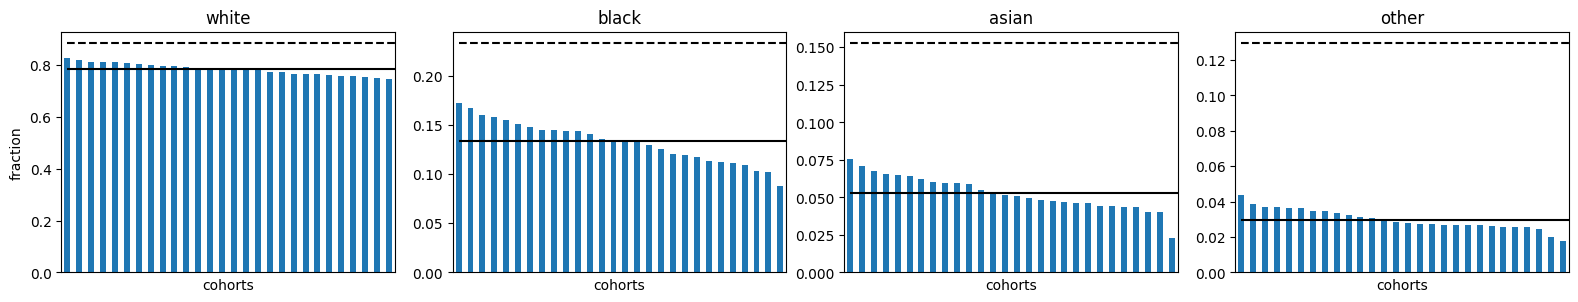

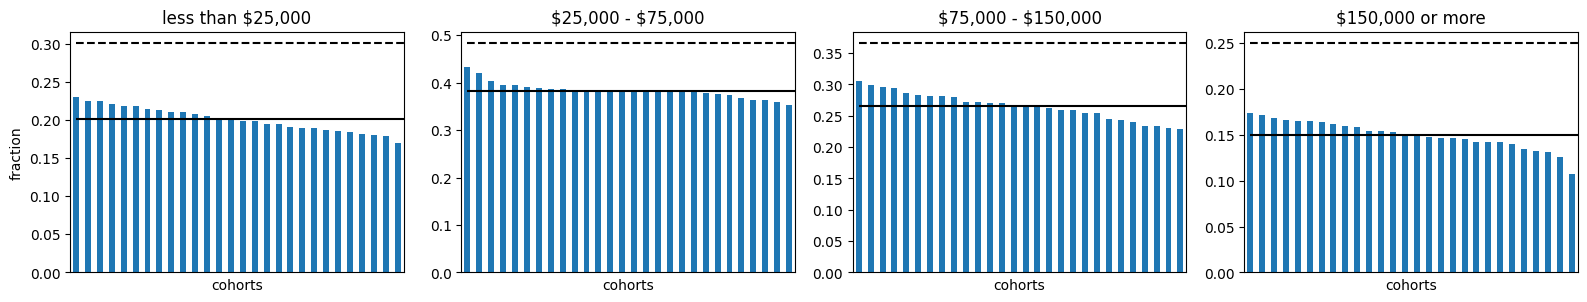

checking panel 52 with size 18286
|C| = 22 total cohorts
k = 500
|C| / k = 0.044
cohort sizes:
count      22.000000
mean      831.181818
std       179.190677
min       547.000000
25%       662.750000
50%       824.500000
75%      1000.250000
max      1127.000000
Name: cohort, dtype: float64


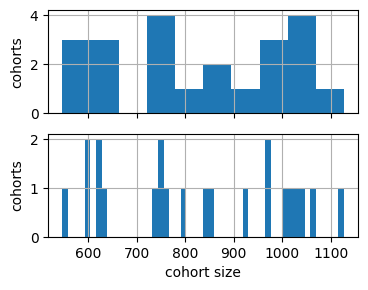

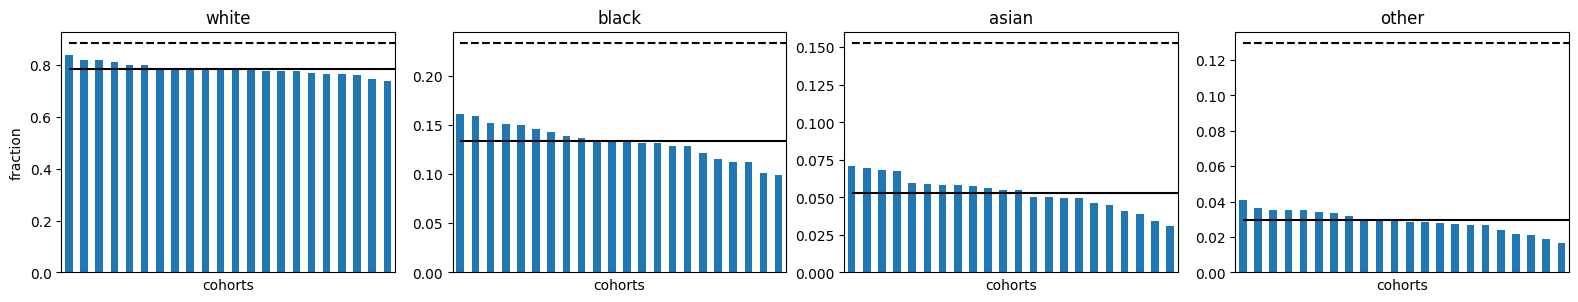

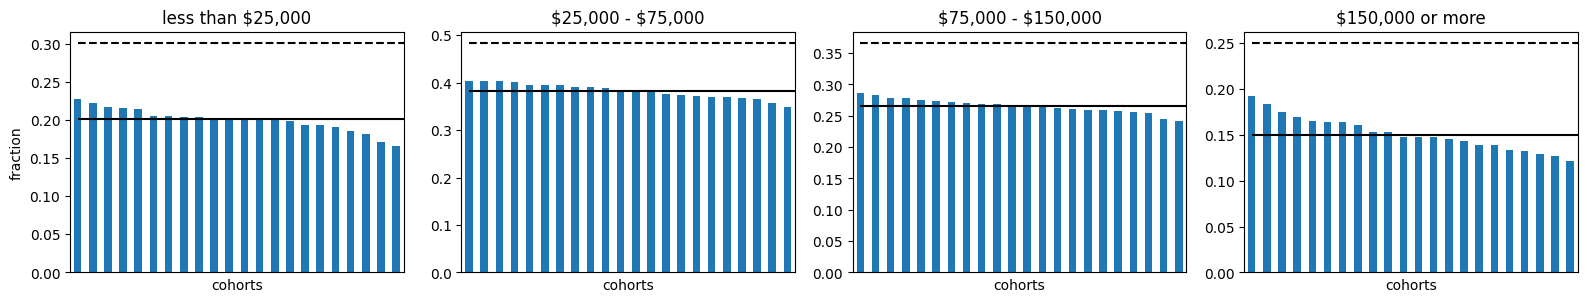


k=100 ---------------------------

checking panel 2 with size 23209
|C| = 152 total cohorts
k = 100
|C| / k = 1.520
cohort sizes:
count    152.000000
mean     152.690789
std       33.152714
min      100.000000
25%      124.000000
50%      152.000000
75%      176.500000
max      246.000000
Name: cohort, dtype: float64


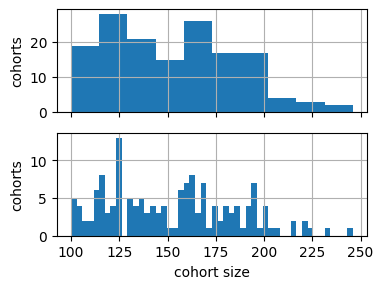

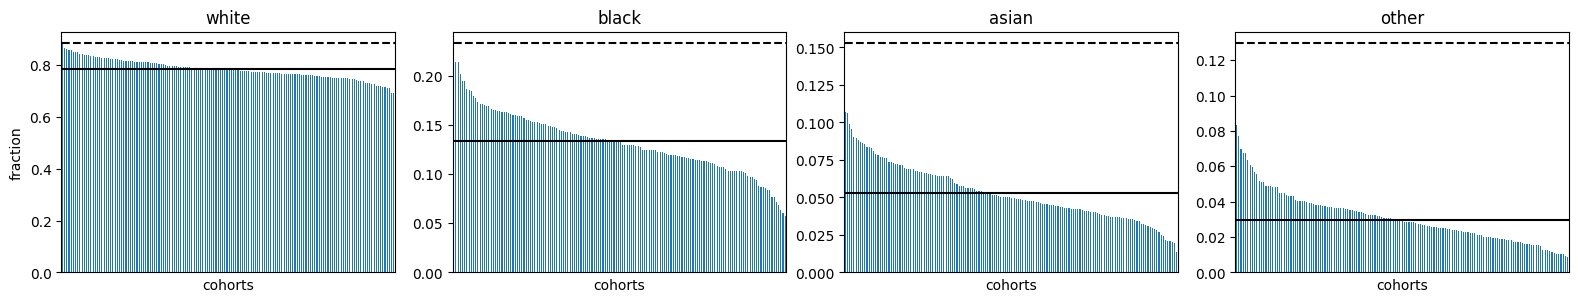

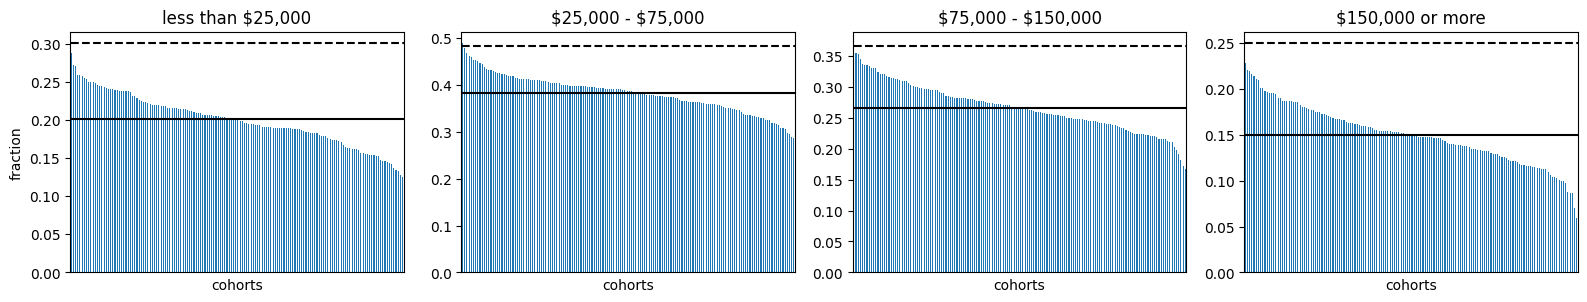

checking panel 22 with size 21768
|C| = 141 total cohorts
k = 100
|C| / k = 1.410
cohort sizes:
count    141.000000
mean     154.382979
std       34.652079
min      100.000000
25%      128.000000
50%      145.000000
75%      181.000000
max      253.000000
Name: cohort, dtype: float64


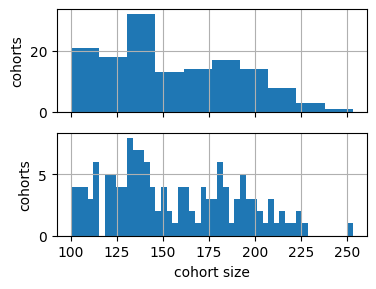

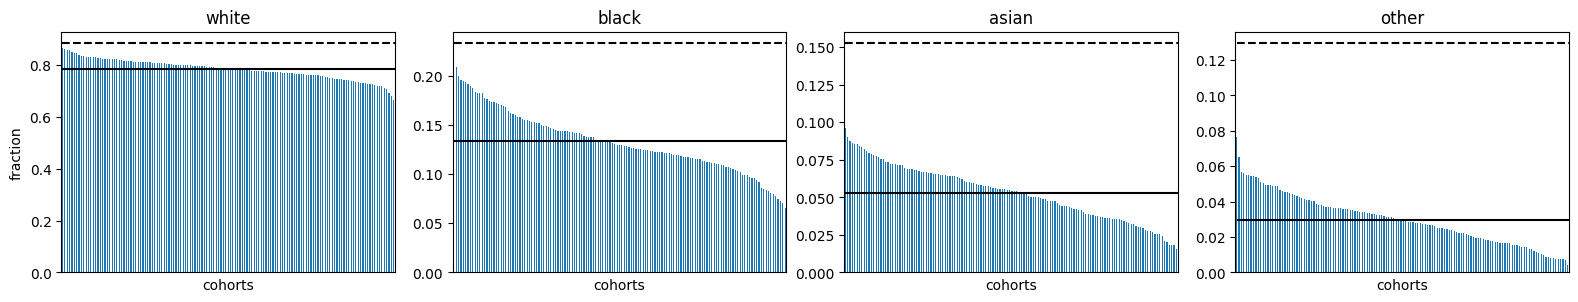

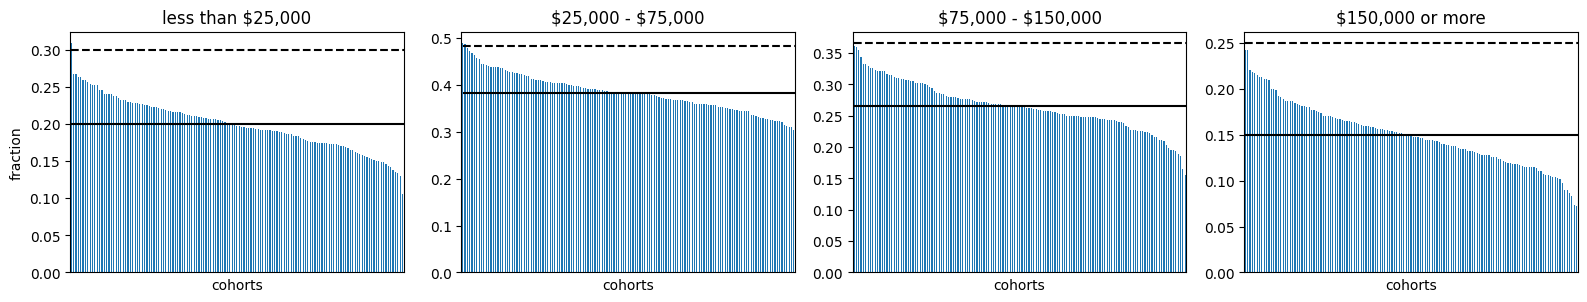

checking panel 32 with size 19579
|C| = 125 total cohorts
k = 100
|C| / k = 1.250
cohort sizes:
count    125.000000
mean     156.632000
std       40.940463
min      101.000000
25%      122.000000
50%      146.000000
75%      188.000000
max      268.000000
Name: cohort, dtype: float64


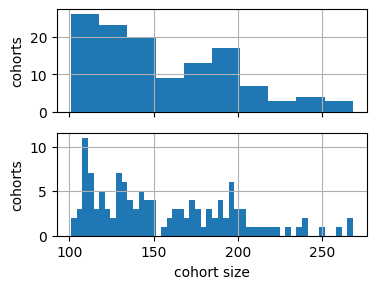

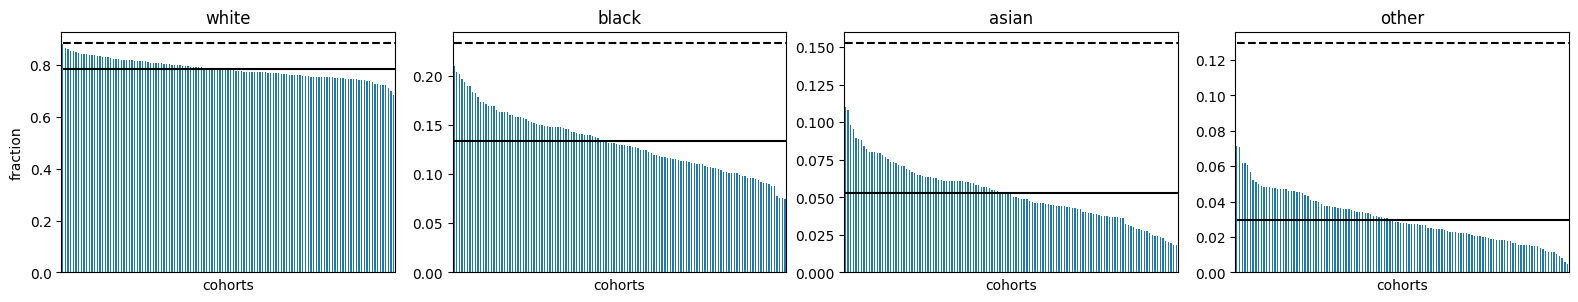

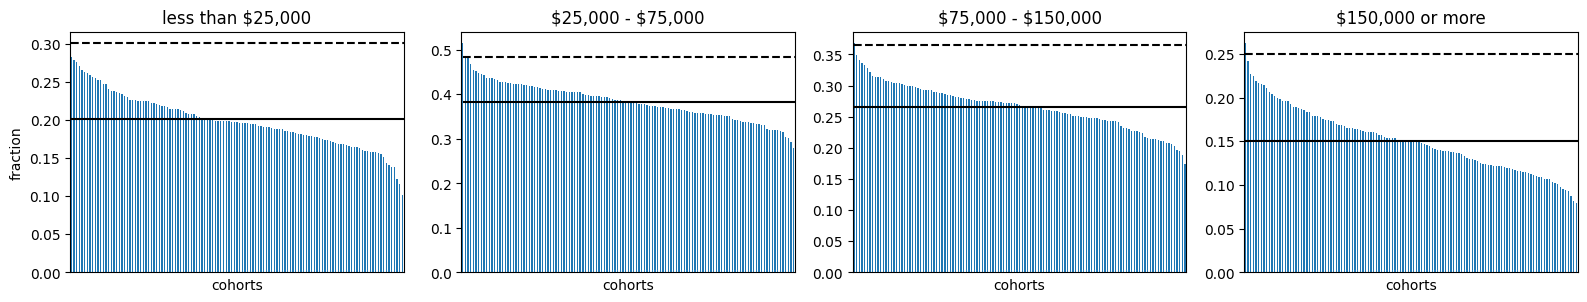

checking panel 42 with size 21745
|C| = 143 total cohorts
k = 100
|C| / k = 1.430
cohort sizes:
count    143.000000
mean     152.062937
std       33.600431
min      100.000000
25%      129.500000
50%      146.000000
75%      178.000000
max      274.000000
Name: cohort, dtype: float64


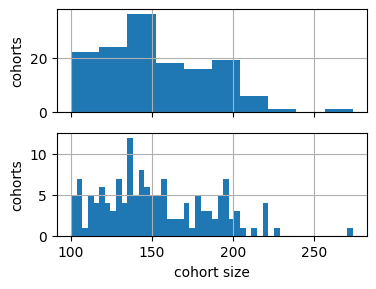

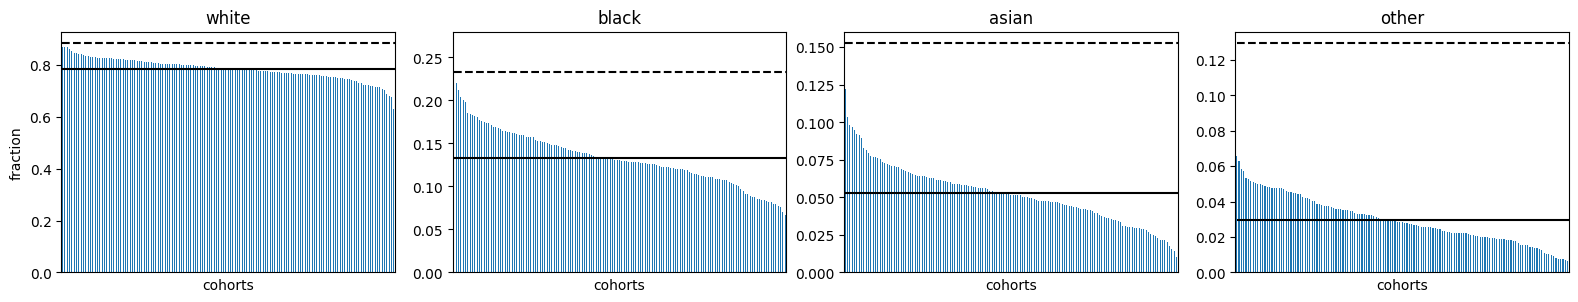

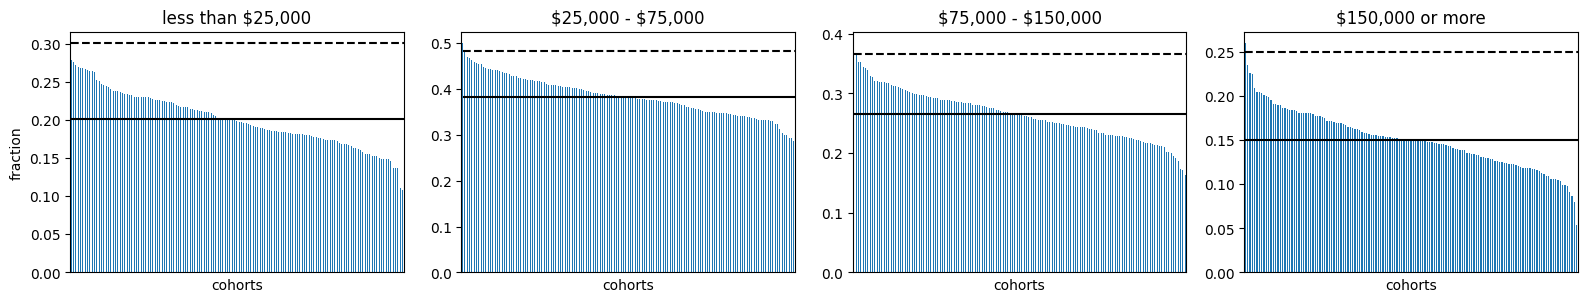

checking panel 52 with size 18286
|C| = 121 total cohorts
k = 100
|C| / k = 1.210
cohort sizes:
count    121.000000
mean     151.123967
std       32.386615
min      100.000000
25%      125.000000
50%      146.000000
75%      175.000000
max      232.000000
Name: cohort, dtype: float64


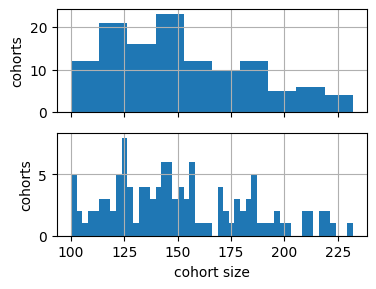

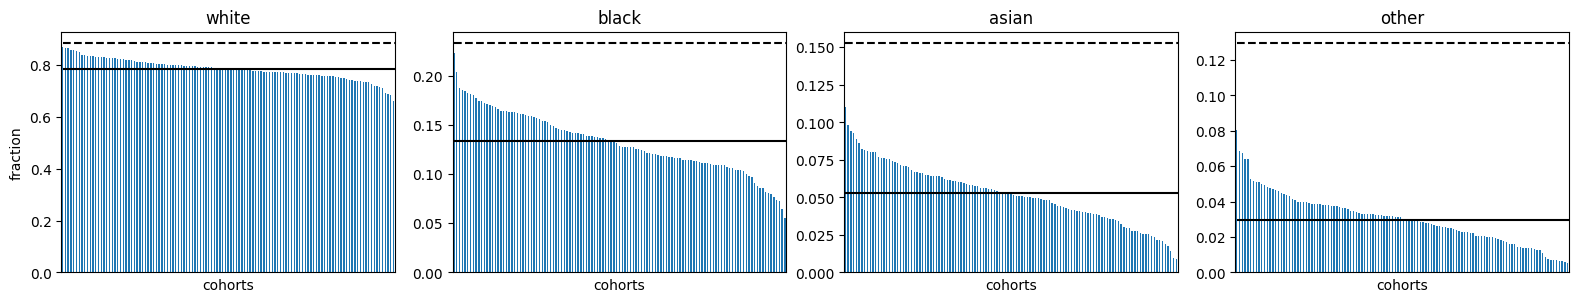

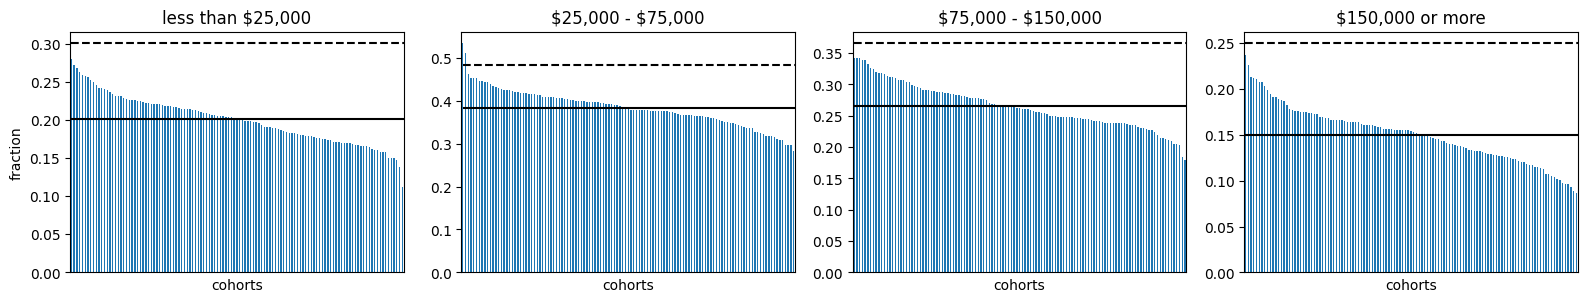


k=50 ---------------------------

checking panel 2 with size 23209
|C| = 278 total cohorts
k = 50
|C| / k = 5.560
cohort sizes:
count    278.000000
mean      83.485612
std       22.549220
min       50.000000
25%       65.000000
50%       80.000000
75%       98.750000
max      192.000000
Name: cohort, dtype: float64


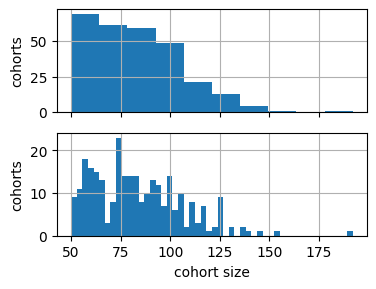

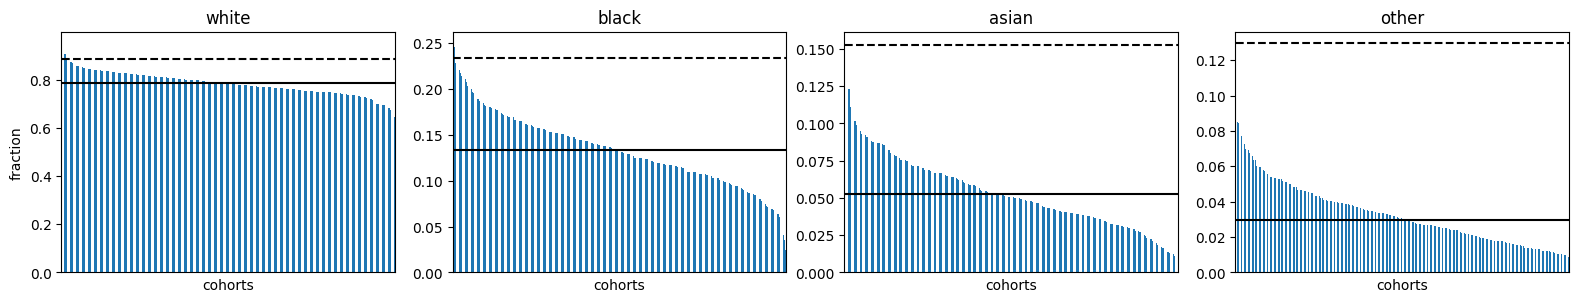

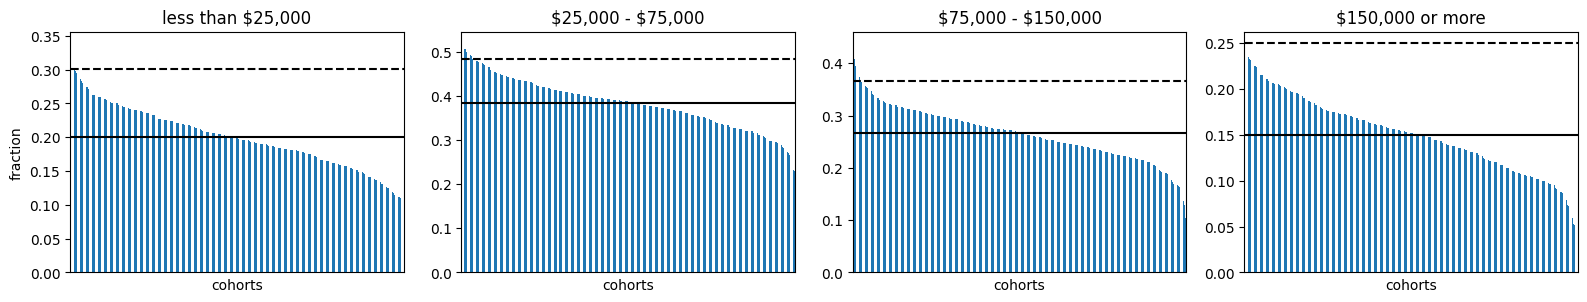

checking panel 22 with size 21768
|C| = 263 total cohorts
k = 50
|C| / k = 5.260
cohort sizes:
count    263.000000
mean      82.768061
std       23.143005
min       50.000000
25%       65.000000
50%       79.000000
75%       95.500000
max      160.000000
Name: cohort, dtype: float64


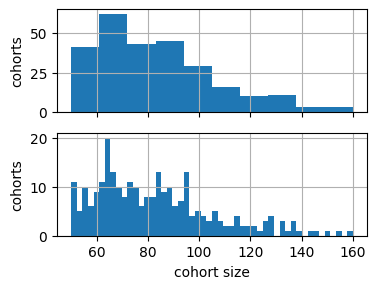

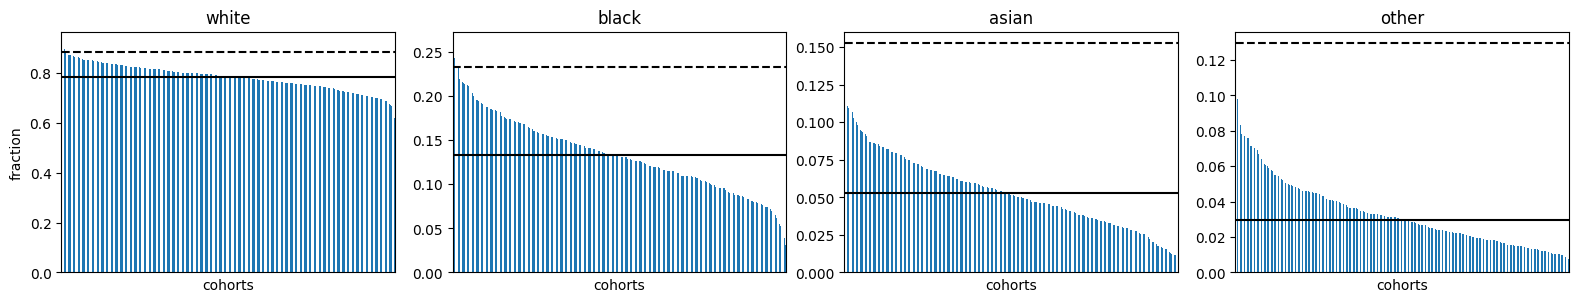

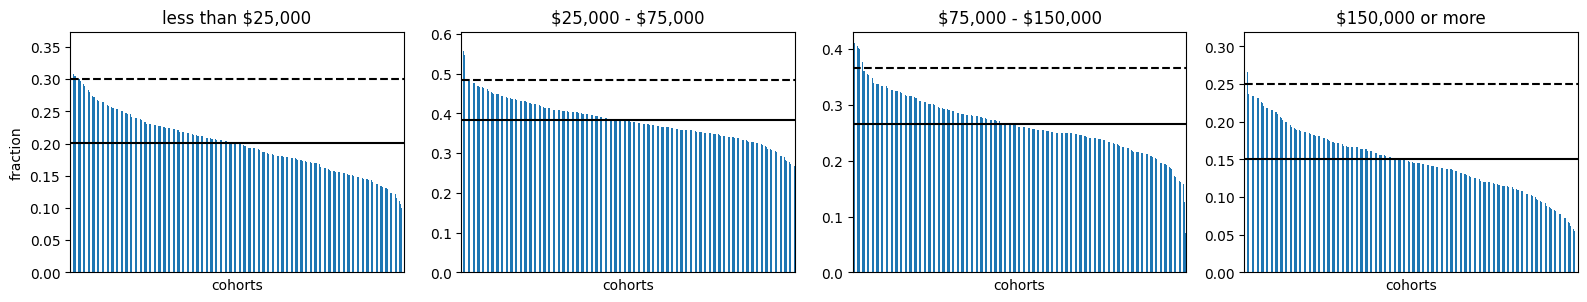

checking panel 32 with size 19579
|C| = 247 total cohorts
k = 50
|C| / k = 4.940
cohort sizes:
count    247.000000
mean      79.267206
std       21.827517
min       50.000000
25%       61.000000
50%       75.000000
75%       93.500000
max      164.000000
Name: cohort, dtype: float64


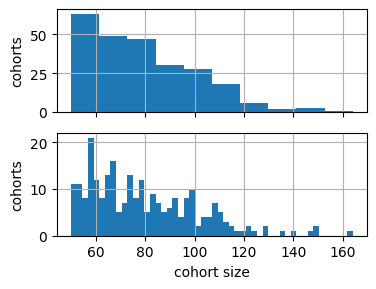

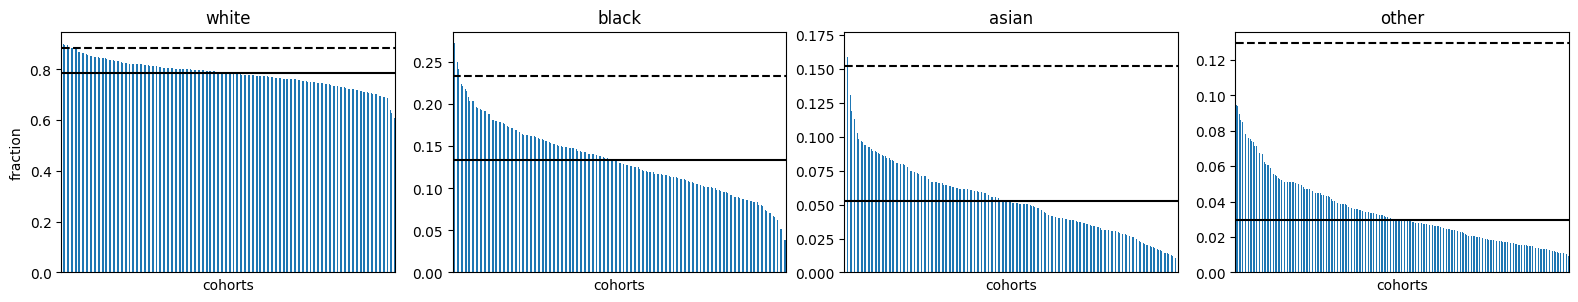

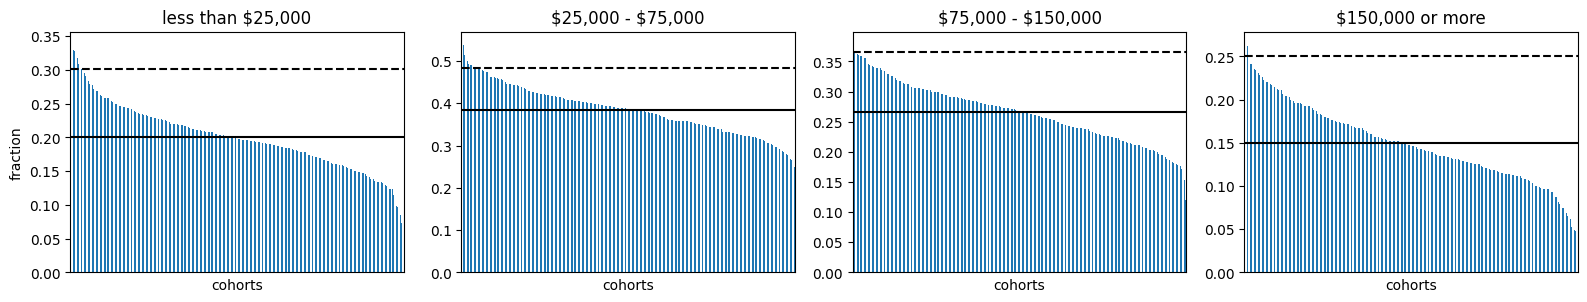

checking panel 42 with size 21745
|C| = 264 total cohorts
k = 50
|C| / k = 5.280
cohort sizes:
count    264.000000
mean      82.367424
std       21.817020
min       50.000000
25%       64.000000
50%       79.000000
75%       97.250000
max      162.000000
Name: cohort, dtype: float64


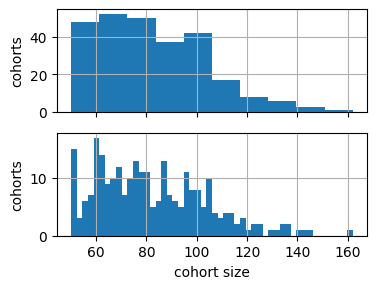

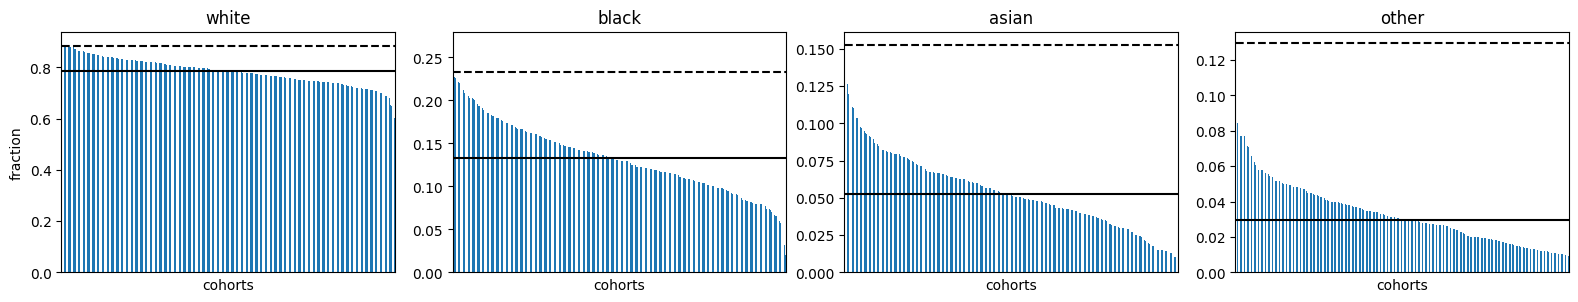

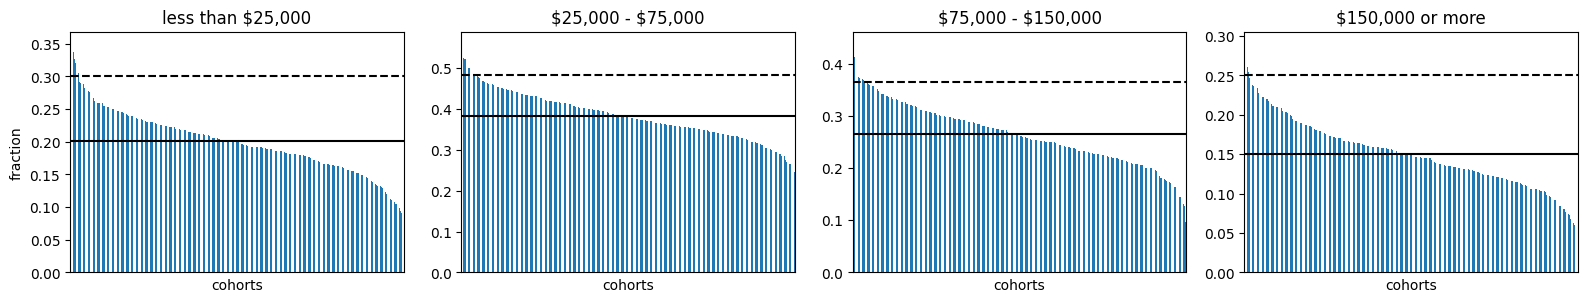

checking panel 52 with size 18286
|C| = 226 total cohorts
k = 50
|C| / k = 4.520
cohort sizes:
count    226.000000
mean      80.911504
std       23.879162
min       50.000000
25%       64.000000
50%       75.500000
75%       94.000000
max      191.000000
Name: cohort, dtype: float64


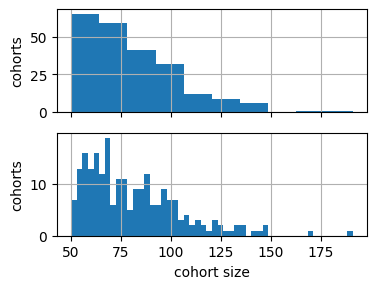

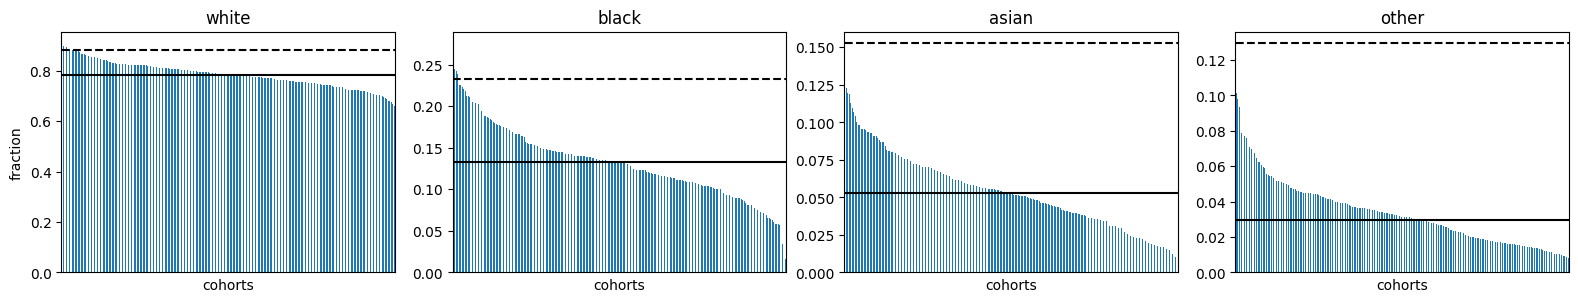

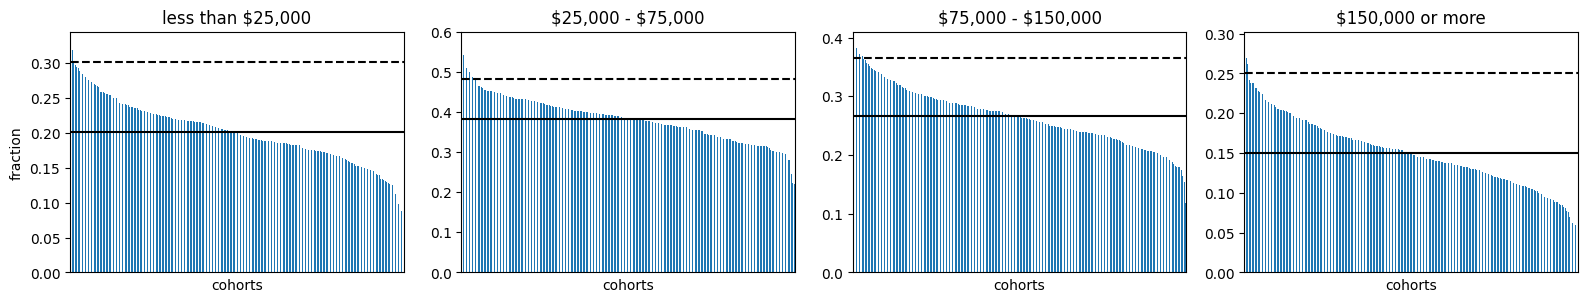


k=35 ---------------------------

checking panel 2 with size 23209
|C| = 399 total cohorts
k = 35
|C| / k = 11.400
cohort sizes:
count    399.000000
mean      58.167920
std       18.290354
min       35.000000
25%       44.000000
50%       55.000000
75%       68.500000
max      140.000000
Name: cohort, dtype: float64


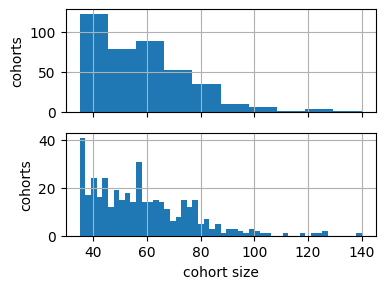

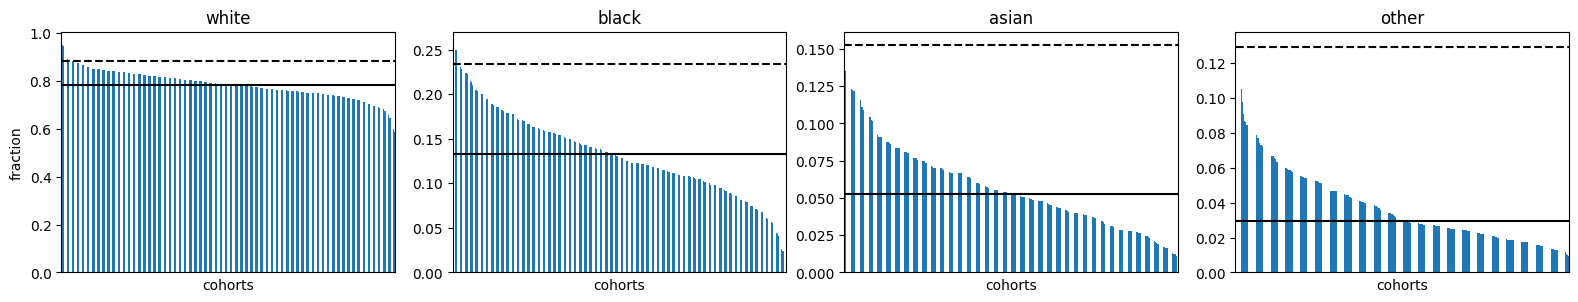

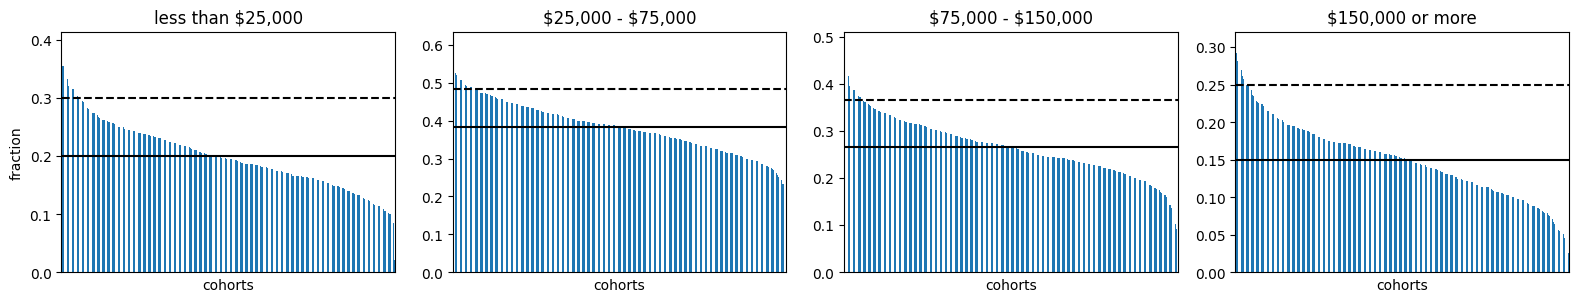

checking panel 22 with size 21768
|C| = 365 total cohorts
k = 35
|C| / k = 10.429
cohort sizes:
count    365.000000
mean      59.638356
std       17.601688
min       35.000000
25%       44.000000
50%       58.000000
75%       70.000000
max      114.000000
Name: cohort, dtype: float64


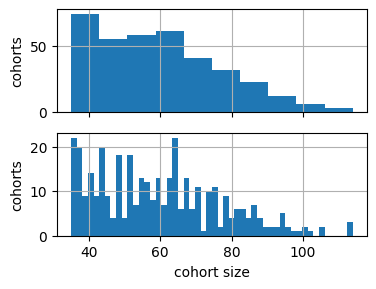

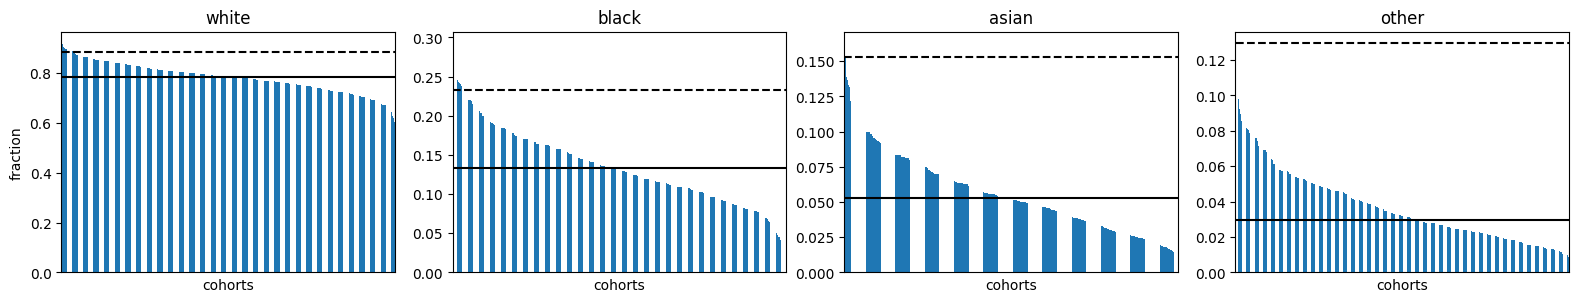

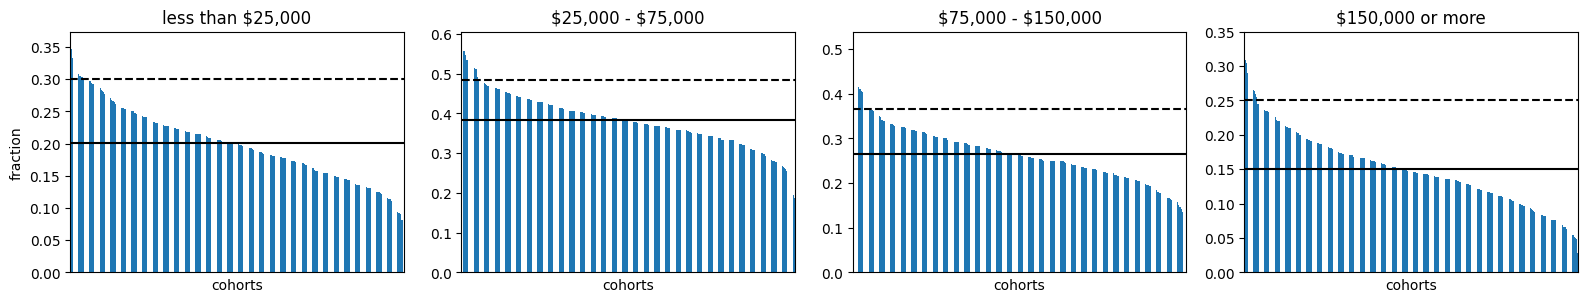

checking panel 32 with size 19579
|C| = 330 total cohorts
k = 35
|C| / k = 9.429
cohort sizes:
count    330.000000
mean      59.330303
std       16.073444
min       35.000000
25%       47.000000
50%       58.000000
75%       68.000000
max      114.000000
Name: cohort, dtype: float64


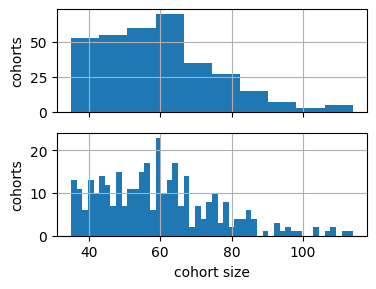

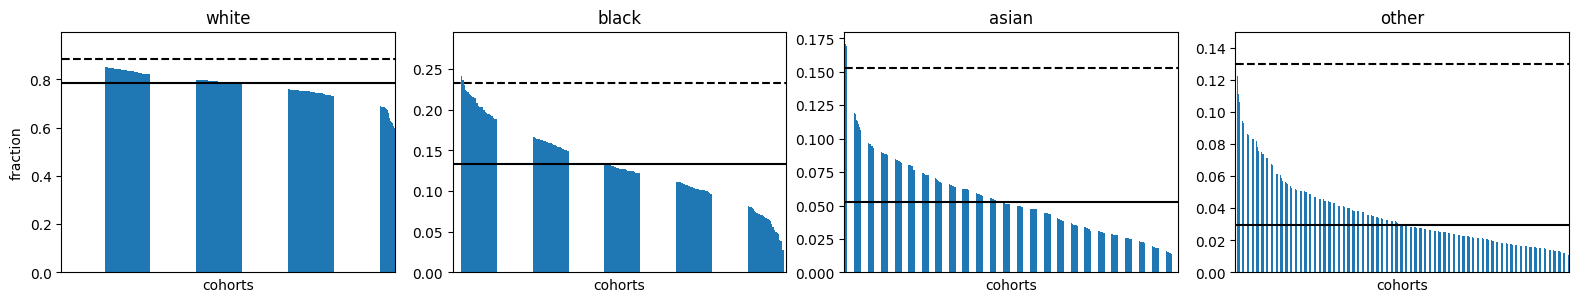

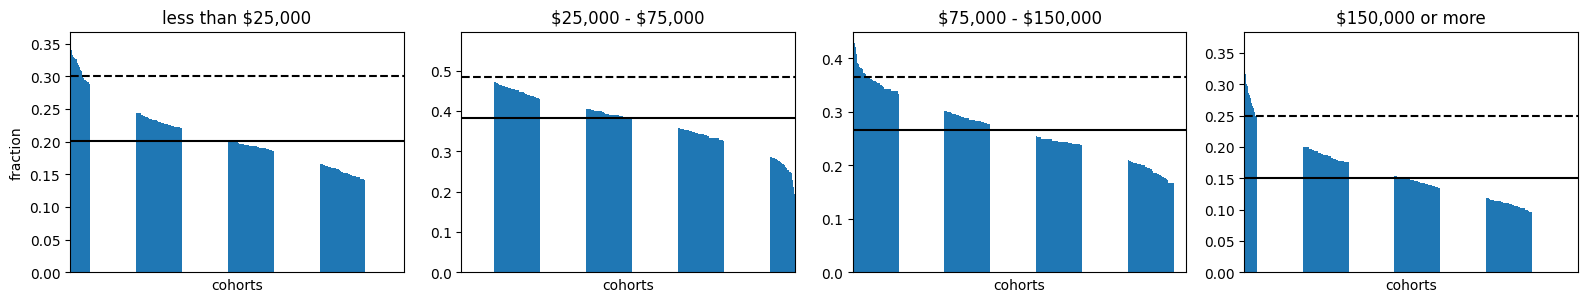

checking panel 42 with size 21745
|C| = 372 total cohorts
k = 35
|C| / k = 10.629
cohort sizes:
count    372.000000
mean      58.454301
std       16.738533
min       35.000000
25%       44.750000
50%       57.000000
75%       69.000000
max      124.000000
Name: cohort, dtype: float64


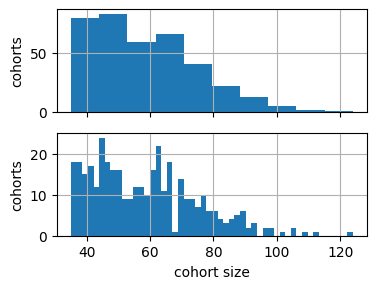

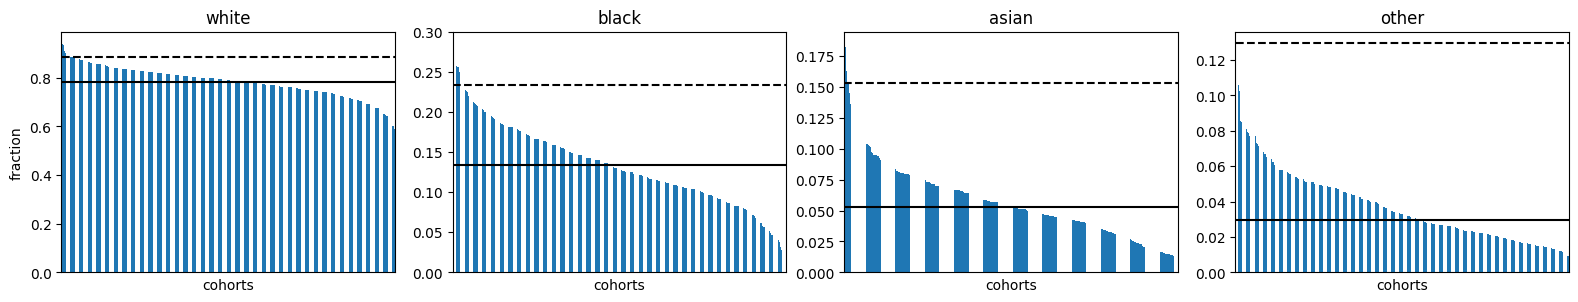

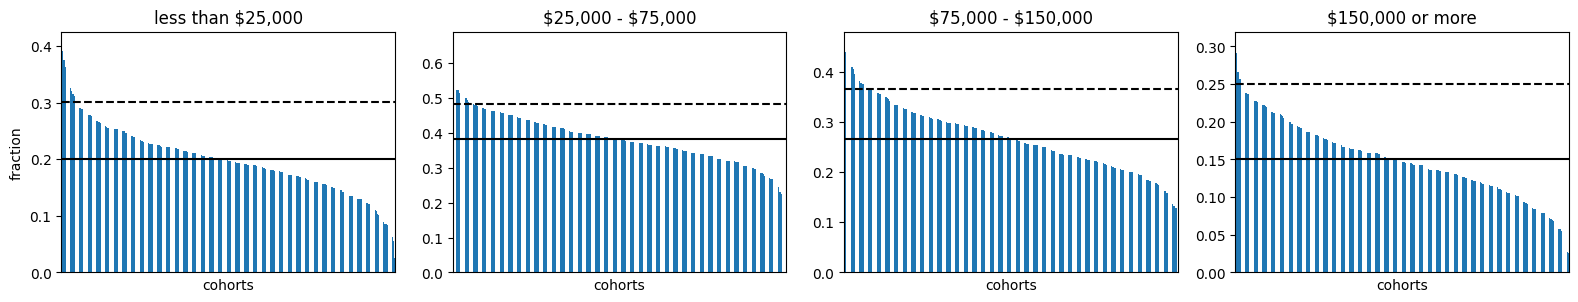

checking panel 52 with size 18286
|C| = 311 total cohorts
k = 35
|C| / k = 8.886
cohort sizes:
count    311.000000
mean      58.797428
std       16.656708
min       35.000000
25%       46.000000
50%       57.000000
75%       68.000000
max      132.000000
Name: cohort, dtype: float64


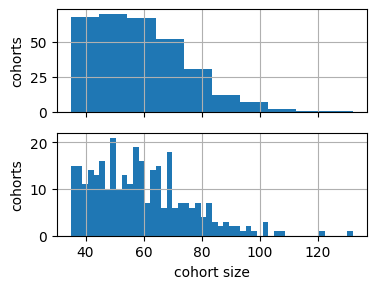

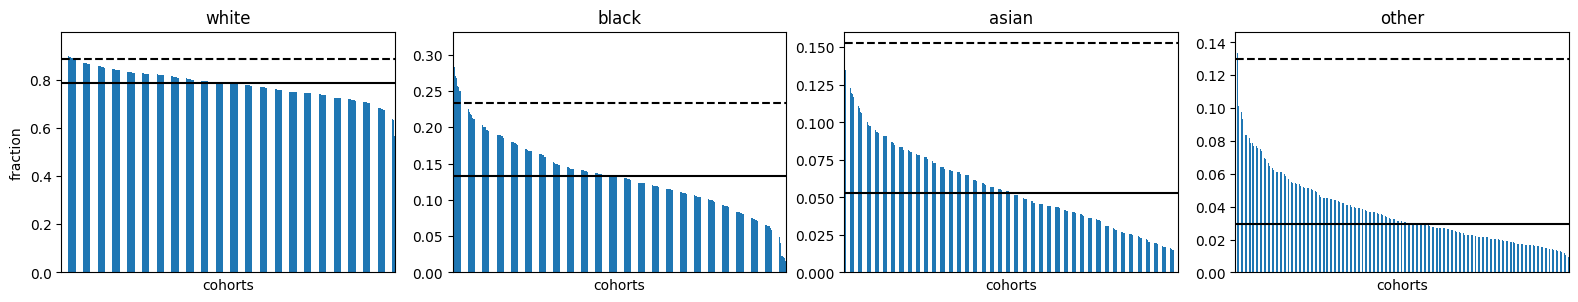

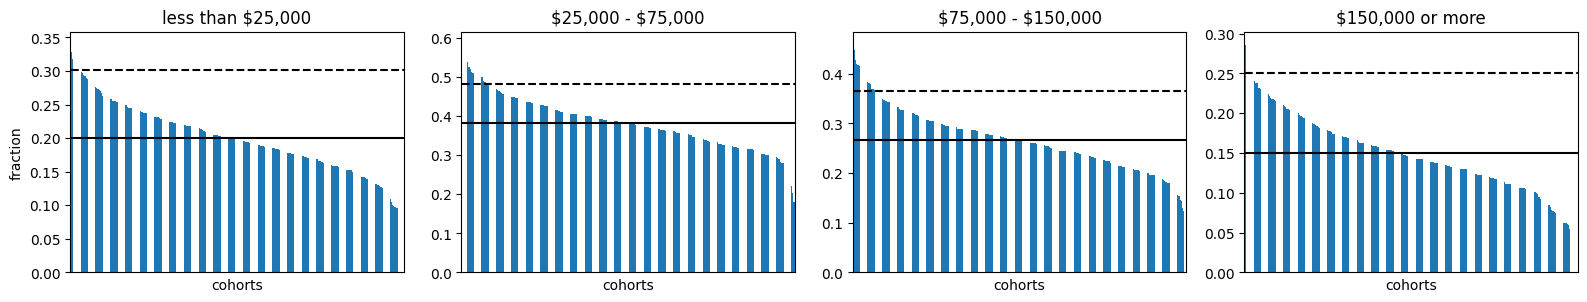


k=32 ---------------------------

checking panel 2 with size 23209
|C| = 455 total cohorts
k = 32
|C| / k = 14.219
cohort sizes:
count    455.000000
mean      51.008791
std       15.478702
min       32.000000
25%       38.000000
50%       48.000000
75%       60.000000
max      124.000000
Name: cohort, dtype: float64


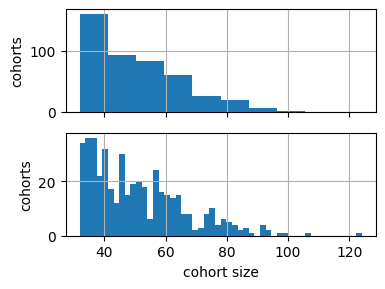

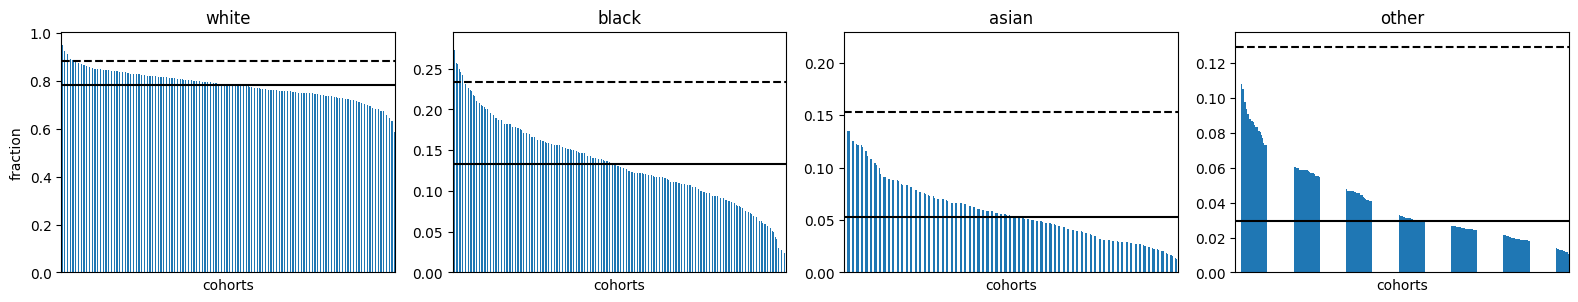

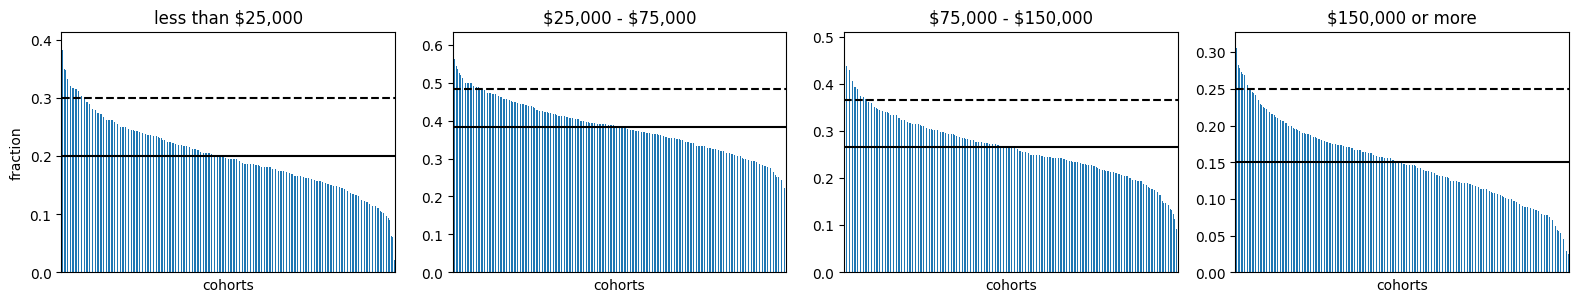

checking panel 22 with size 21768
|C| = 406 total cohorts
k = 32
|C| / k = 12.688
cohort sizes:
count    406.000000
mean      53.615764
std       16.264789
min       32.000000
25%       40.000000
50%       52.000000
75%       64.000000
max      113.000000
Name: cohort, dtype: float64


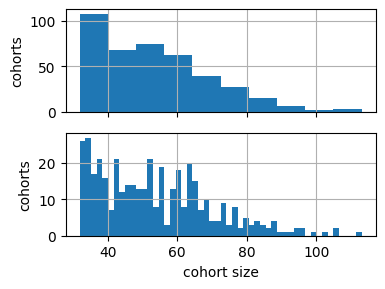

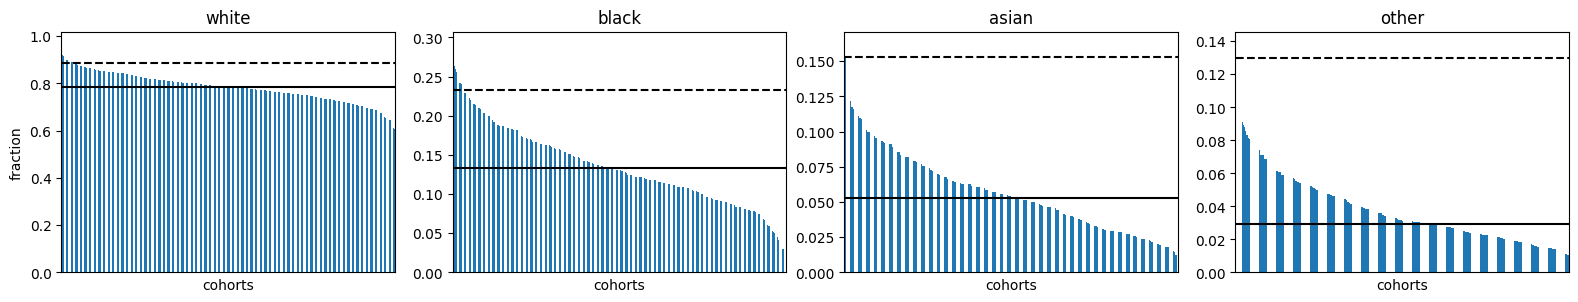

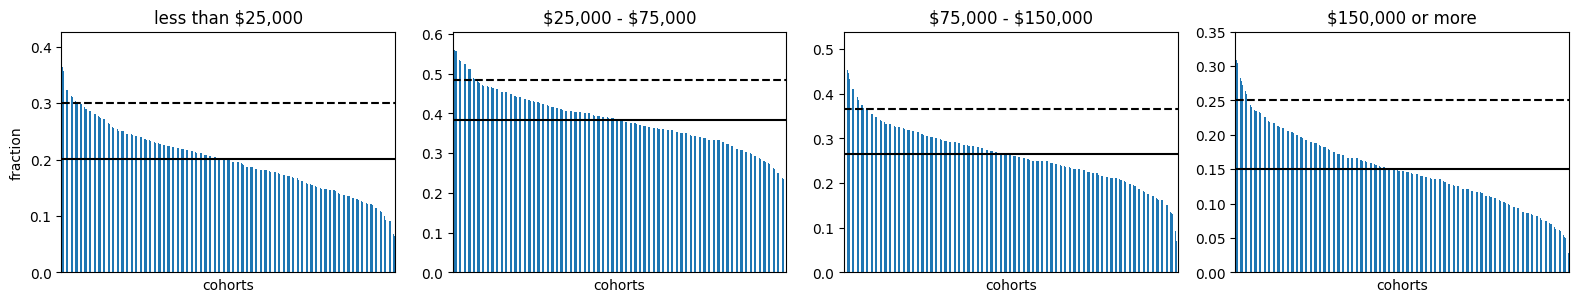

checking panel 32 with size 19579
|C| = 367 total cohorts
k = 32
|C| / k = 11.469
cohort sizes:
count    367.000000
mean      53.348774
std       14.971682
min       32.000000
25%       42.000000
50%       53.000000
75%       62.000000
max      114.000000
Name: cohort, dtype: float64


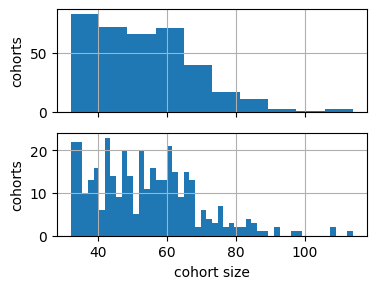

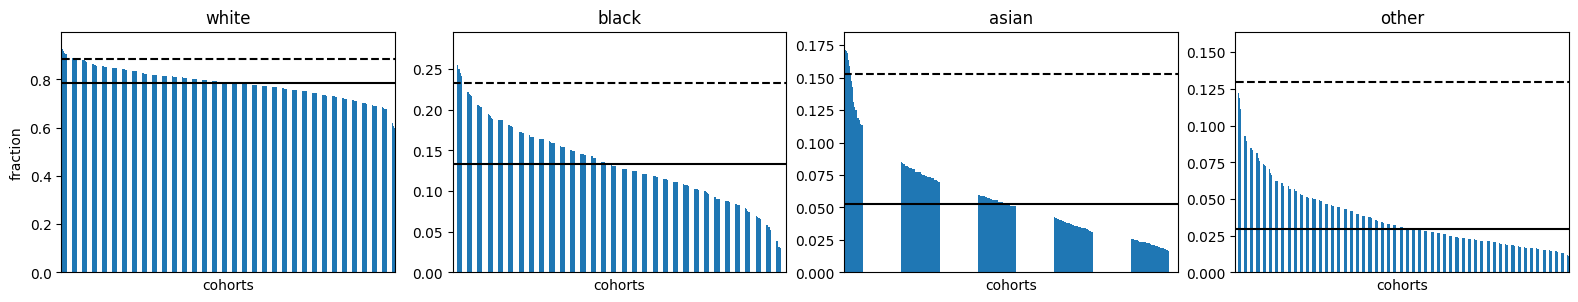

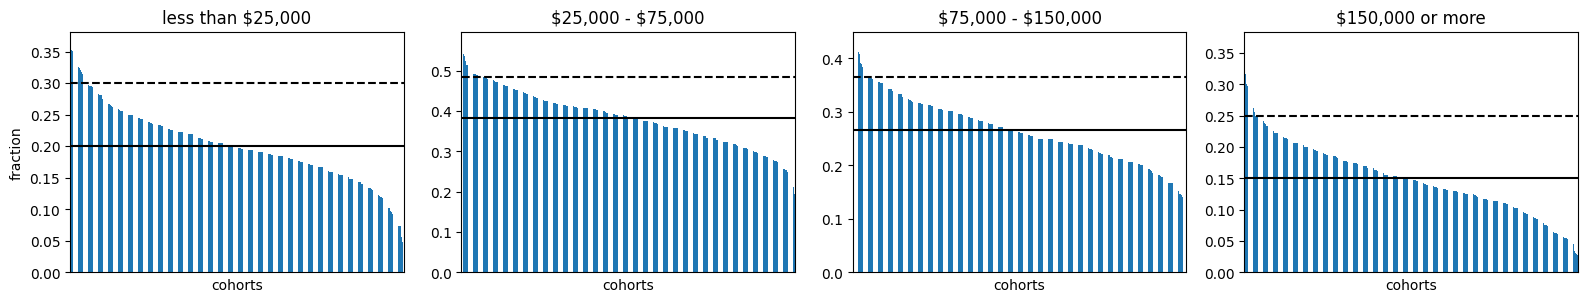

checking panel 42 with size 21745
|C| = 428 total cohorts
k = 32
|C| / k = 13.375
cohort sizes:
count    428.000000
mean      50.806075
std       14.377065
min       32.000000
25%       39.000000
50%       48.000000
75%       60.250000
max      113.000000
Name: cohort, dtype: float64


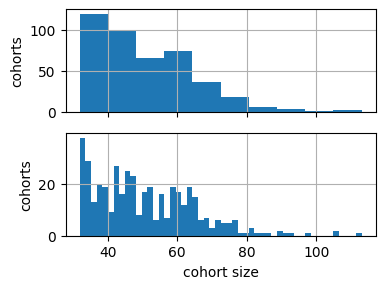

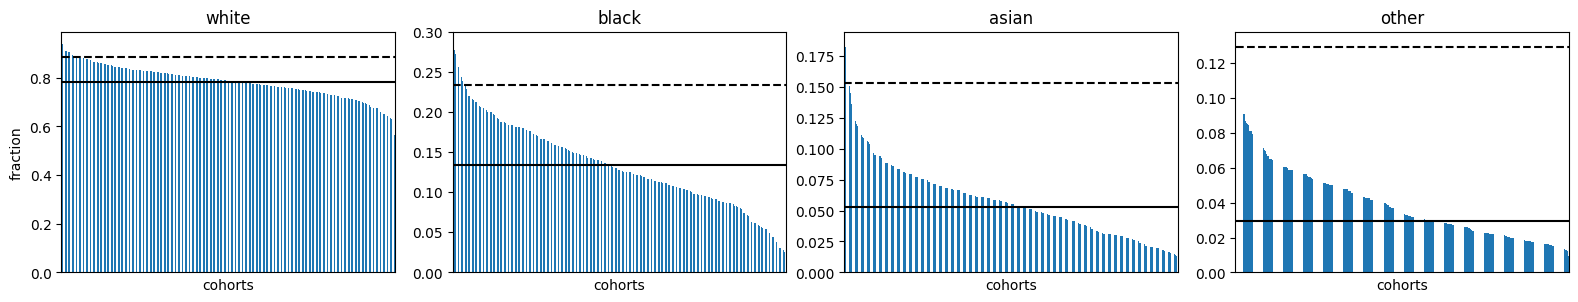

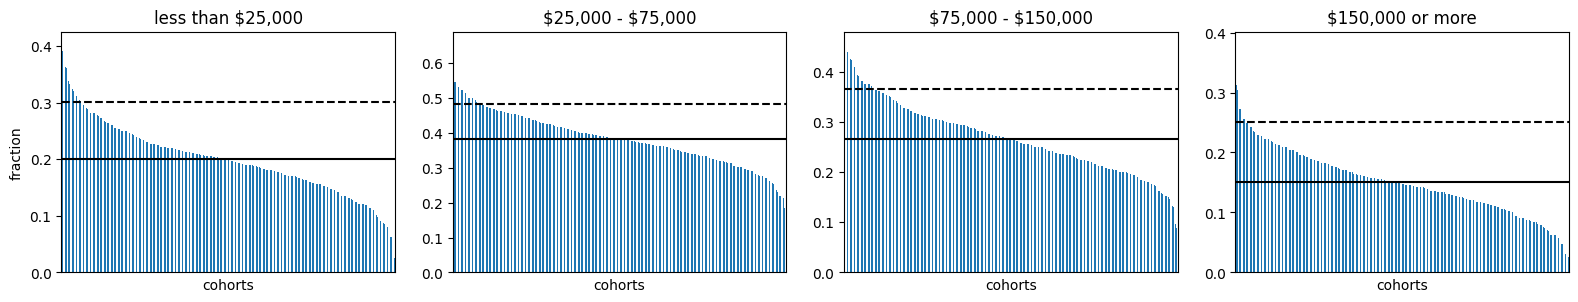

checking panel 52 with size 18286
|C| = 335 total cohorts
k = 32
|C| / k = 10.469
cohort sizes:
count    335.000000
mean      54.585075
std       14.826878
min       32.000000
25%       42.500000
50%       54.000000
75%       65.000000
max      105.000000
Name: cohort, dtype: float64


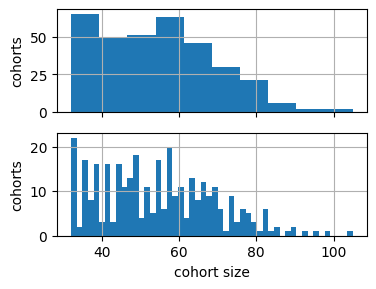

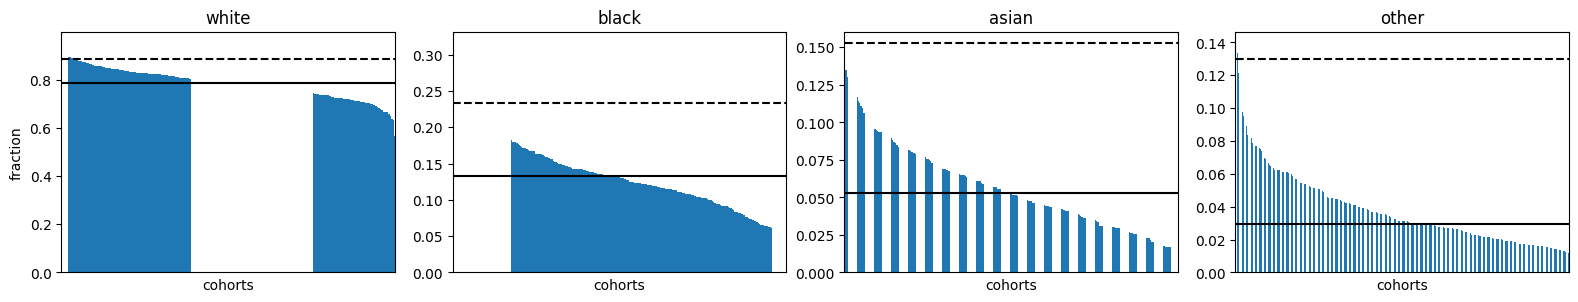

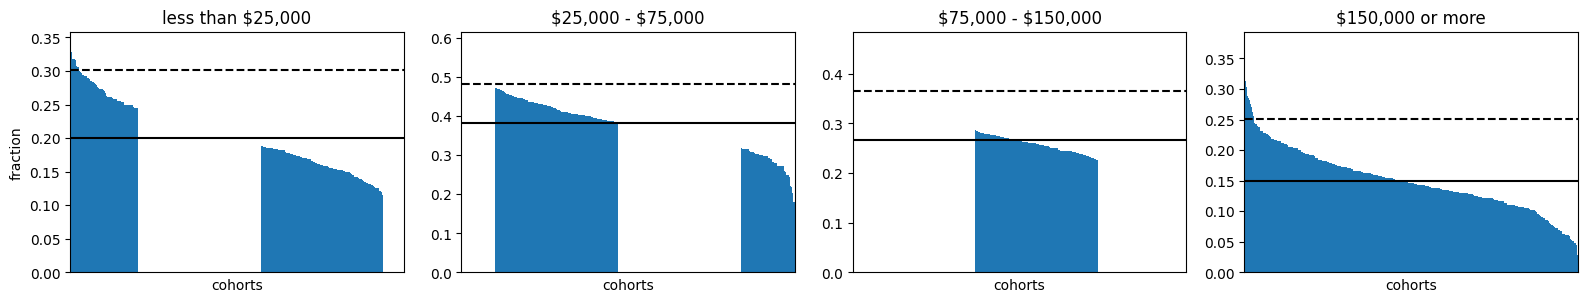


k=31 ---------------------------

checking panel 2 with size 23209
|C| = 469 total cohorts
k = 31
|C| / k = 15.129
cohort sizes:
count    469.000000
mean      49.486141
std       14.747531
min       31.000000
25%       37.000000
50%       46.000000
75%       58.000000
max      124.000000
Name: cohort, dtype: float64


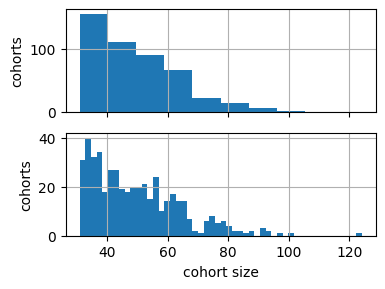

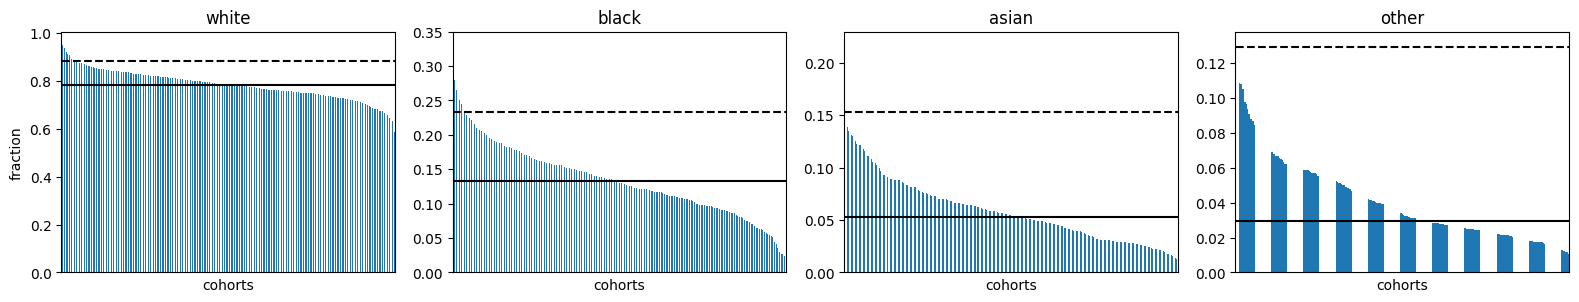

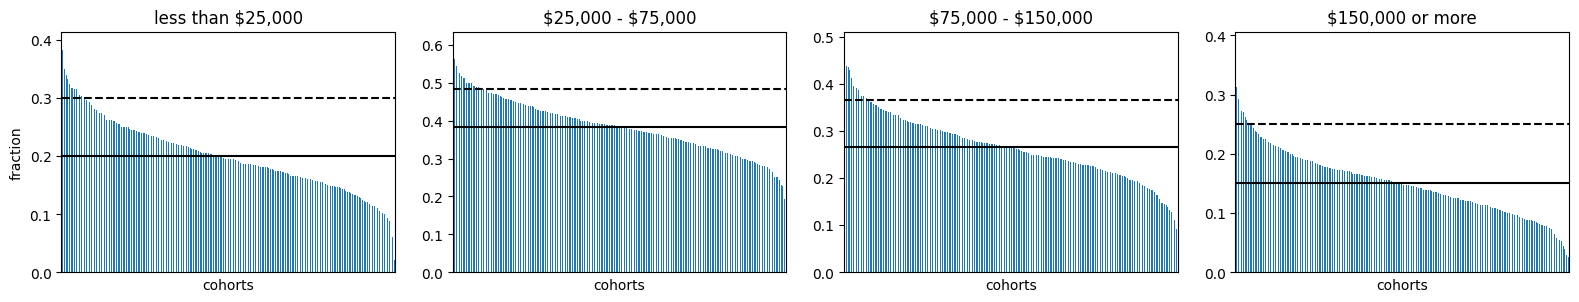

checking panel 22 with size 21768
|C| = 420 total cohorts
k = 31
|C| / k = 13.548
cohort sizes:
count    420.000000
mean      51.828571
std       15.674772
min       31.000000
25%       38.000000
50%       49.000000
75%       62.000000
max      106.000000
Name: cohort, dtype: float64


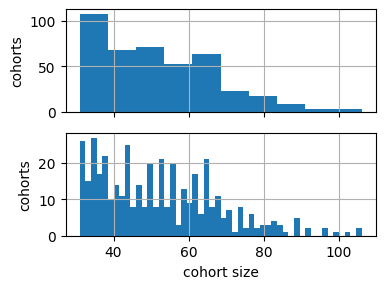

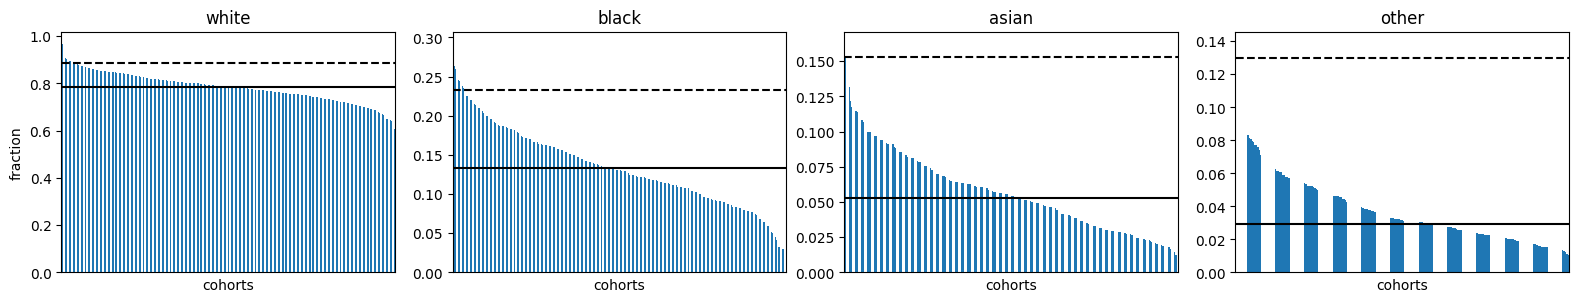

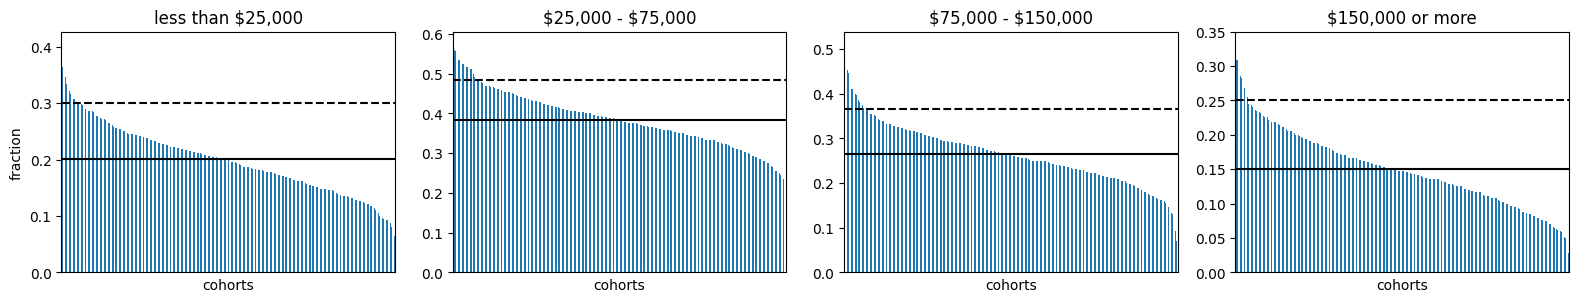

checking panel 32 with size 19579
|C| = 385 total cohorts
k = 31
|C| / k = 12.419
cohort sizes:
count    385.000000
mean      50.854545
std       14.123880
min       31.000000
25%       39.000000
50%       50.000000
75%       60.000000
max      114.000000
Name: cohort, dtype: float64


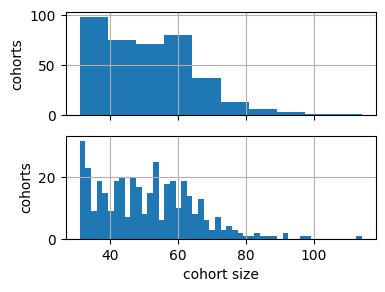

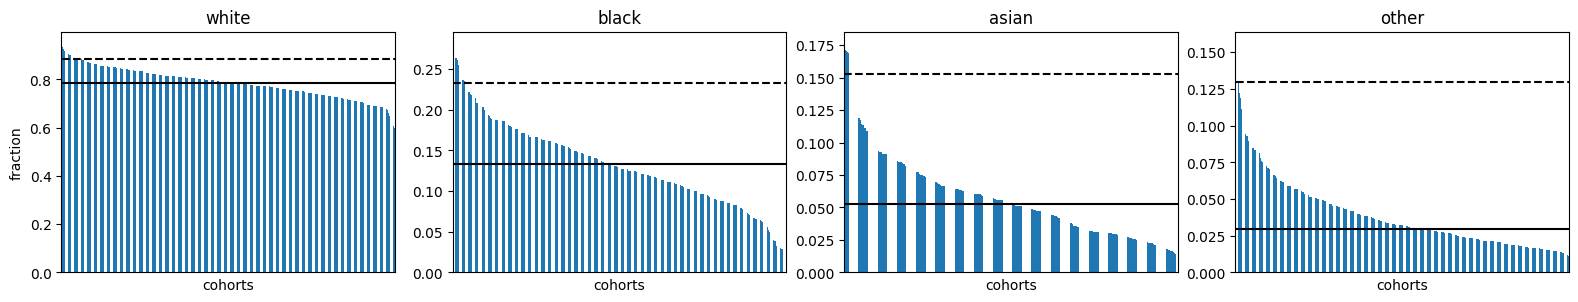

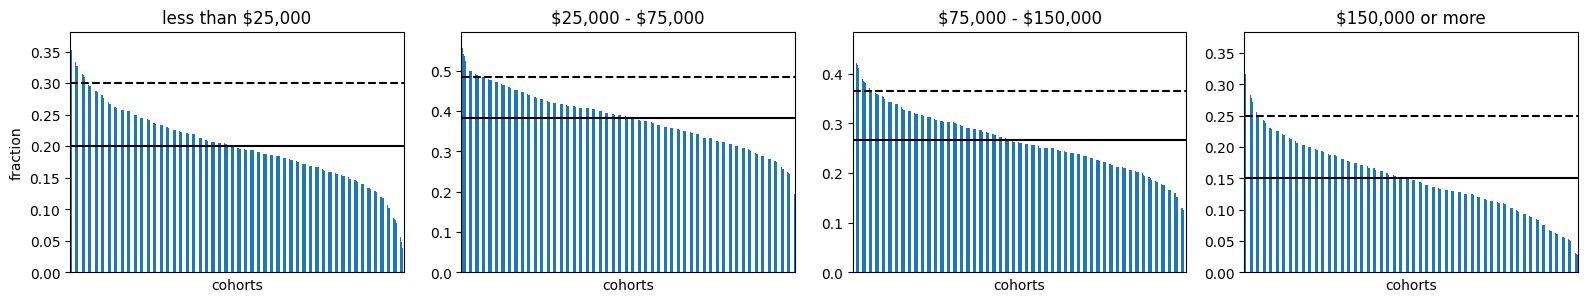

checking panel 42 with size 21745
|C| = 440 total cohorts
k = 31
|C| / k = 14.194
cohort sizes:
count    440.000000
mean      49.420455
std       14.074097
min       31.000000
25%       38.000000
50%       47.000000
75%       59.000000
max      113.000000
Name: cohort, dtype: float64


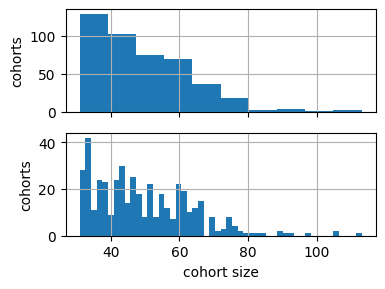

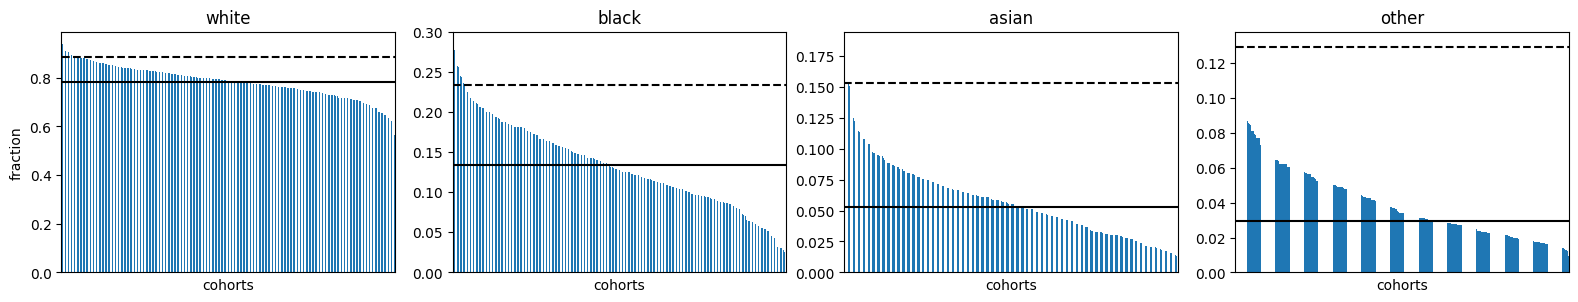

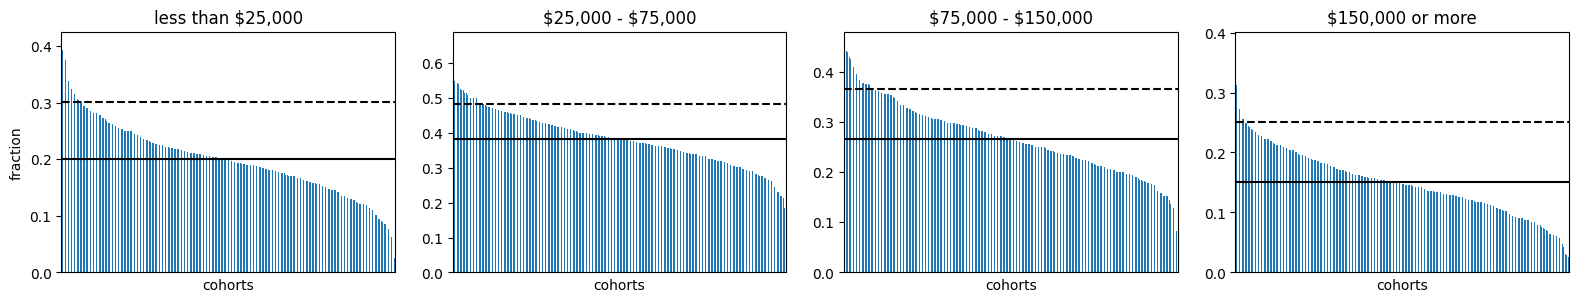

checking panel 52 with size 18286
|C| = 347 total cohorts
k = 31
|C| / k = 11.194
cohort sizes:
count    347.000000
mean      52.697406
std       14.990289
min       31.000000
25%       40.500000
50%       51.000000
75%       64.000000
max      105.000000
Name: cohort, dtype: float64


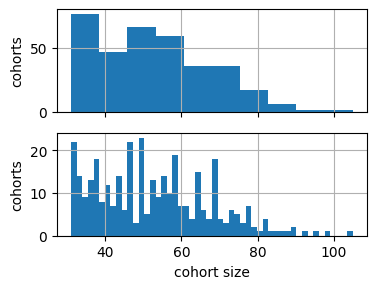

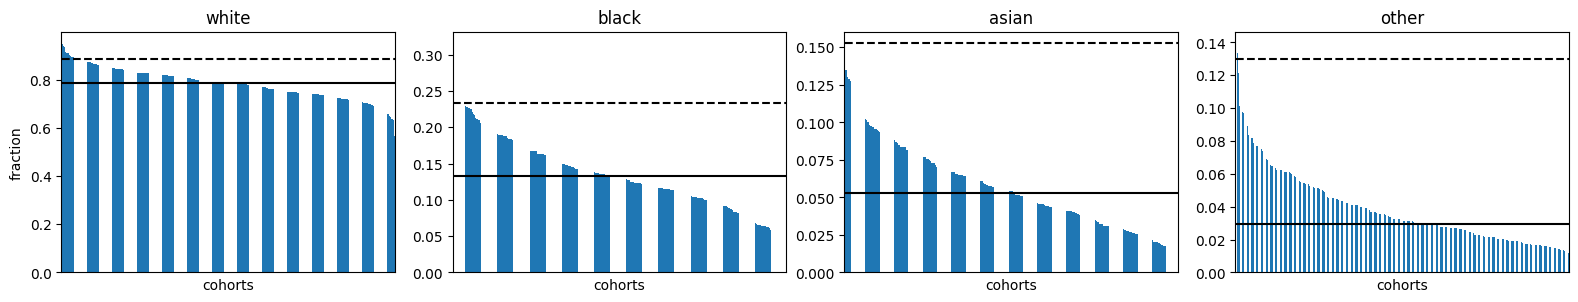

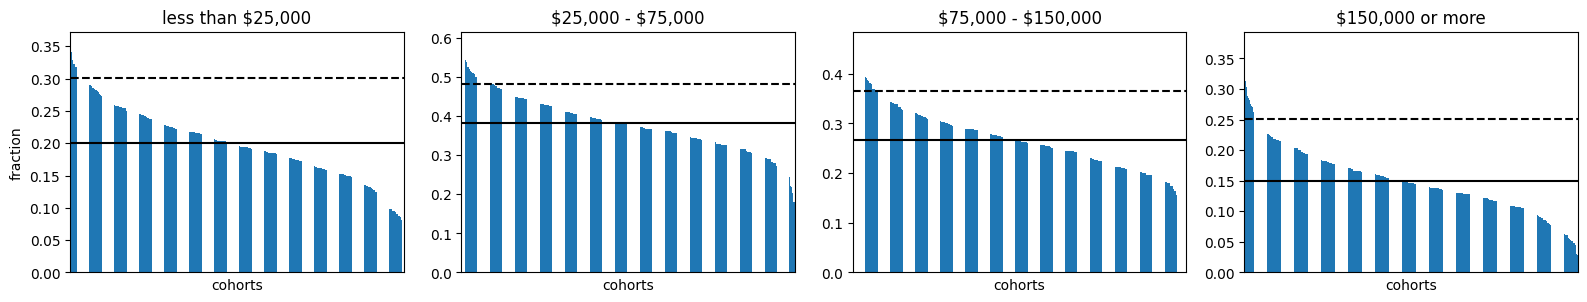


k=30 ---------------------------

checking panel 2 with size 23209
|C| = 492 total cohorts
k = 30
|C| / k = 16.400
cohort sizes:
count    492.000000
mean      47.172764
std       13.906900
min       30.000000
25%       36.000000
50%       44.000000
75%       56.000000
max      100.000000
Name: cohort, dtype: float64


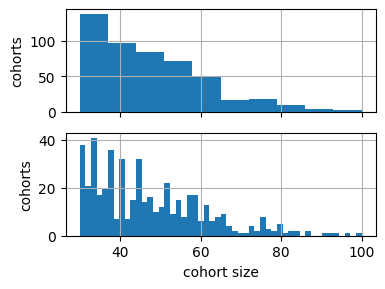

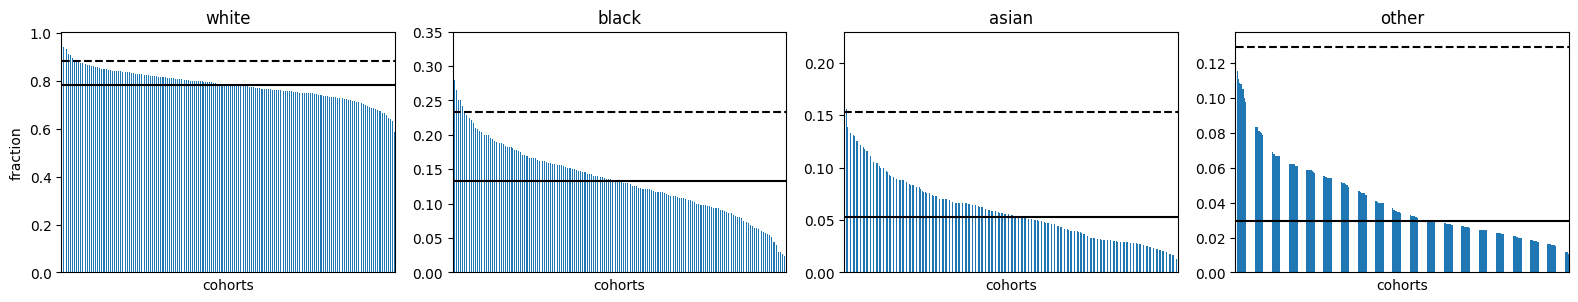

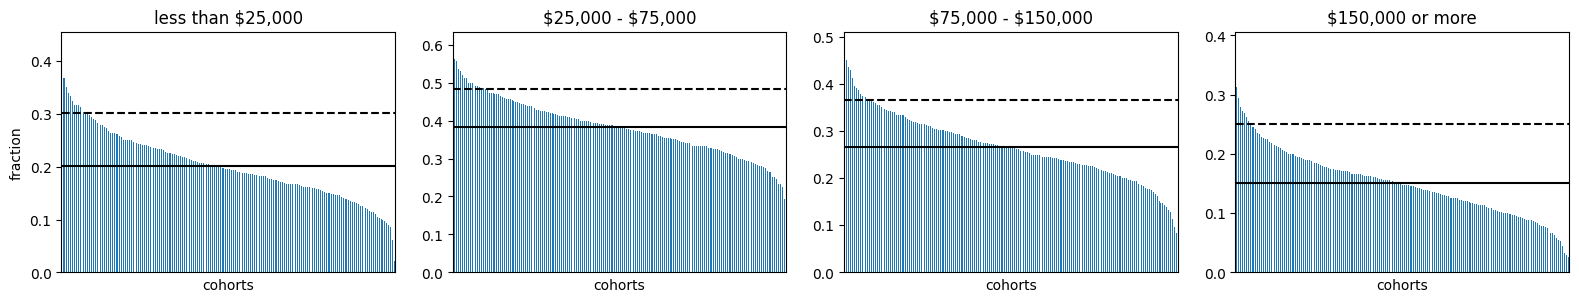

checking panel 22 with size 21768
|C| = 434 total cohorts
k = 30
|C| / k = 14.467
cohort sizes:
count    434.000000
mean      50.156682
std       15.187918
min       30.000000
25%       37.000000
50%       48.000000
75%       60.750000
max      106.000000
Name: cohort, dtype: float64


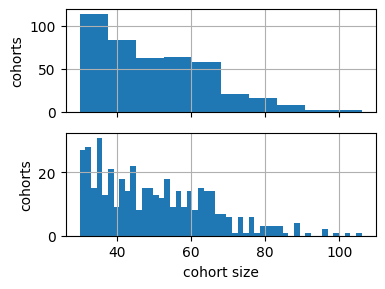

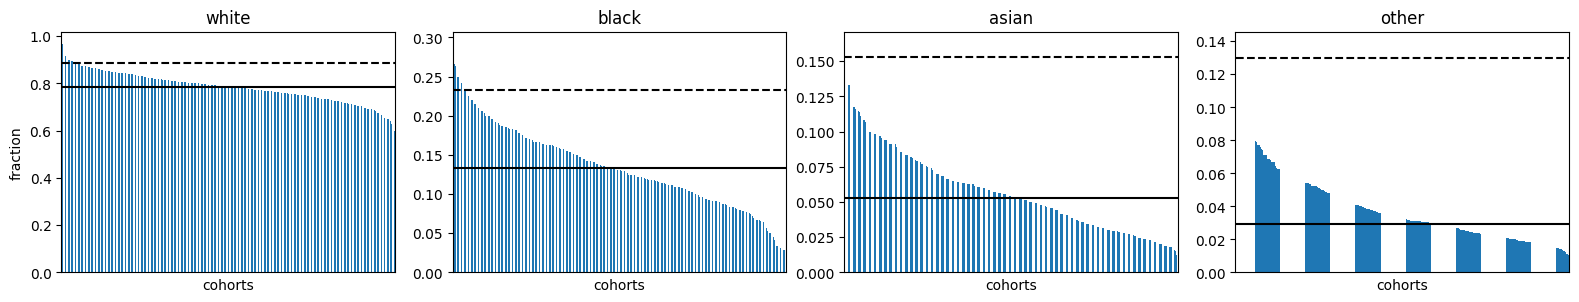

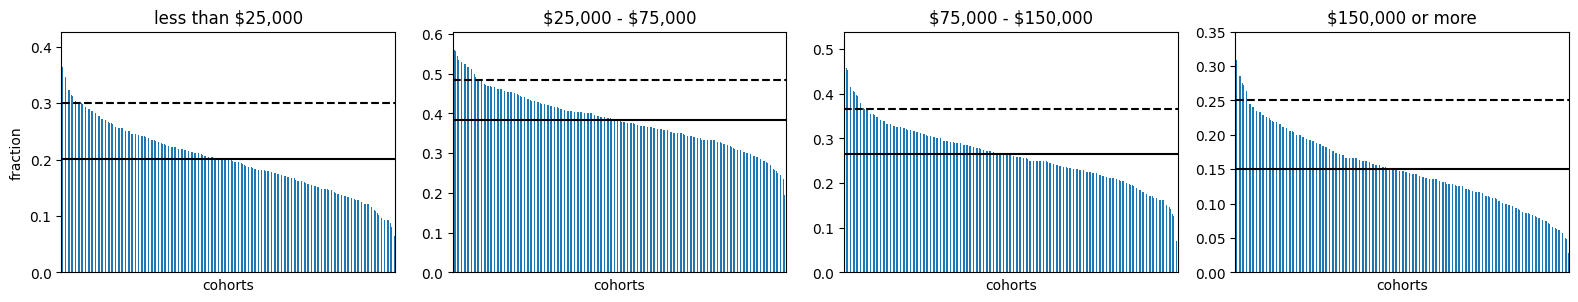

checking panel 32 with size 19579
|C| = 403 total cohorts
k = 30
|C| / k = 13.433
cohort sizes:
count    403.000000
mean      48.583127
std       13.400450
min       30.000000
25%       37.000000
50%       47.000000
75%       59.000000
max       98.000000
Name: cohort, dtype: float64


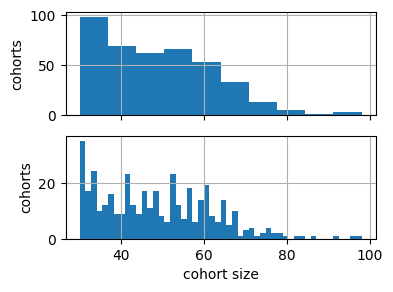

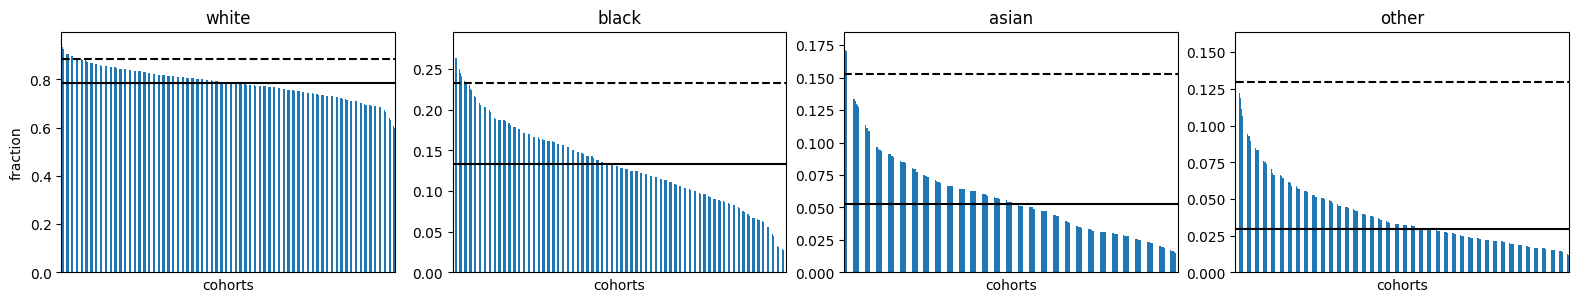

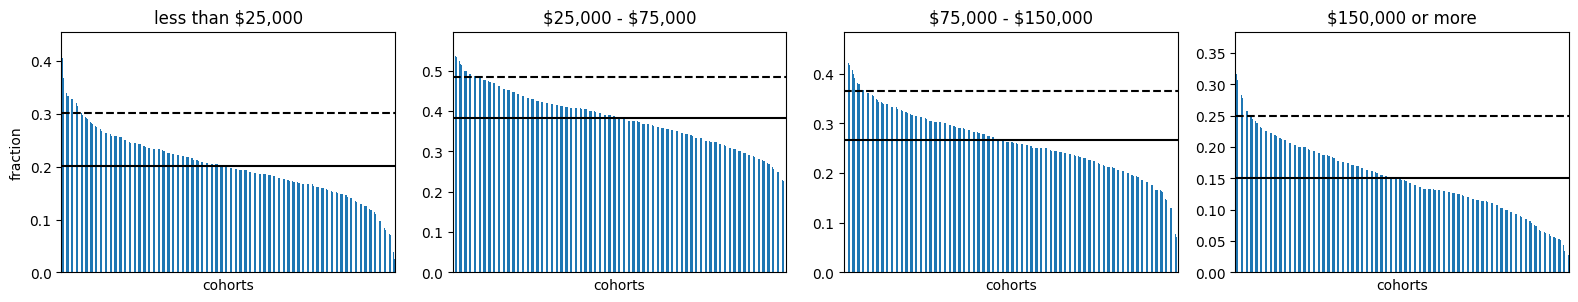

checking panel 42 with size 21745
|C| = 461 total cohorts
k = 30
|C| / k = 15.367
cohort sizes:
count    461.000000
mean      47.169197
std       13.123063
min       30.000000
25%       36.000000
50%       45.000000
75%       56.000000
max      105.000000
Name: cohort, dtype: float64


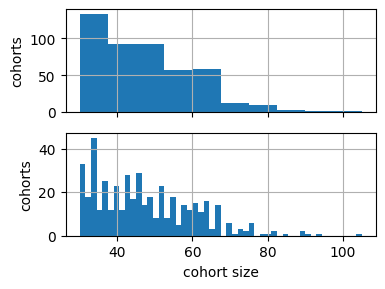

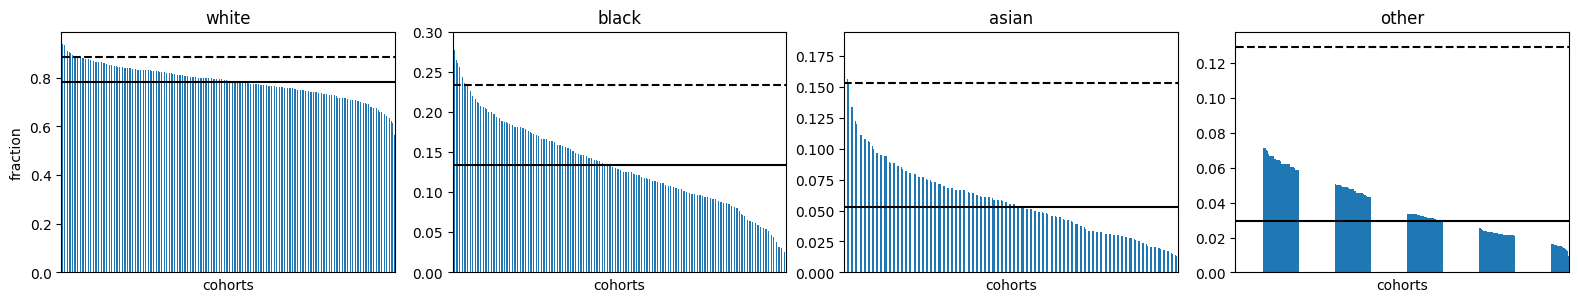

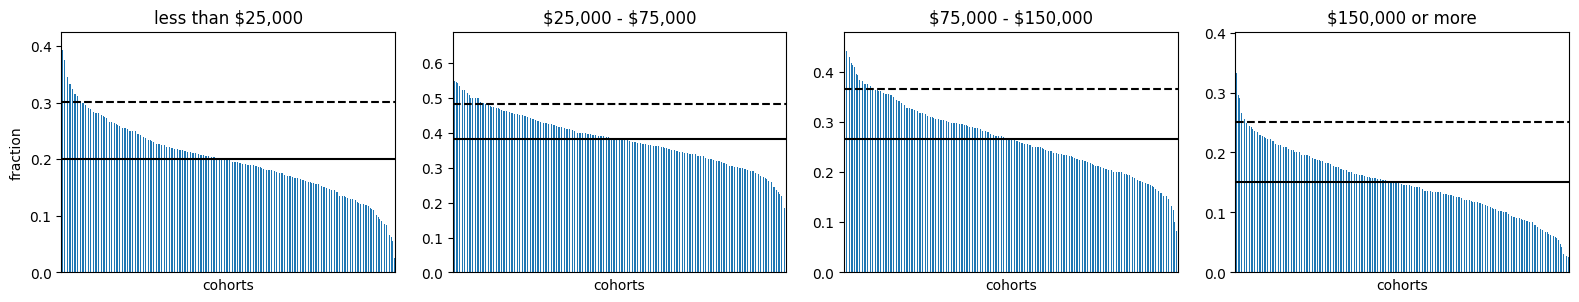

checking panel 52 with size 18286
|C| = 357 total cohorts
k = 30
|C| / k = 11.900
cohort sizes:
count    357.000000
mean      51.221289
std       14.743263
min       30.000000
25%       38.000000
50%       49.000000
75%       61.000000
max       98.000000
Name: cohort, dtype: float64


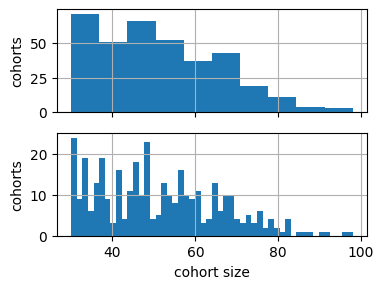

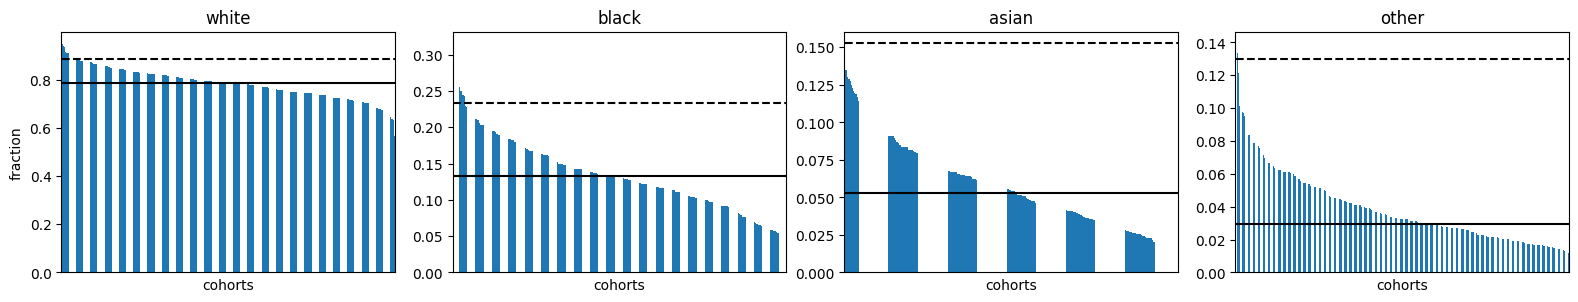

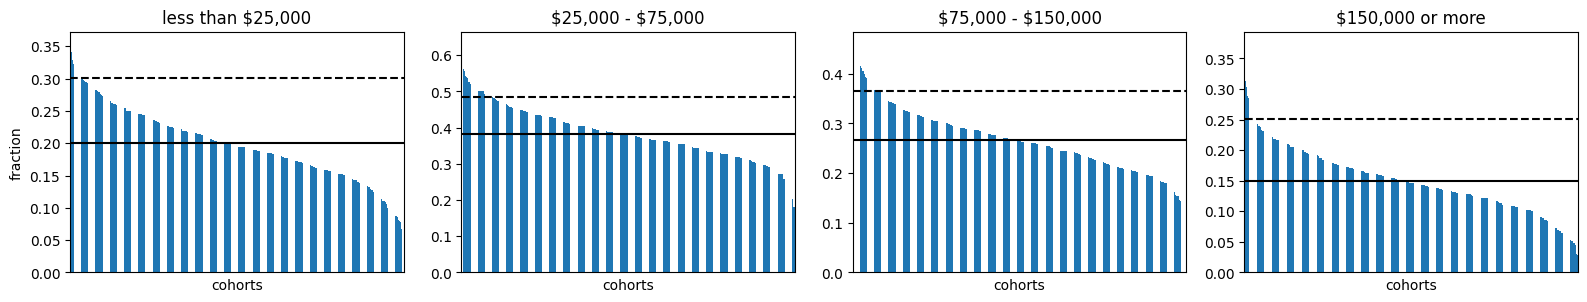


k=29 ---------------------------

checking panel 2 with size 23209
|C| = 505 total cohorts
k = 29
|C| / k = 17.414
cohort sizes:
count    505.000000
mean      45.958416
std       13.369306
min       29.000000
25%       35.000000
50%       43.000000
75%       54.000000
max      100.000000
Name: cohort, dtype: float64


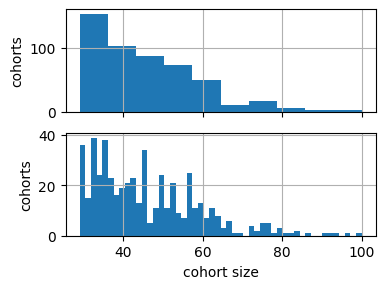

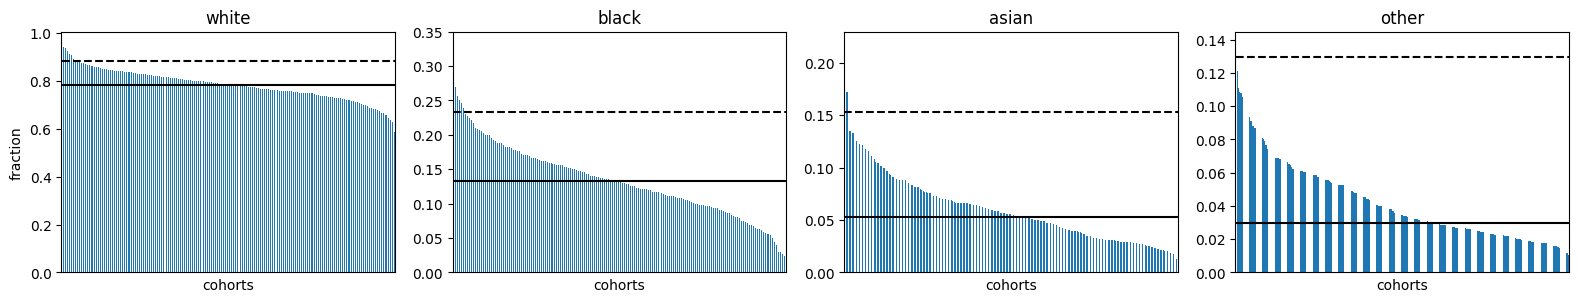

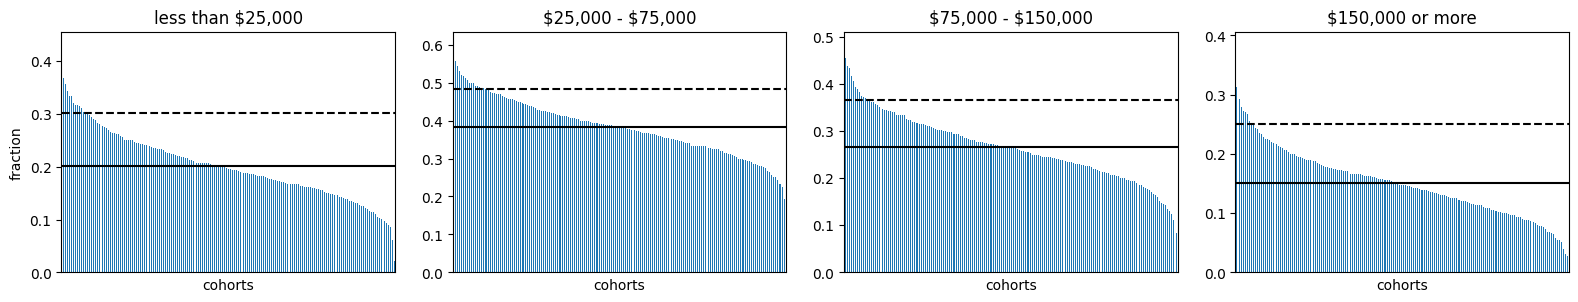

checking panel 22 with size 21768
|C| = 445 total cohorts
k = 29
|C| / k = 15.345
cohort sizes:
count    445.000000
mean      48.916854
std       14.896786
min       29.000000
25%       36.000000
50%       46.000000
75%       59.000000
max      106.000000
Name: cohort, dtype: float64


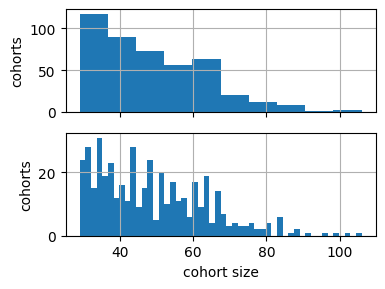

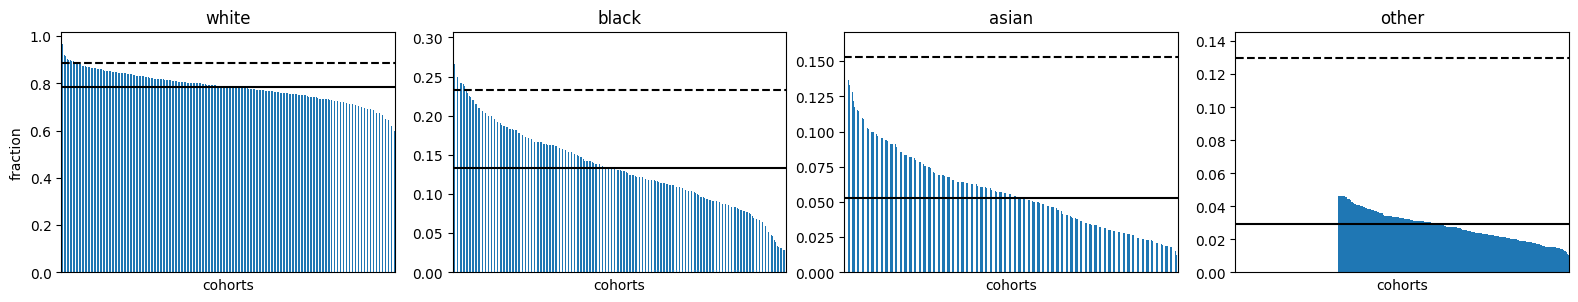

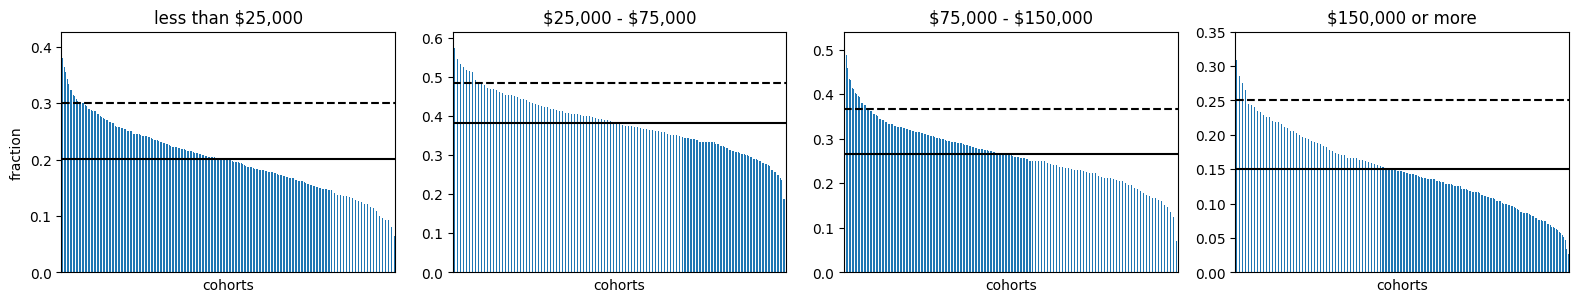

checking panel 32 with size 19579
|C| = 424 total cohorts
k = 29
|C| / k = 14.621
cohort sizes:
count    424.000000
mean      46.176887
std       13.211118
min       29.000000
25%       34.000000
50%       44.500000
75%       55.000000
max       98.000000
Name: cohort, dtype: float64


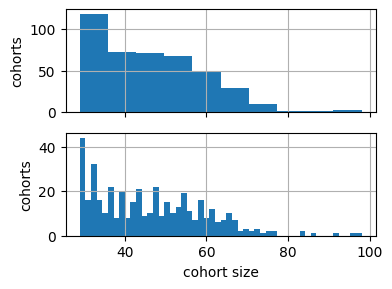

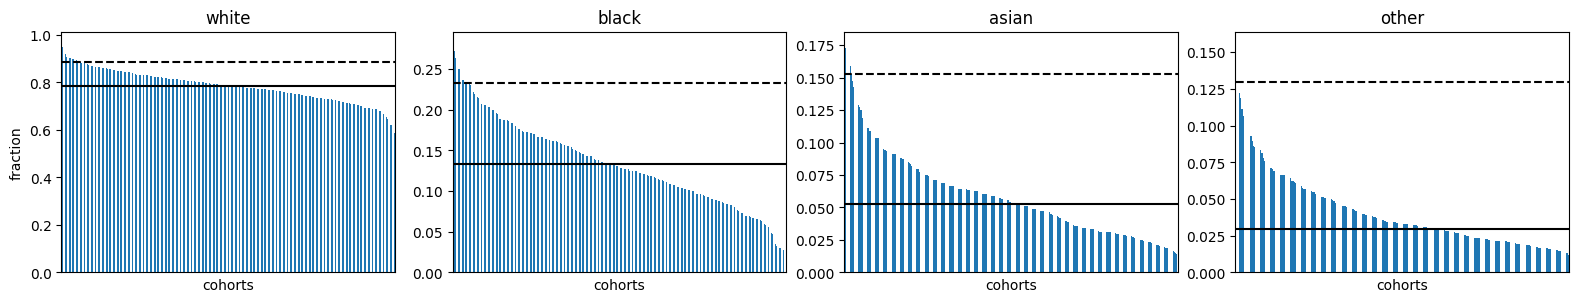

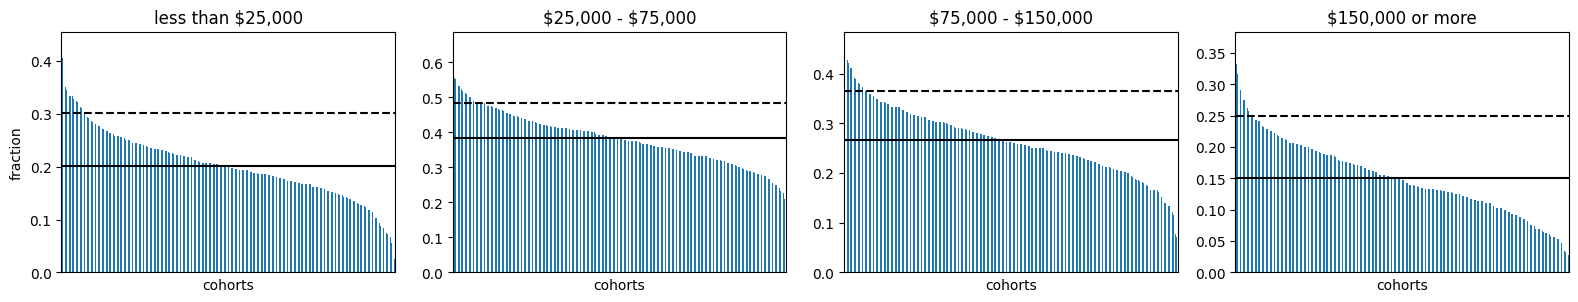

checking panel 42 with size 21745
|C| = 470 total cohorts
k = 29
|C| / k = 16.207
cohort sizes:
count    470.000000
mean      46.265957
std       12.657347
min       29.000000
25%       35.000000
50%       44.000000
75%       55.000000
max      105.000000
Name: cohort, dtype: float64


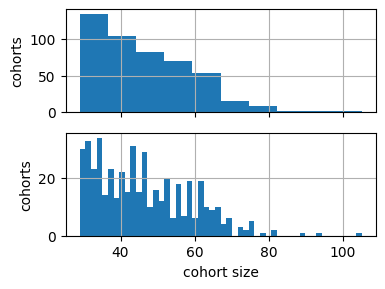

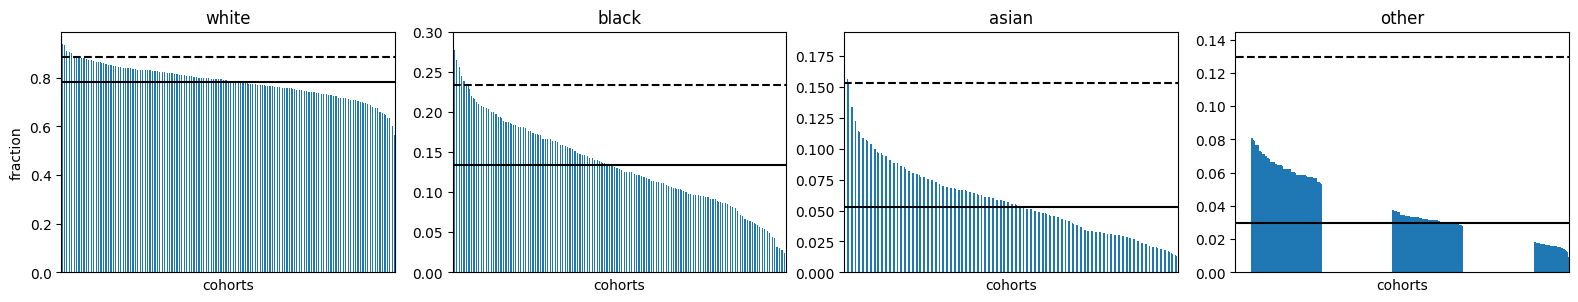

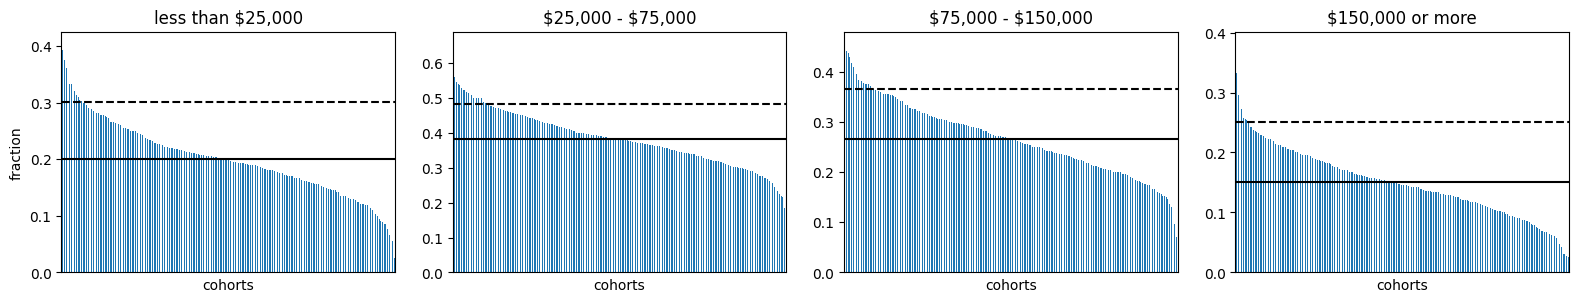

checking panel 52 with size 18286
|C| = 369 total cohorts
k = 29
|C| / k = 12.724
cohort sizes:
count    369.000000
mean      49.555556
std       14.469149
min       29.000000
25%       37.000000
50%       48.000000
75%       59.000000
max       98.000000
Name: cohort, dtype: float64


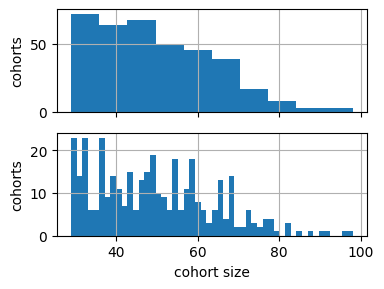

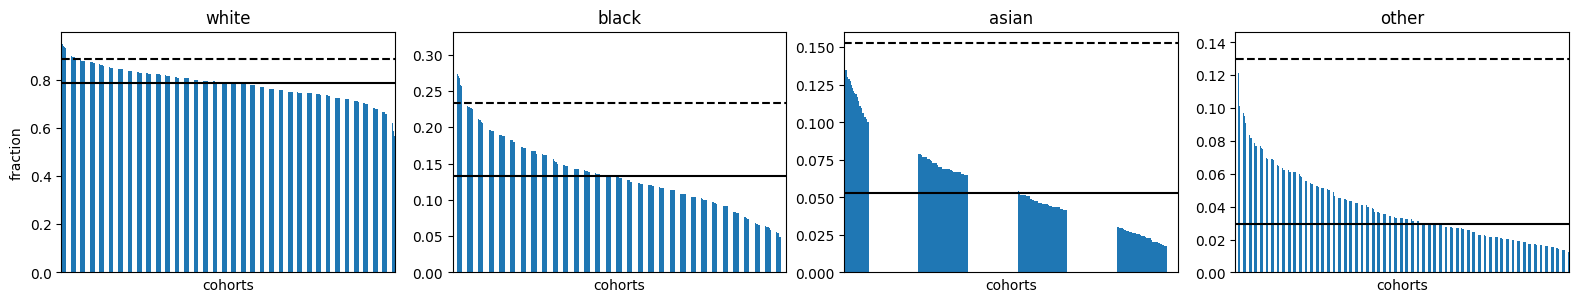

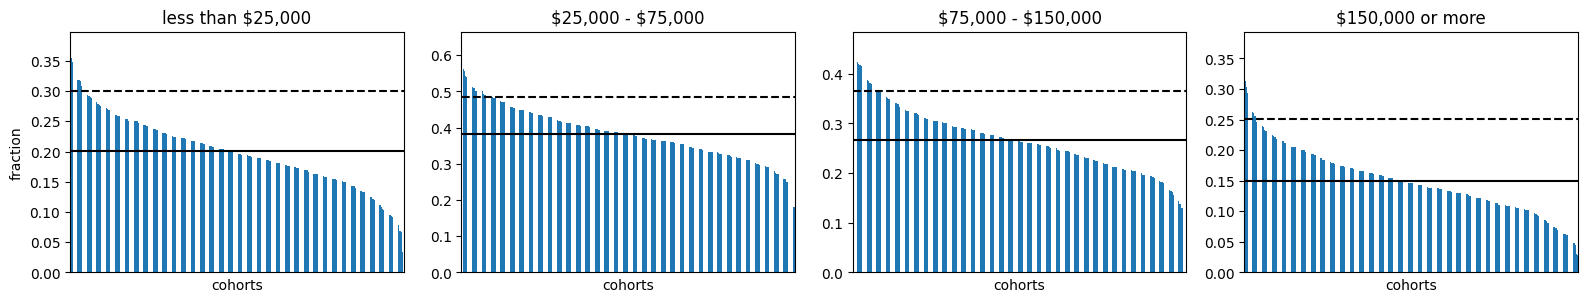


k=28 ---------------------------

checking panel 2 with size 23209
|C| = 516 total cohorts
k = 28
|C| / k = 18.429
cohort sizes:
count    516.000000
mean      44.978682
std       13.014612
min       28.000000
25%       34.000000
50%       43.000000
75%       53.000000
max      100.000000
Name: cohort, dtype: float64


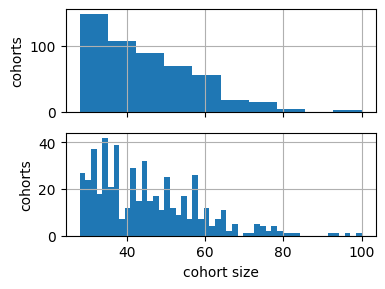

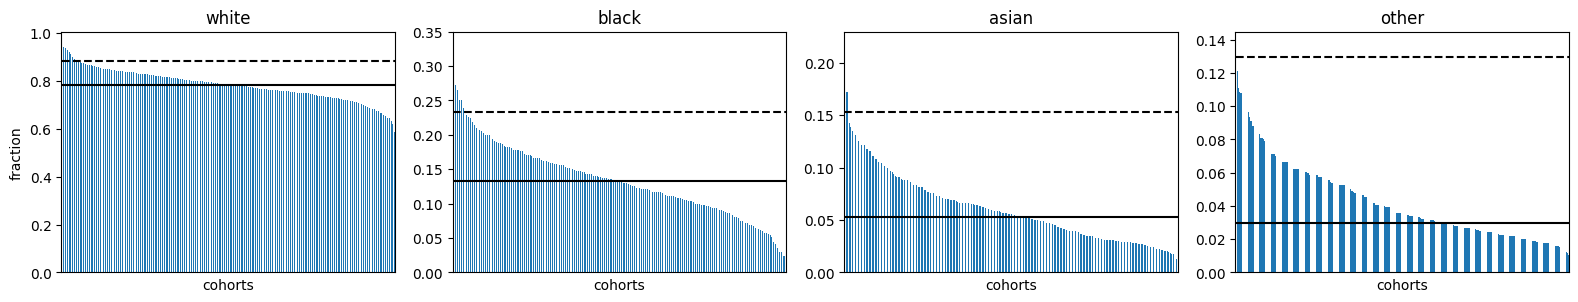

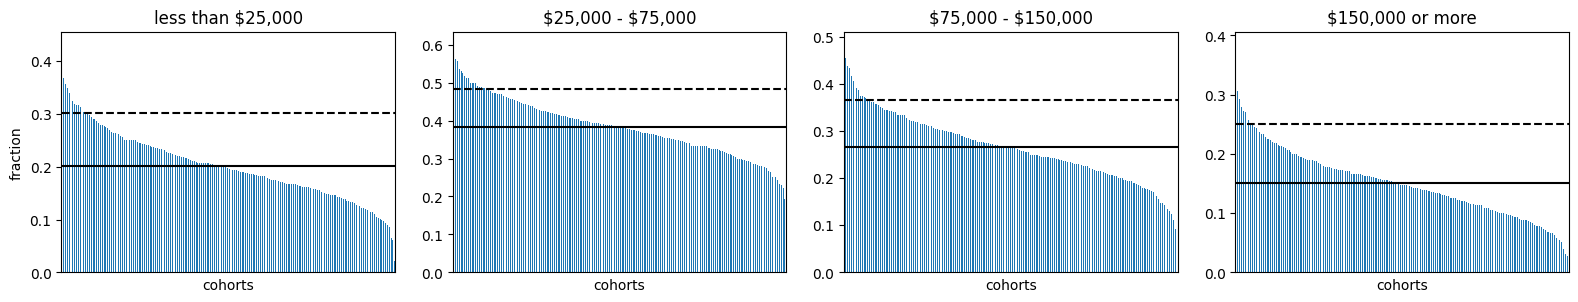

checking panel 22 with size 21768
|C| = 466 total cohorts
k = 28
|C| / k = 16.643
cohort sizes:
count    466.000000
mean      46.712446
std       14.551907
min       28.000000
25%       35.000000
50%       44.000000
75%       56.000000
max      106.000000
Name: cohort, dtype: float64


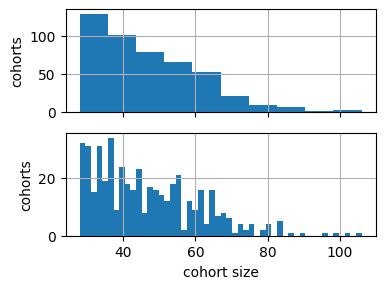

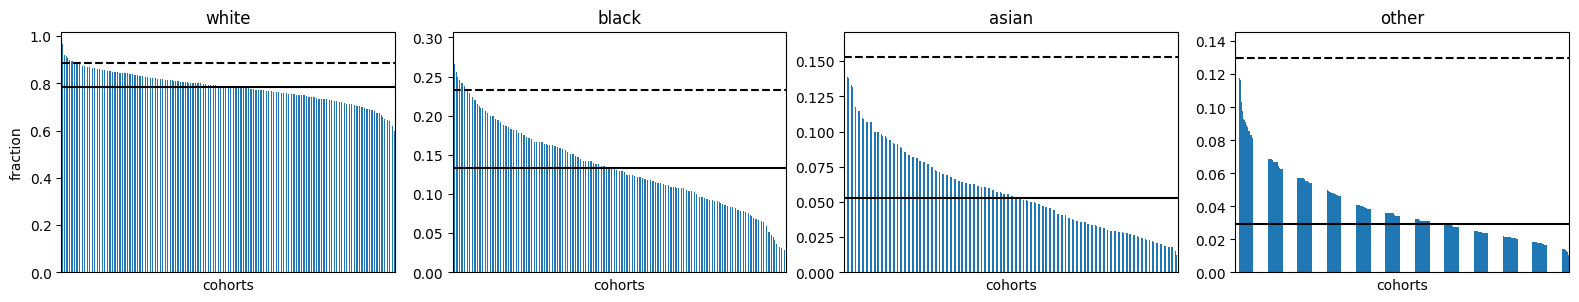

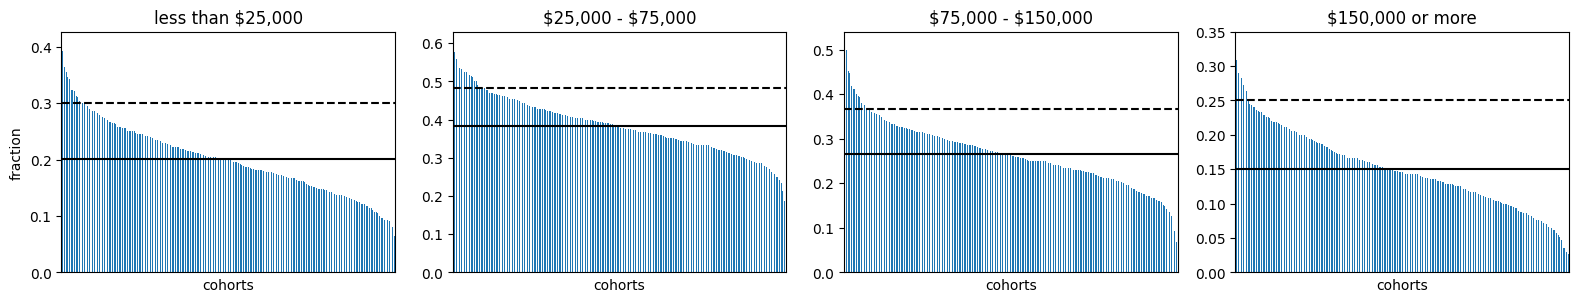

checking panel 32 with size 19579
|C| = 445 total cohorts
k = 28
|C| / k = 15.893
cohort sizes:
count    445.000000
mean      43.997753
std       12.392511
min       28.000000
25%       33.000000
50%       42.000000
75%       53.000000
max       84.000000
Name: cohort, dtype: float64


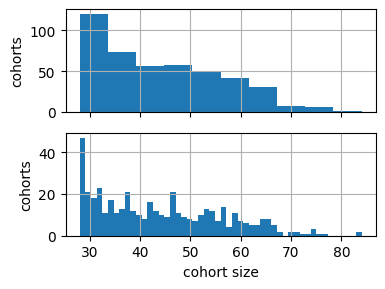

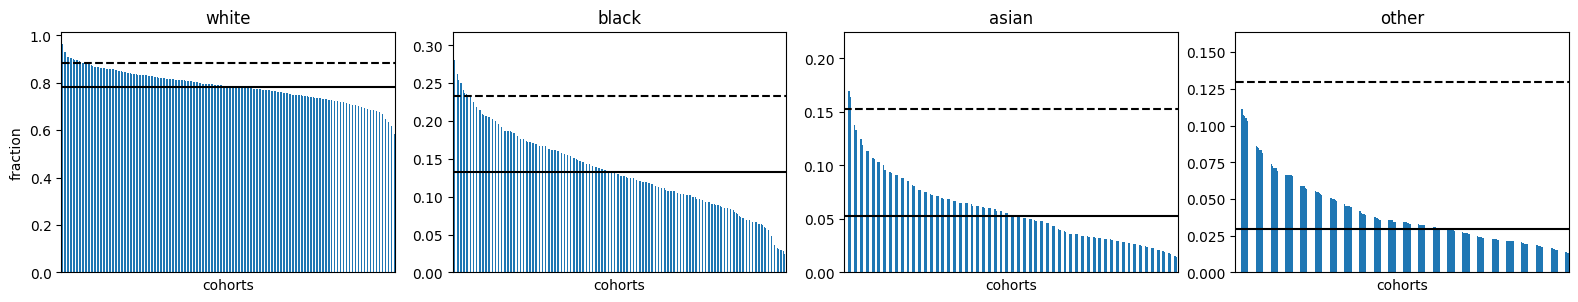

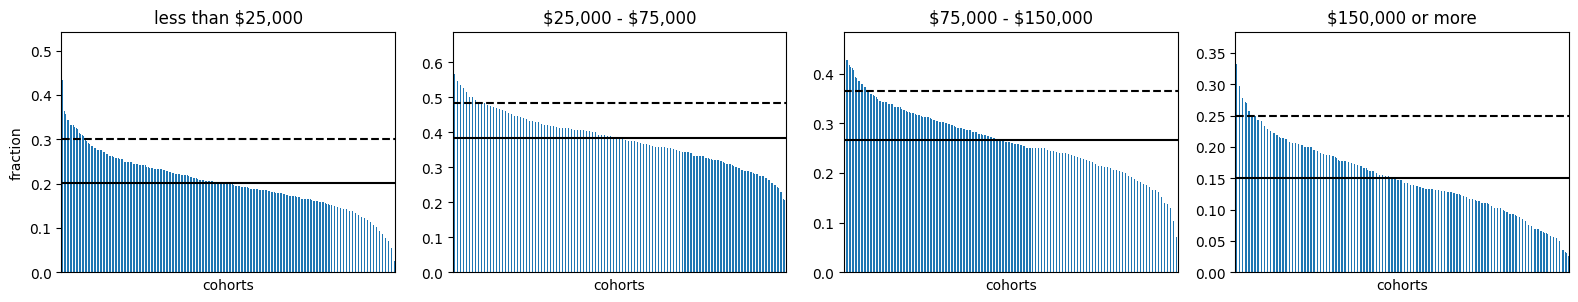

checking panel 42 with size 21745
|C| = 492 total cohorts
k = 28
|C| / k = 17.571
cohort sizes:
count    492.000000
mean      44.197154
std       11.879562
min       28.000000
25%       34.000000
50%       43.000000
75%       52.000000
max       93.000000
Name: cohort, dtype: float64


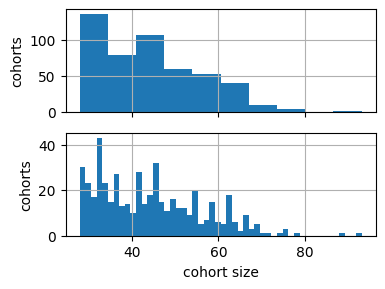

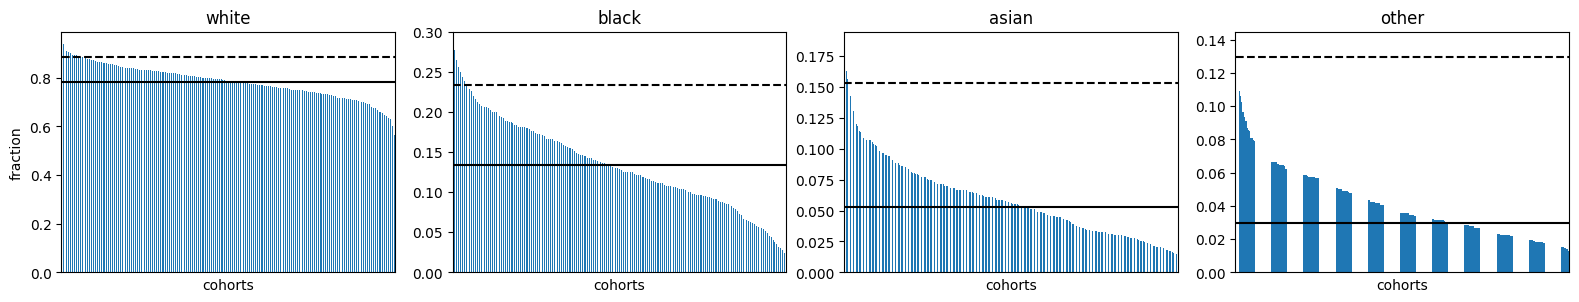

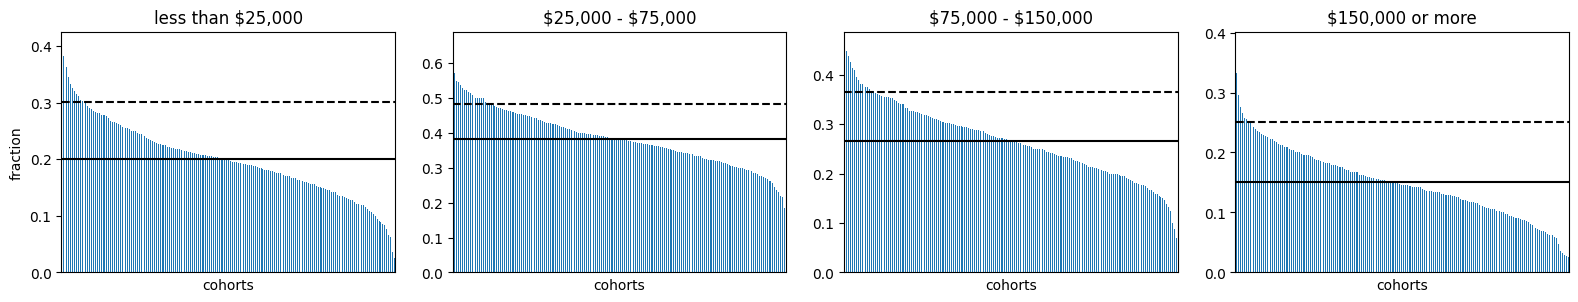

checking panel 52 with size 18286
|C| = 381 total cohorts
k = 28
|C| / k = 13.607
cohort sizes:
count    381.000000
mean      47.994751
std       14.319658
min       28.000000
25%       36.000000
50%       47.000000
75%       57.000000
max       98.000000
Name: cohort, dtype: float64


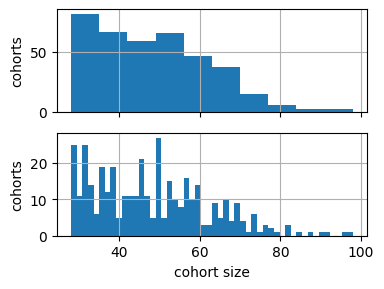

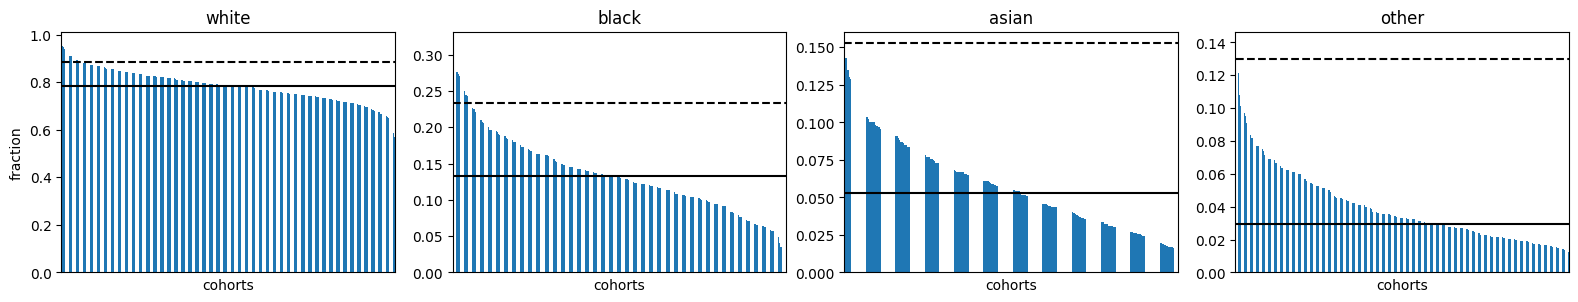

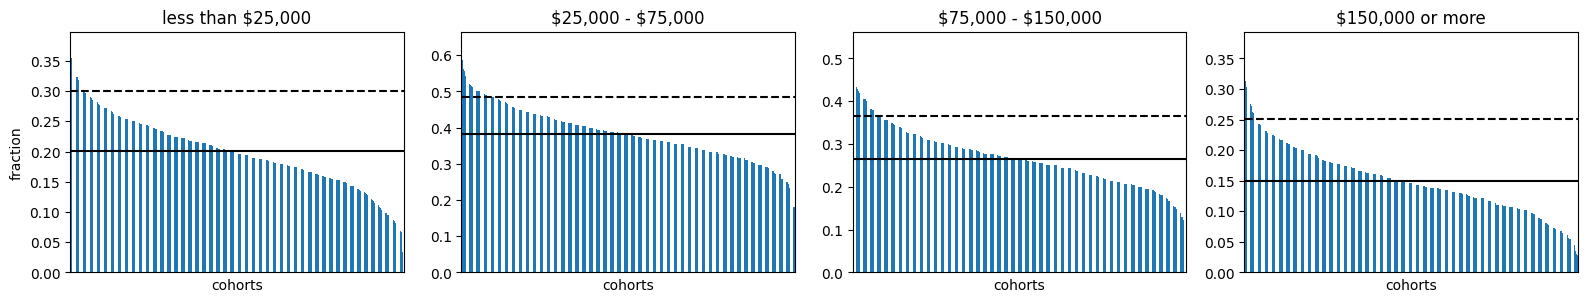

In [42]:
k_values = [2000, 1000, 500, 100, 50, 35, 32, 31, 30, 29, 28]

for k in k_values:
    print('\nk=%s ---------------------------\n' % k)
    for (panel_id, panel_df) in panels:
        print('checking panel %s with size %s' % (panel_id, len(panel_df)))
        cohorts_dict = prefixLSH.get_cohorts_dict(panel_df.simhash.astype(int), min_k=k)
        panel_df['cohort'] = panel_df.simhash.map(cohorts_dict)
        show_panel_info(panel_df, k)
    

|C| = 518 total cohorts
k = 28
|C| / k = 18.500
cohort sizes:
count    518.000000
mean      44.884170
std       13.379236
min       28.000000
25%       34.000000
50%       43.000000
75%       53.000000
max       94.000000
Name: cohort, dtype: float64


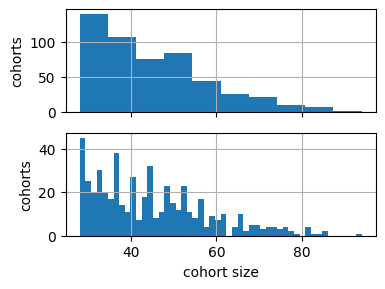

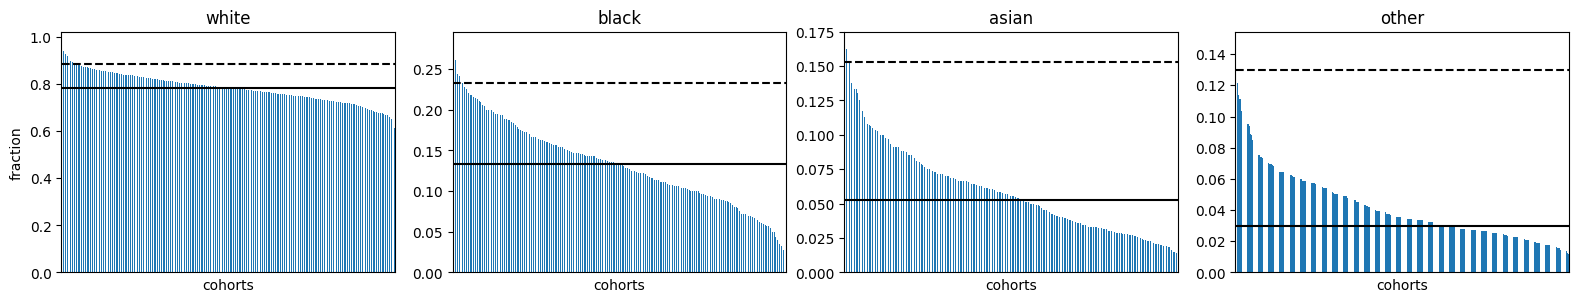

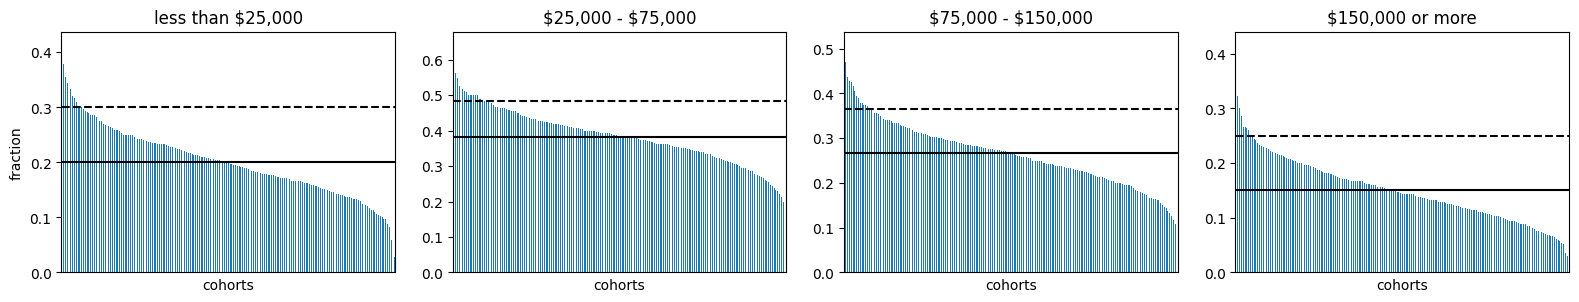

machine_id  week  n_domains  household_income  racial_background  \
0   216306561     1         33              11.0                1.0   
1   218977211     1         15              11.0                1.0   
2   227099882     1          7              11.0                1.0   
3   205507144     1          8              11.0                1.0   
4   205274490     1          7              11.0                1.0   

   collapsed_income_code stratify  panel_id       simhash  cohort  
0                      1  1.0,1.0         1  2.389685e+14      99  
1                      1  1.0,1.0         1  8.594196e+14     376  
2                      1  1.0,1.0         1  1.029867e+15     471  
3                      1  1.0,1.0         1  5.930436e+13      26  
4                      1  1.0,1.0         1  8.445503e+14     364

In [44]:
k=28
panel_1_df = all_panels_df[all_panels_df.panel_id==1].copy()
cohorts_dict = prefixLSH.get_cohorts_dict(panel_1_df.simhash.astype(int), min_k=k)
panel_1_df['cohort'] = panel_1_df.simhash.map(cohorts_dict)
show_panel_info(panel_1_df, k)
panel_1_df.head()

## Precompute cohorts

Using cohort size of k = 30 (in order to best match the OT ratio for k:|C|)

In [55]:
# computing cohort IDs for panels in parallel jobs
# since each panel's data is independent for cohort computation
# and this is slow...

from joblib import Parallel, delayed

N_JOBS = 5
k = 30

In [46]:
panel_ids = all_panels_df.panel_id.unique()

In [47]:
def assign_cohorts(panels_df, panel_id, k=k, cohort_name='cohort'):
    panel_df = panels_df[panels_df.panel_id==panel_id].copy()
    panel_df[cohort_name] = np.nan # preset all cohorts to None
    cohorts_dict = prefixLSH.get_cohorts_dict(panel_df.simhash.astype(int), min_k=k)
    assign_cohort = lambda x: cohorts_dict[x.simhash] if x.panel_id == panel_id else x[cohort_name]
    panel_df[cohort_name] = panel_df.apply(assign_cohort, axis=1)
    return panel_df

In [48]:
panel_dfs = Parallel(n_jobs=N_JOBS, verbose=True)(delayed(assign_cohorts)(
    all_panels_df, panel_id, k=k) for panel_id in panel_ids)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   26.9s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  4.1min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  4.8min finished


Check this looks okay

In [49]:
print(len(panel_dfs))

520


In [50]:
all_panels_cohort_df = pd.concat(panel_dfs)
all_panels_cohort_df.head()

machine_id  week  n_domains  household_income  racial_background  \
0   216306561     1         33              11.0                1.0   
1   218977211     1         15              11.0                1.0   
2   227099882     1          7              11.0                1.0   
3   205507144     1          8              11.0                1.0   
4   205274490     1          7              11.0                1.0   

   collapsed_income_code stratify  panel_id       simhash  cohort  
0                      1  1.0,1.0         1  2.389685e+14      92  
1                      1  1.0,1.0         1  8.594196e+14     346  
2                      1  1.0,1.0         1  1.029867e+15     435  
3                      1  1.0,1.0         1  5.930436e+13      25  
4                      1  1.0,1.0         1  8.445503e+14     334

|C| = 455 total cohorts
k = 30
|C| / k = 15.167
cohort sizes:
count    455.000000
mean      50.323077
std       15.147549
min       30.000000
25%       38.000000
50%       48.000000
75%       60.000000
max      107.000000
Name: cohort, dtype: float64


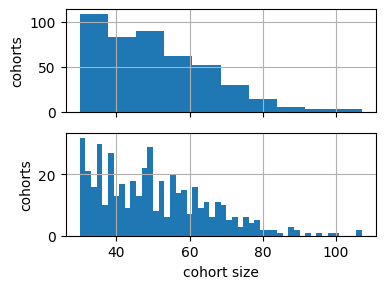

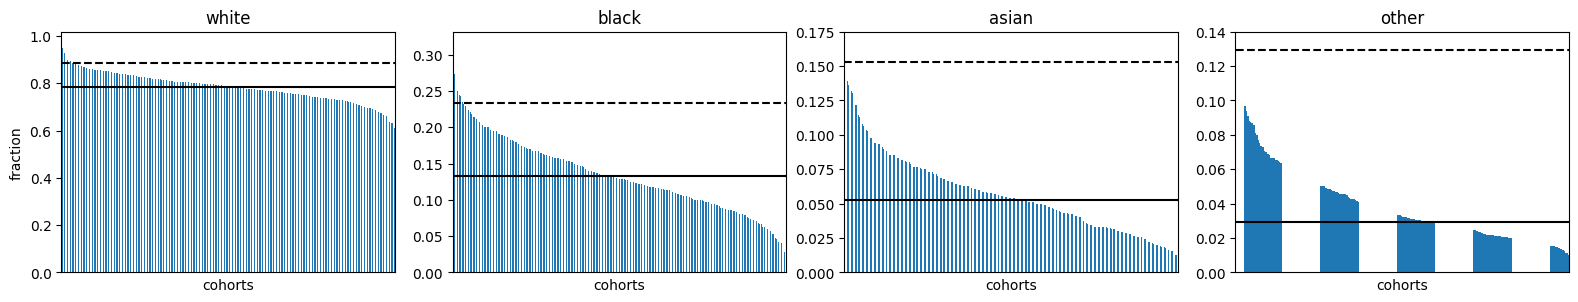

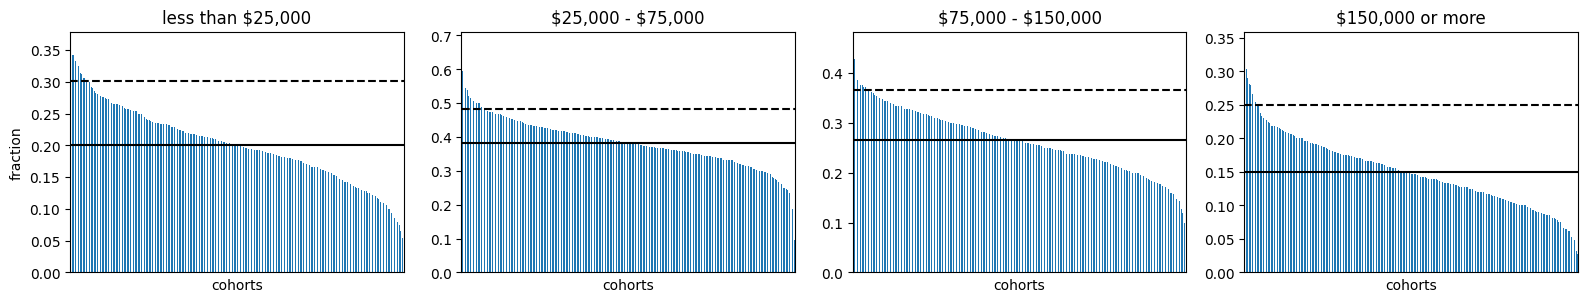

In [56]:
panel_df = all_panels_cohort_df[all_panels_cohort_df.panel_id==4]
show_panel_info(panel_df, k)

Also compute cohort IDs for other k, for experimentation later

In [57]:
# iteratively add more cohort id values for each k in new column, for each panel
k_values = [25, 30, 35, 50, 100, 1000, 2000]

for k in k_values:
    cohort_name = 'cohort_k%s'%k
    print('assigning cohorts for k=%s (%s)' % (k, cohort_name))
    panel_dfs = Parallel(n_jobs=N_JOBS, verbose=True)(delayed(assign_cohorts)(
        all_panels_cohort_df, panel_id, k=k, cohort_name=cohort_name) for panel_id in panel_ids)
    all_panels_cohort_df = pd.concat(panel_dfs)

assigning cohorts for k=25 (cohort_k25)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   26.4s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  4.0min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  4.8min finished


assigning cohorts for k=30 (cohort_k30)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   45.3s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  2.9min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  6.6min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  7.8min finished


assigning cohorts for k=35 (cohort_k35)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   53.1s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  6.8min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  7.8min finished


assigning cohorts for k=50 (cohort_k50)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   44.5s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  2.8min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  8.1min finished


assigning cohorts for k=100 (cohort_k100)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  4.7min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  9.1min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed: 10.7min finished


assigning cohorts for k=1000 (cohort_k1000)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  4.6min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  9.8min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed: 11.3min finished


assigning cohorts for k=2000 (cohort_k2000)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  3.8min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  8.8min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed: 10.6min finished


In [58]:
all_panels_cohort_df.head()

machine_id  week  n_domains  household_income  racial_background  \
0   216306561     1         33              11.0                1.0   
1   218977211     1         15              11.0                1.0   
2   227099882     1          7              11.0                1.0   
3   205507144     1          8              11.0                1.0   
4   205274490     1          7              11.0                1.0   

   collapsed_income_code stratify  panel_id       simhash  cohort  cohort_k25  \
0                      1  1.0,1.0         1  2.389685e+14      92         117   
1                      1  1.0,1.0         1  8.594196e+14     346         434   
2                      1  1.0,1.0         1  1.029867e+15     435         541   
3                      1  1.0,1.0         1  5.930436e+13      25          33   
4                      1  1.0,1.0         1  8.445503e+14     334         421   

   cohort_k30  cohort_k35  cohort_k50  cohort_k100  cohort_k1000  cohort_k2000  
0          92          80          57           32             4             2  
1         346         291         205          118            12             7  
2         435         368         254          145            15             8  
3          25          24          15            9             1             1  
4         334         284         200          115            12             7

inspecting panel id = 88

-----------
k=25

|C| = 552 total cohorts
k = 25
|C| / k = 22.080
cohort sizes:
count    552.000000
mean      39.115942
std       11.116981
min       25.000000
25%       30.000000
50%       37.000000
75%       46.000000
max       91.000000
Name: cohort_k25, dtype: float64


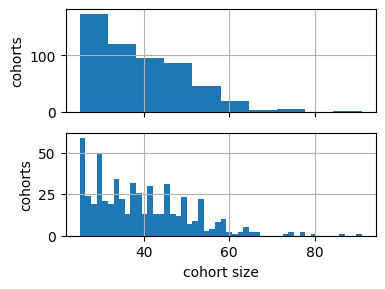

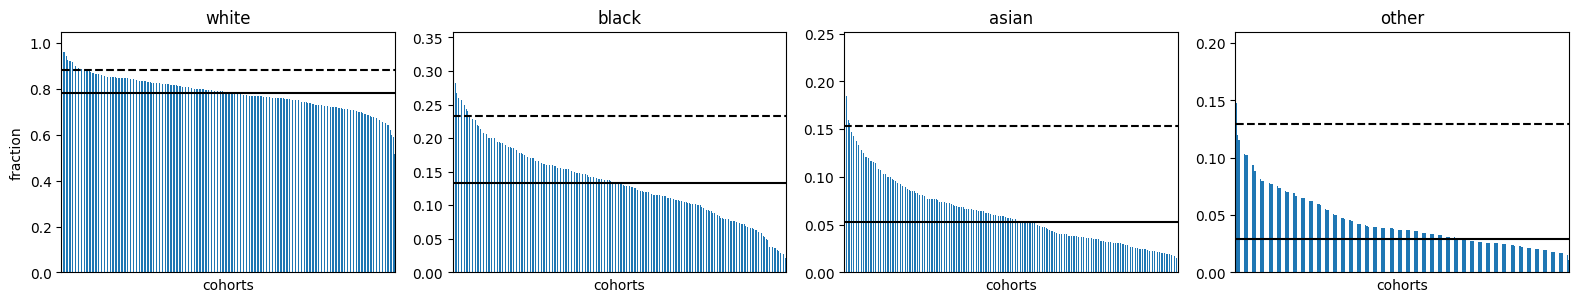

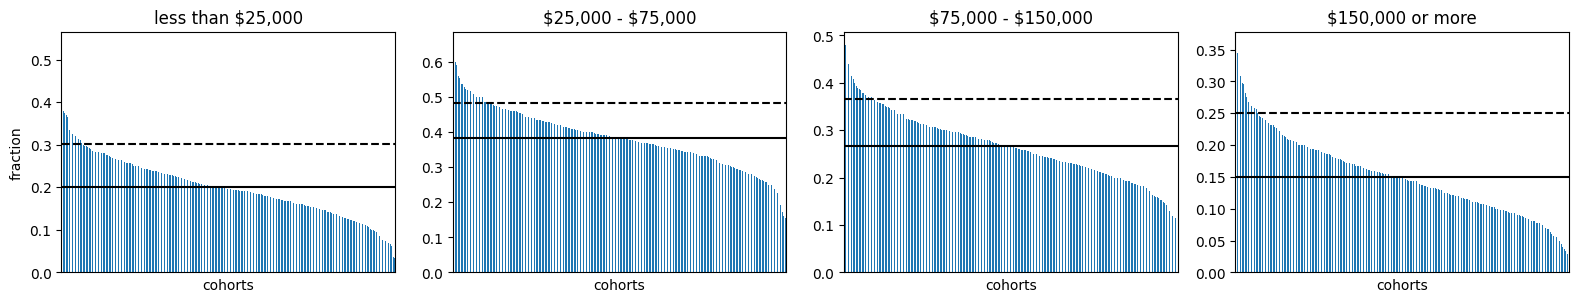


-----------
k=30

|C| = 444 total cohorts
k = 30
|C| / k = 14.800
cohort sizes:
count    444.000000
mean      48.630631
std       14.440305
min       30.000000
25%       37.000000
50%       46.000000
75%       57.000000
max      113.000000
Name: cohort_k30, dtype: float64


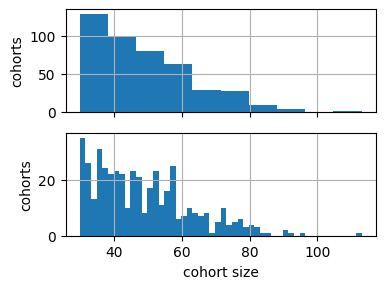

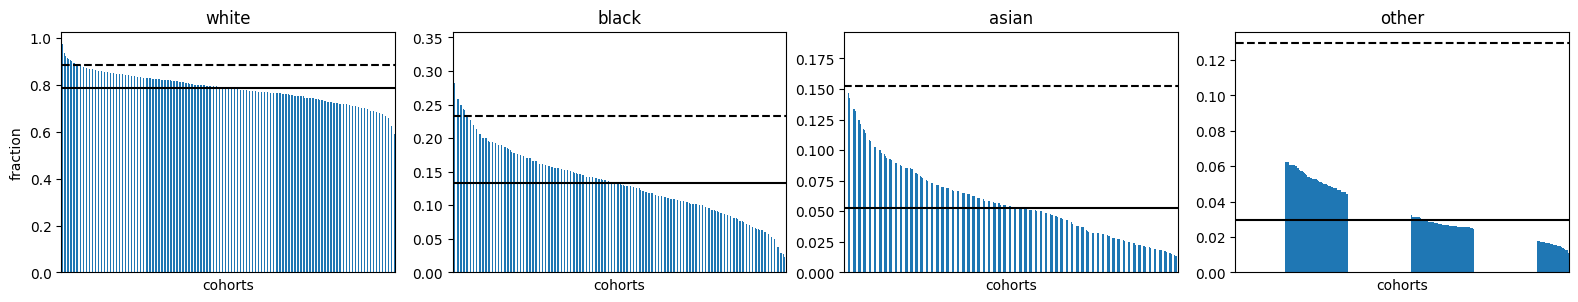

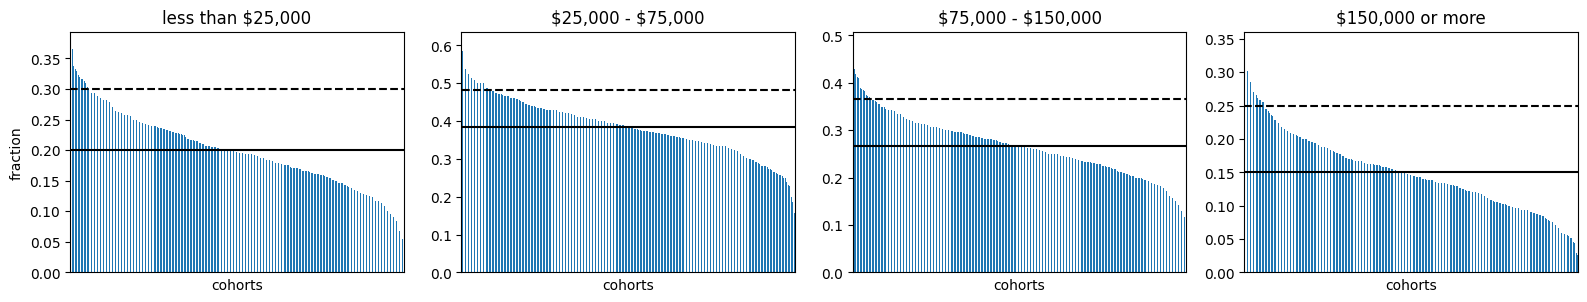


-----------
k=35

|C| = 376 total cohorts
k = 35
|C| / k = 10.743
cohort sizes:
count    376.000000
mean      57.425532
std       16.541980
min       35.000000
25%       43.000000
50%       54.500000
75%       70.000000
max      113.000000
Name: cohort_k35, dtype: float64


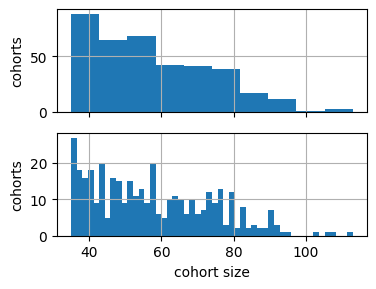

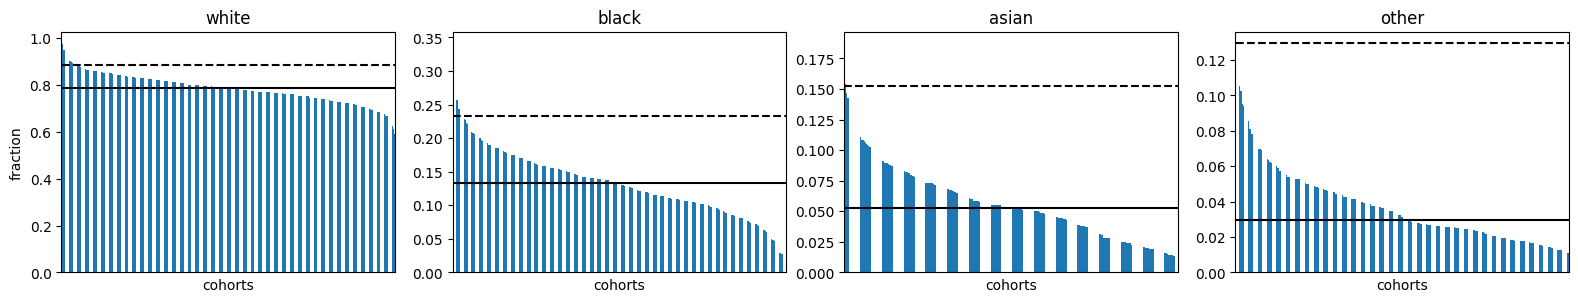

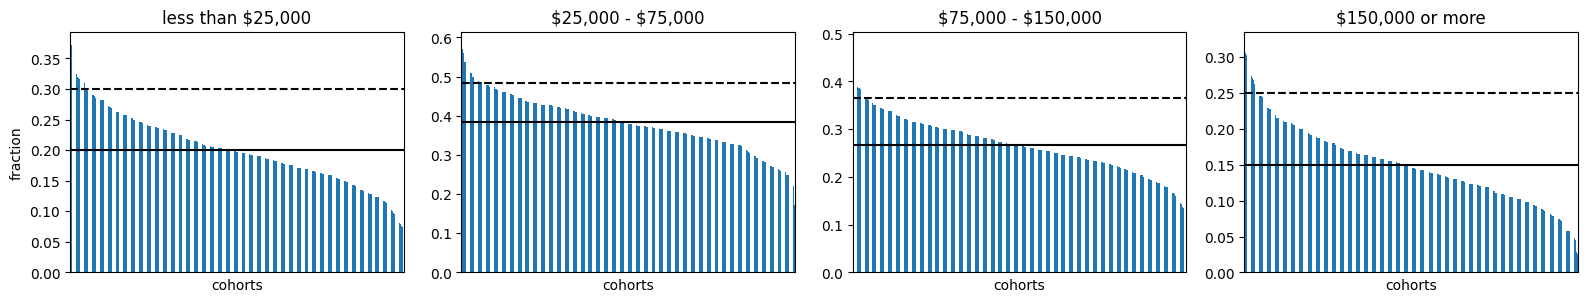


-----------
k=50

|C| = 262 total cohorts
k = 50
|C| / k = 5.240
cohort sizes:
count    262.000000
mean      82.412214
std       22.010924
min       50.000000
25%       66.250000
50%       79.000000
75%       94.000000
max      156.000000
Name: cohort_k50, dtype: float64


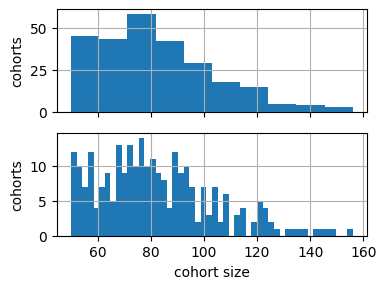

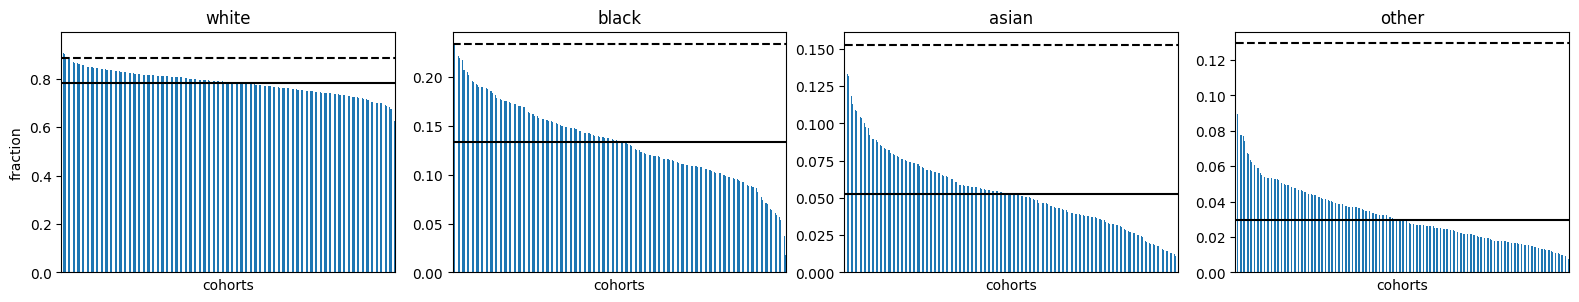

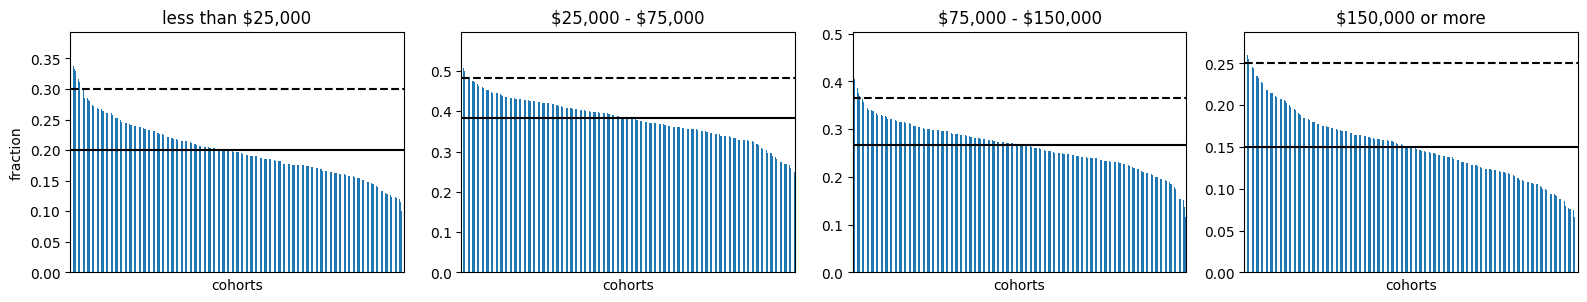


-----------
k=100

|C| = 142 total cohorts
k = 100
|C| / k = 1.420
cohort sizes:
count    142.000000
mean     152.056338
std       32.093121
min      100.000000
25%      125.000000
50%      147.500000
75%      173.750000
max      248.000000
Name: cohort_k100, dtype: float64


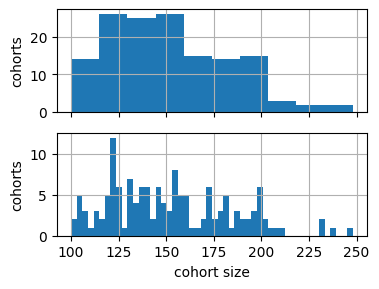

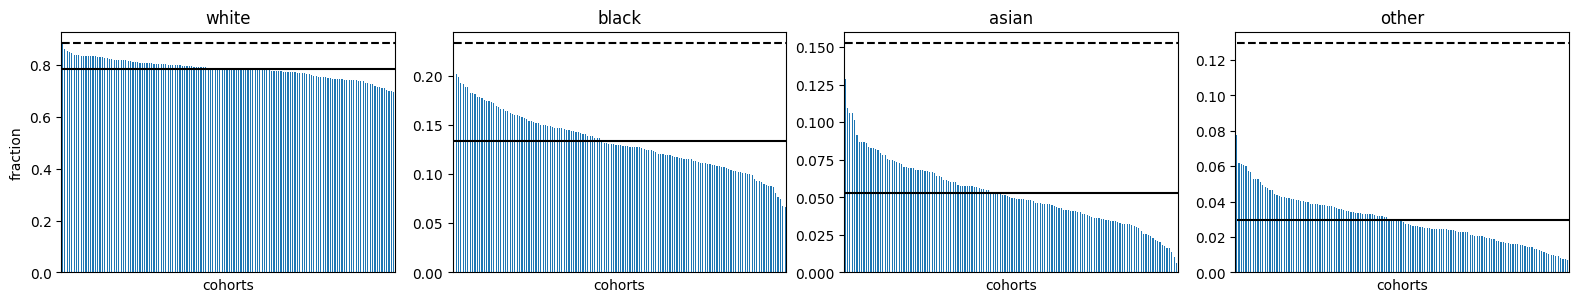

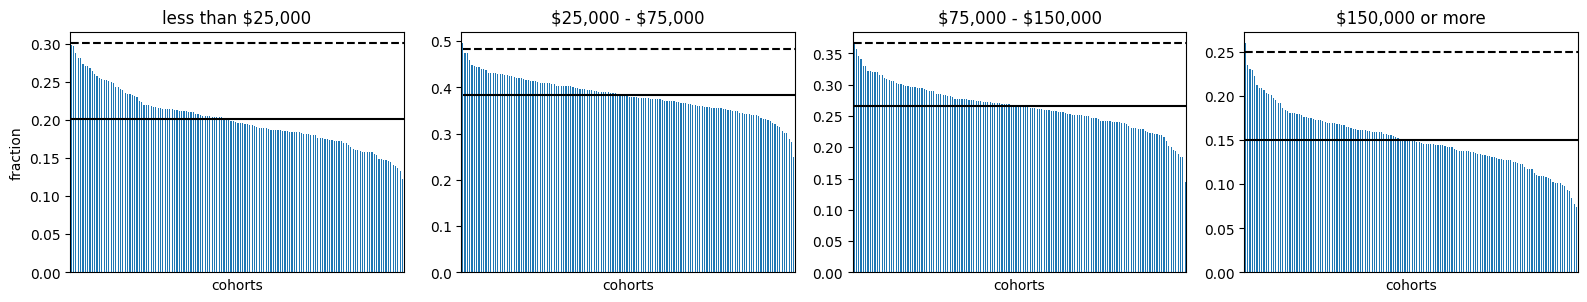


-----------
k=1000

|C| = 12 total cohorts
k = 1000
|C| / k = 0.012
cohort sizes:
count      12.000000
mean     1799.333333
std       476.781889
min      1160.000000
25%      1228.750000
50%      1963.500000
75%      2119.000000
max      2480.000000
Name: cohort_k1000, dtype: float64


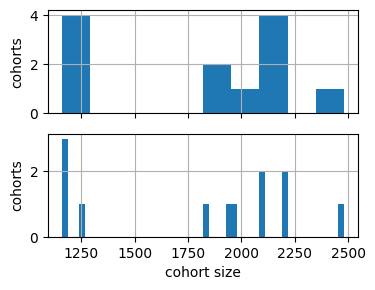

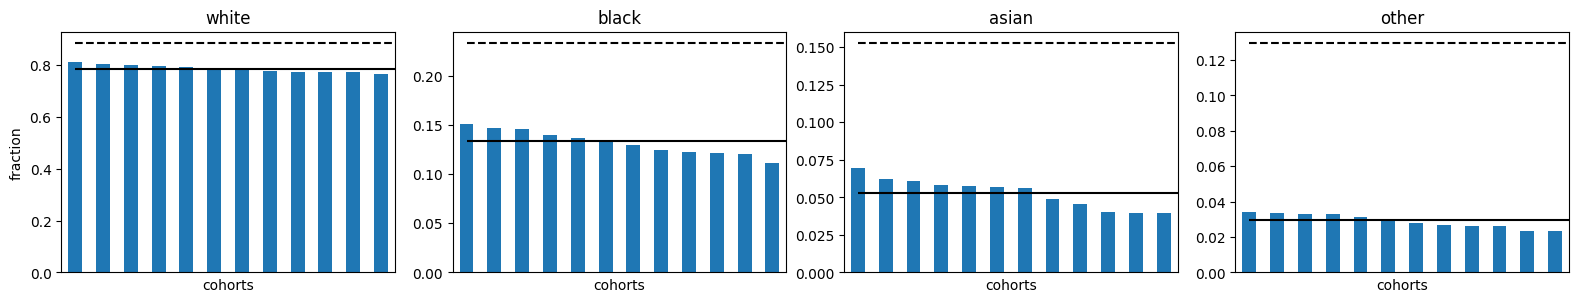

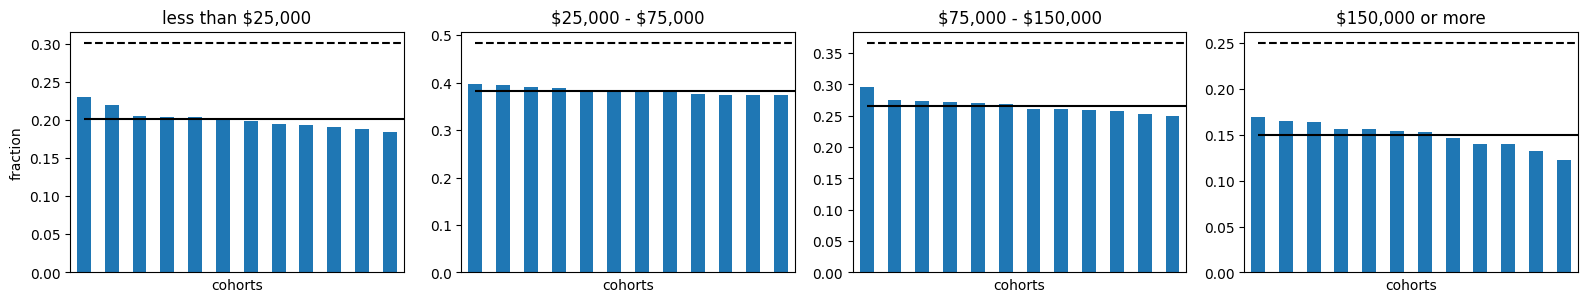


-----------
k=2000

|C| = 8 total cohorts
k = 2000
|C| / k = 0.004
cohort sizes:
count       8.000000
mean     2699.000000
std       540.494747
min      2084.000000
25%      2175.000000
50%      2746.000000
75%      3168.500000
max      3368.000000
Name: cohort_k2000, dtype: float64


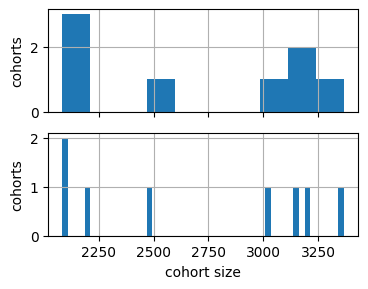

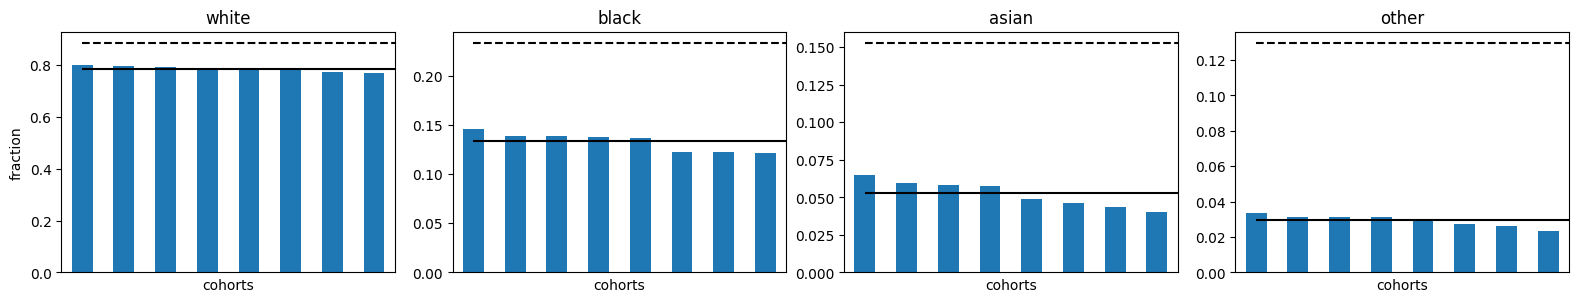

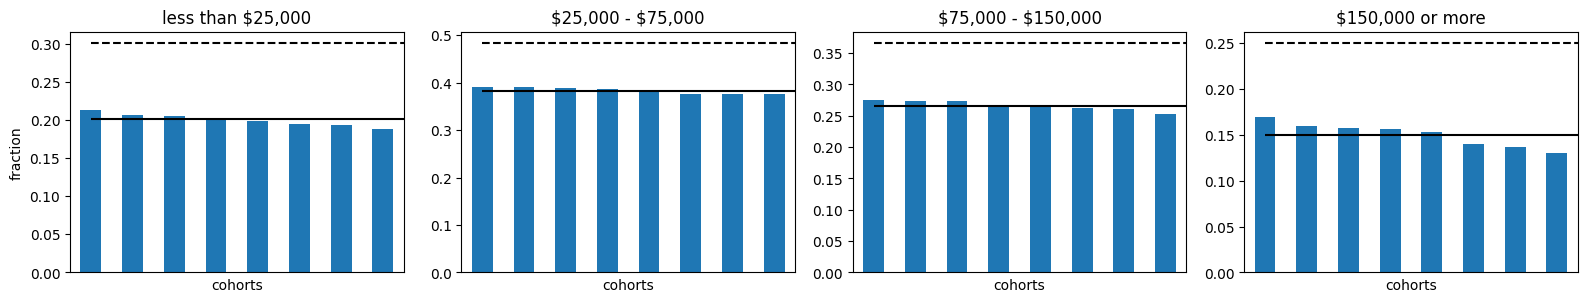

In [59]:
# sanity check we did this right.

random.seed('FLoC')

# choose some random panel id
panel_id = random.choice(panel_ids)
print('inspecting panel id = %s' % panel_id)
panel_df = all_panels_cohort_df[all_panels_cohort_df.panel_id==panel_id]

for k in k_values:
    print('\n-----------\nk=%s\n' % k)
    cohort_name = 'cohort_k%s'%k
    show_panel_info(panel_df, k, cohort_name=cohort_name)


### save cohorts output

In [60]:
panels_cohorts_fpath = '../output/comscore_cps_income_race_panels_cohorts.csv'

In [61]:
print('saving to %s...' % panels_cohorts_fpath)
all_panels_cohort_df.to_csv(panels_cohorts_fpath, index=False)

saving to ../output/comscore_cps_income_race_panels_cohorts.csv...


In [67]:
# script re-entry
all_panels_cohort_df = pd.read_csv(panels_cohorts_fpath)
all_panels_cohort_df.head()

machine_id  week  n_domains  household_income  racial_background  \
0   216306561     1         33              11.0                1.0   
1   218977211     1         15              11.0                1.0   
2   227099882     1          7              11.0                1.0   
3   205507144     1          8              11.0                1.0   
4   205274490     1          7              11.0                1.0   

   collapsed_income_code stratify  panel_id       simhash  cohort  cohort_k25  \
0                      1  1.0,1.0         1  2.389685e+14      92         117   
1                      1  1.0,1.0         1  8.594196e+14     346         434   
2                      1  1.0,1.0         1  1.029867e+15     435         541   
3                      1  1.0,1.0         1  5.930436e+13      25          33   
4                      1  1.0,1.0         1  8.445503e+14     334         421   

   cohort_k30  cohort_k35  cohort_k50  cohort_k100  cohort_k1000  cohort_k2000  
0          92          80          57           32             4             2  
1         346         291         205          118            12             7  
2         435         368         254          145            15             8  
3          25          24          15            9             1             1  
4         334         284         200          115            12             7

---

## Comparison FLoC assignments

Here we create a comparison/counterfactual to the true panel data.

The same machine_ids for panels are used as for the true data, but where only the sample's demographics are kept.

#### *Note / Update: Method 2 below is what we use.

Code for Method 1 is kept for posterity.

### Method 1: Randomly assigned domains

The visited sets of domains are randomly assigned to panel samples, but where domains are assigned in a way proportional to how they occur in the real panel data.

With this creation, domain visits and therefore cohorts should not be correlated with demographics.


Here's how we do this:

- first take the real panel data, where panel samples are joined with their true sessions data, and data is then limited to samples with >= 7 domains per sample.

- take the distribution of n_domains 

- take the distribution of domains, using each domain's frequency of occurance in the real samples.
i.e. when domains are randomly sampled, their sampling weight is proportional to the number of samples for which they occur in the real panel data.

Create data where
- each machine,week sample from the real panel is assigned a set of domains by randomly sampling from the distribution of n_domains and the distribution of domains
- simhash and cohorts are computed and assigned as the same way for the true panel data.

---

Read in the sessions data and join with the panel data as and make the distributions to randomly sample the fake panel data from:
- n_domains distribution
- domains distribution

In [26]:
# read in the pre-processed sessions data 
# this maps week,machine_id -> domains set
weeks_machines_domains_fpath = '../output/weeks_machines_domains.csv'
weeks_machines_domains_df = read_weeks_machines_domains(weeks_machines_domains_fpath)
weeks_machines_domains_df.drop(['machine_id', 'domains'], axis=1).head()

reading from ../output/weeks_machines_domains.csv...
... read 4877236 rows


week  n_domains
0     1        104
1     1          0
2     1         20
3     1         49
4     1         64

Read in the panels data (again) and repeat the steps above.

In [ ]:
all_panels_df = pd.read_csv(panels_cohorts_fpath)
print('read in all panels: %s total rows' % len(all_panels_df))
print('%s panels' % all_panels_df.panel_id.nunique())

all_panels_df['domains'] = all_panels_df.set_index(
    ['machine_id','week']
).index.map(weeks_machines_domains_df.set_index(['machine_id','week'])['domains'])

all_panels_df.drop(['machine_id', 'domains'], axis=1).head()

In [28]:
n_domains_distribution = all_panels_df.n_domains

# make a list of all domains where the frequency they appear in the list
# is the same as the frequency which they appear in the panel samples
# weekly domains sets
domains_sets = all_panels_df.domains.to_list()
domains = [d for domain_set in domains_sets for d in domain_set]
# check this matches the n_domains distribution data
assert(len(domains) == n_domains_distribution.sum())

In [29]:
# transform that list into the map: {domain: frequency}
domains_distribution_map = {d: 0 for d in set(domains)}
print('%s unique domains' % len(domains_distribution_map))
for d in domains:
    domains_distribution_map[d] += 1
# and then trandform this into 2 series:
# domains_list has an item for each domain
# and domains_p is a list of corresponding the probabilities (weights) 
# for each domain in domains_p where the indices match
domains_list = list(domains_distribution_map.keys())
domains_p = [v/len(domains) for v in domains_distribution_map.values()]
assert(round((sum(domains_p)), 4) == 1)

4324794 unique domains


In [30]:
random.seed(0)

def get_random_domains_set(x):
    n_domains = random.choice(n_domains_distribution)
    return set(random.sample(
        domains,
        k=n_domains,
    ))

Create alternative version of panel by copying true panel and reassigning domains using computed distributions.

In [ ]:
all_panels_random_domains_df = all_panels_df.copy().drop(
    ['n_domains', 'domains'], axis=1
)
all_panels_random_domains_df.head()

In [ ]:
# how long will this take?
print('%s total samples across panels' % len(all_panels_random_domains_df))

# how long with just N samples?
N = 100000
start_time = datetime.now()
N_all_panels_random_domains_df = all_panels_random_domains_df.head(N).copy()
N_all_panels_random_domains_df['domains'] = N_all_panels_random_domains_df.apply(get_random_domains_set, axis=1)
N_all_panels_random_domains_df['n_domains'] = N_all_panels_random_domains_df.domains.apply(len)
end_time = datetime.now()
time = end_time - start_time
print('took %s for %s samples' % (time, N))
N_all_panels_random_domains_df.head()

In [33]:
# how many minutes will this take?
s = 65
print('how many minutes might this take for the entire set of samples?')
len(all_panels_random_domains_df)/N * (s/60) # took about so many seconds with N

how many minutes might this take for the entire set of samples?


136.16135

In [34]:
all_panels_random_domains_df['domains'] = all_panels_random_domains_df.apply(get_random_domains_set, axis=1)
all_panels_random_domains_df['n_domains'] = all_panels_random_domains_df.domains.apply(len)
all_panels_random_domains_df.head()

machine_id  week  racial_background  stratify  panel_id  \
0   216368766     1                1.0         1         1   
1   225562713     1                1.0         1         1   
2   193448730     1                1.0         1         1   
3   216306558     1                1.0         1         1   
4   223440886     1                1.0         1         1   

                                             domains  n_domains  
0  {usedprice.com, thespringsla.com, costco.com, ...         65  
1  {ojrq.net, youtube.com, mercurynews.com, goodf...         18  
2  {nbcunicareers.com, nnerenmls.com, messenger.c...         33  
3  {adblockplus.org, homestead.com, parcalpharett...          7  
4  {twitter.com, intuit.com, theantimedia.org, ga...         12

Compute simhash on domains sets

In [ ]:
# how long might this take?
start_time = datetime.now()
N_all_panels_random_domains_df['simhash'] = N_all_panels_random_domains_df.domains.apply(floc.hashes.sim_hash_string)
end_time = datetime.now()
time = end_time - start_time
print('took %s for %s samples' % (time, N))
N_all_panels_random_domains_df.head()

In [36]:
# how many minutes will this take?
s = 43
print('how many minutes might this take for the entire set of samples?')
len(all_panels_random_domains_df)/N * (s/60) # took about so many seconds with N

how many minutes might this take for the entire set of samples?


90.07597

In [ ]:
# apply simhash (expect >90 mins to run)
start_t = datetime.now()
all_panels_random_domains_df['simhash'] = all_panels_random_domains_df.domains.apply(floc.hashes.sim_hash_string)
print('time to compute simhash for all samples:  %s' % (datetime.now() - start_t))
all_panels_random_domains_df.head()

### Compute cohorts for each panel

Use the same k values as for the real data and then compare. The comparison is a sanity check, not analysis. Analysis is later.

In [41]:
k = 32

# panel_ids = all_panels_random_domains_df.panel_id.unique() <-- already set above for real data

panel_dfs = Parallel(n_jobs=N_JOBS, verbose=True)(delayed(assign_cohorts)(
    all_panels_random_domains_df, panel_id, k=k) for panel_id in panel_ids)

all_panels_random_domains_cohort_df = pd.concat(panel_dfs)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   12.8s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   46.8s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  1.9min finished


In [ ]:
# Also compute cohort IDs for other k, for experimentation later
for k in k_values: # set above
    cohort_name = 'cohort_k%s'%k
    print('assigning cohorts for k=%s (%s)' % (k, cohort_name))
    panel_dfs = Parallel(n_jobs=N_JOBS, verbose=True)(delayed(assign_cohorts)(
        all_panels_random_domains_cohort_df, panel_id, k=k, cohort_name=cohort_name
    ) for panel_id in panel_ids)
    all_panels_random_domains_cohort_df = pd.concat(panel_dfs)

Compare values to true data

In [ ]:
# sanity check we did this right.
# choose some random panel id
panel_id = random.choice(panel_ids)
print('inspecting panel id = %s' % panel_id)
panel_df = all_panels_random_domains_cohort_df[
    (all_panels_random_domains_cohort_df.panel_id==panel_id)
]
for k in k_values:
    print('\n-----------\nk=%s\n' % k)
    cohort_name = 'cohort_k%s'%k
    show_panel_info(panel_df, cohort_name=cohort_name)

#### Panel size comparison: Evaluate how well the randomly assigned domains data represents true data

w.r.t. size

This is important because the distribution of how many cohorts violate t-closeness is dependent on cohort size.

### Panel size comparison

Make a table for visual and correlation analysis:

```
panel_id, panel_size, avg_cohort_size, avg_random_domains_cohort_size
```

In [81]:
def compare_panel_cohort_sizes(true_df, other_df, 
                               other_avg_cohort_size_name):
    """
    Returns a dataframe with columns
    panel_id, panel_size, avg_cohort_size, other_avg_cohort_size_name
    
    where:
        - the input dfs have same panel ids but different 
        cohort assignments
        - avg_cohort_size, other_avg_cohort_size_name represent 
        mean cohort size for given panel_id
    """
    panel_sizes = true_df.groupby(
        'panel_id'
    ).size().rename('panel_size').to_frame()
    panel_sizes['avg_cohort_size'] = true_df.groupby(
        ['panel_id', 'cohort']
    ).size().rename('size').reset_index().groupby(
        ['panel_id']
    ).agg({'size': [np.mean]})
    panel_sizes[other_avg_cohort_size_name] = other_df.groupby(
        ['panel_id', 'cohort']
    ).size().rename('size').reset_index().groupby(
        ['panel_id']
    ).agg({'size': [np.mean]})
    return panel_sizes

In [9]:
other_avg_cohort_size_name = 'avg_random_domains_cohort_size'

panel_sizes = compare_panel_cohort_sizes(
    all_panels_cohort_df, all_panels_random_domains_cohort_df, 
    other_avg_cohort_size_name)
panel_sizes.head()

panel_size  avg_cohort_size  avg_random_domains_cohort_size
panel_id                                                             
1              25900        51.696607                       49.521989
2              26334        51.736739                       49.130597
3              27719        51.331481                       49.060177
4              25943        51.989980                       48.856874
5              27334        50.431734                       48.550622

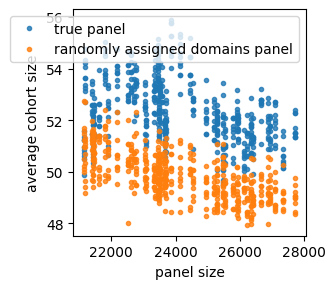

In [26]:
# plot the compared panel cohort sizes

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=100)
panel_sizes_sorted = panel_sizes.sort_values('panel_size')
ax.plot(
    panel_sizes_sorted['panel_size'],
    panel_sizes_sorted['avg_cohort_size'], '.', 
    alpha=0.8,
    label='true panel'
)
ax.plot(
    panel_sizes_sorted['panel_size'],
    panel_sizes_sorted[other_avg_cohort_size_name], '.',
    alpha=0.8,
    label='randomly assigned domains panel'
)
ax.set_ylabel('average cohort size')
ax.set_xlabel('panel size')
_ = ax.legend()

Clearly the randomly assigned domains data does not well represent the true data.

We need an alternative method.

Below we instead simply randomly shuffle the simhash values among the panel.

## Method 2: Randomly shuffled simhashes

Steps to make this alternative cohorts assignment data:
1. copy the real panels and simhash data
2. randomly shuffle the simhash values across the samples
3. compute cohorts

In [63]:
# script re-entry read in the data if needed
panels_cohorts_fpath = '../output/comscore_cps_income_race_panels_cohorts.csv'
all_panels_cohort_df = pd.read_csv(panels_cohorts_fpath)

In [68]:
all_panels_cohort_df.head()

machine_id  week  n_domains  household_income  racial_background  \
0   216306561     1         33              11.0                1.0   
1   218977211     1         15              11.0                1.0   
2   227099882     1          7              11.0                1.0   
3   205507144     1          8              11.0                1.0   
4   205274490     1          7              11.0                1.0   

   collapsed_income_code stratify  panel_id       simhash  cohort  cohort_k25  \
0                      1  1.0,1.0         1  2.389685e+14      92         117   
1                      1  1.0,1.0         1  8.594196e+14     346         434   
2                      1  1.0,1.0         1  1.029867e+15     435         541   
3                      1  1.0,1.0         1  5.930436e+13      25          33   
4                      1  1.0,1.0         1  8.445503e+14     334         421   

   cohort_k30  cohort_k35  cohort_k50  cohort_k100  cohort_k1000  cohort_k2000  
0          92          80          57           32             4             2  
1         346         291         205          118            12             7  
2         435         368         254          145            15             8  
3          25          24          15            9             1             1  
4         334         284         200          115            12             7

In [70]:
all_panels_randomly_shuffled_simhash_cohorts_df = all_panels_cohort_df[[
    'machine_id', 'week', 'panel_id', 'collapsed_income_code', 'racial_background', 'stratify', 'simhash'
]].copy()
all_panels_randomly_shuffled_simhash_cohorts_df.head()

machine_id  week  panel_id  collapsed_income_code  racial_background  \
0   216306561     1         1                      1                1.0   
1   218977211     1         1                      1                1.0   
2   227099882     1         1                      1                1.0   
3   205507144     1         1                      1                1.0   
4   205274490     1         1                      1                1.0   

  stratify       simhash  
0  1.0,1.0  2.389685e+14  
1  1.0,1.0  8.594196e+14  
2  1.0,1.0  1.029867e+15  
3  1.0,1.0  5.930436e+13  
4  1.0,1.0  8.445503e+14

Randomly shuffle the simhash values

In [71]:
random.seed(0)

simhash_values = all_panels_randomly_shuffled_simhash_cohorts_df.simhash.values
random.shuffle(simhash_values)
all_panels_randomly_shuffled_simhash_cohorts_df.simhash = simhash_values
all_panels_randomly_shuffled_simhash_cohorts_df.head()

machine_id  week  panel_id  collapsed_income_code  racial_background  \
0   216306561     1         1                      1                1.0   
1   218977211     1         1                      1                1.0   
2   227099882     1         1                      1                1.0   
3   205507144     1         1                      1                1.0   
4   205274490     1         1                      1                1.0   

  stratify       simhash  
0  1.0,1.0  6.874264e+14  
1  1.0,1.0  6.822101e+14  
2  1.0,1.0  1.873246e+14  
3  1.0,1.0  7.253560e+14  
4  1.0,1.0  1.039863e+15

Assign cohorts

In [72]:
k = 30

panel_ids = all_panels_randomly_shuffled_simhash_cohorts_df.panel_id.unique() #<-- already set above for real data

panel_dfs = Parallel(n_jobs=N_JOBS, verbose=True)(delayed(assign_cohorts)(
    all_panels_randomly_shuffled_simhash_cohorts_df, panel_id, k=k
) for panel_id in panel_ids)

all_panels_randomly_shuffled_simhash_cohorts_df = pd.concat(panel_dfs)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   24.1s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  4.1min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  4.8min finished


In [73]:
# Also compute cohort IDs for other k, for experimentation later
# add another column for each k, iteratively
print(k_values)
for k in k_values: #  <-- already set above
    cohort_name = 'cohort_k%s'%k
    print('assigning cohorts for k=%s (%s)' % (k, cohort_name))
    panel_dfs = Parallel(n_jobs=N_JOBS, verbose=True)(delayed(assign_cohorts)(
        all_panels_randomly_shuffled_simhash_cohorts_df, panel_id, k=k, cohort_name=cohort_name
    ) for panel_id in panel_ids)
    all_panels_randomly_shuffled_simhash_cohorts_df = pd.concat(panel_dfs)

[25, 30, 35, 50, 100, 1000, 2000]
assigning cohorts for k=25 (cohort_k25)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   39.6s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  2.7min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  5.8min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  6.8min finished


assigning cohorts for k=30 (cohort_k30)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   36.6s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  2.9min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  6.3min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  7.4min finished


assigning cohorts for k=35 (cohort_k35)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   44.0s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  2.9min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  7.5min finished


assigning cohorts for k=50 (cohort_k50)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   40.0s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  2.8min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  6.1min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  7.2min finished


assigning cohorts for k=100 (cohort_k100)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   41.3s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  2.9min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  6.4min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  7.6min finished


assigning cohorts for k=1000 (cohort_k1000)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   48.2s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  2.8min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  6.3min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  7.4min finished


assigning cohorts for k=2000 (cohort_k2000)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   50.6s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  3.0min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  6.7min
[Parallel(n_jobs=5)]: Done 520 out of 520 | elapsed:  8.0min finished


In [5]:
all_panels_randomly_shuffled_simhash_cohorts_df.head()

machine_id  week  panel_id  collapsed_income_code  racial_background  \
0   216306561     1         1                      1                1.0   
1   218977211     1         1                      1                1.0   
2   227099882     1         1                      1                1.0   
3   205507144     1         1                      1                1.0   
4   205274490     1         1                      1                1.0   

  stratify       simhash  cohort  cohort_k25  cohort_k30  cohort_k35  \
0  1.0,1.0  6.874264e+14     256         313         256         220   
1  1.0,1.0  6.822101e+14     253         310         253         217   
2  1.0,1.0  1.873246e+14      73          90          73          61   
3  1.0,1.0  7.253560e+14     277         339         277         235   
4  1.0,1.0  1.039863e+15     445         545         445         378   

   cohort_k50  cohort_k100  cohort_k1000  cohort_k2000  
0         151           83             7             5  
1         150           82             7             5  
2          44           23             2             2  
3         163           89             8             6  
4         258          140            14             8

### Save output to file

In [6]:
all_panels_randomly_shuffled_simhash_cohorts_fpath = \
    '../output/comscore_cps_income_race_panels_randomly_shuffled_simhash_cohorts.csv'

In [7]:
print('saving to %s...' % all_panels_randomly_shuffled_simhash_cohorts_fpath)
all_panels_randomly_shuffled_simhash_cohorts_df.to_csv(
    all_panels_randomly_shuffled_simhash_cohorts_fpath, 
    index=False)
print('...saved')

saving to ../output/comscore_cps_income_race_panels_randomly_shuffled_simhash_cohorts.csv...
...saved


Inspect

inspecting panel id = 148

-----------
k=25

|C| = 534 total cohorts
k = 25
|C| / k = 21.360
cohort sizes:
count    534.000000
mean      39.822097
std       11.187813
min       25.000000
25%       31.000000
50%       38.000000
75%       46.000000
max       94.000000
Name: cohort_k25, dtype: float64


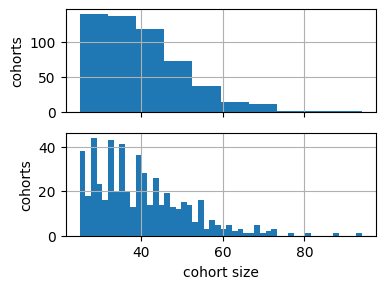

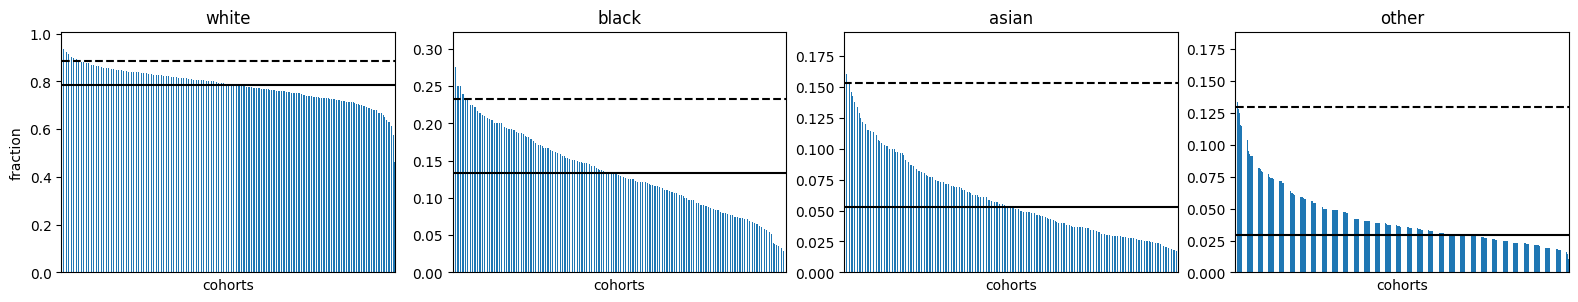

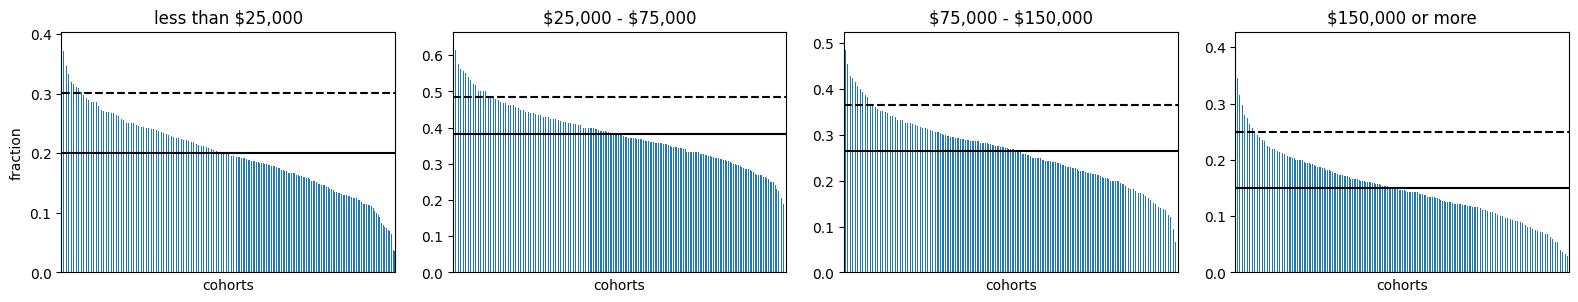


-----------
k=30

|C| = 439 total cohorts
k = 30
|C| / k = 14.633
cohort sizes:
count    439.000000
mean      48.439636
std       14.728917
min       30.000000
25%       37.000000
50%       45.000000
75%       57.000000
max      107.000000
Name: cohort_k30, dtype: float64


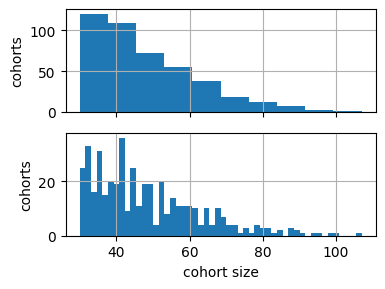

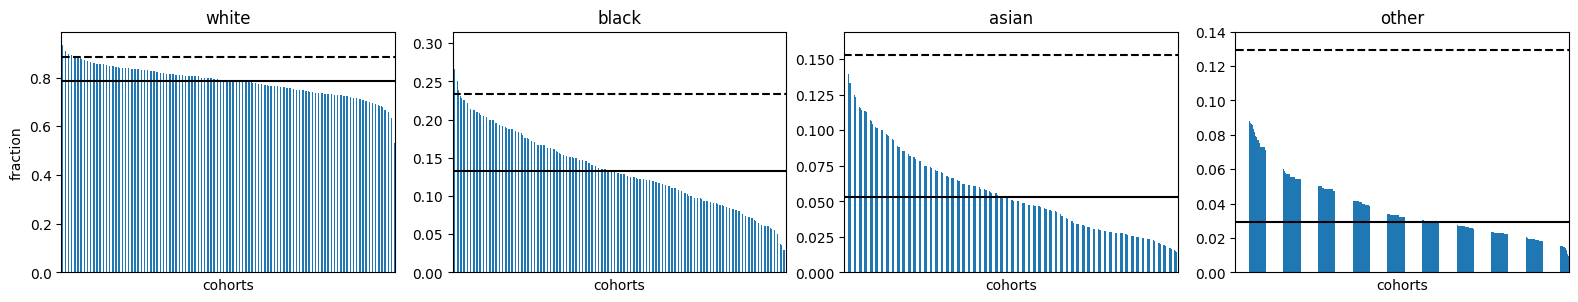

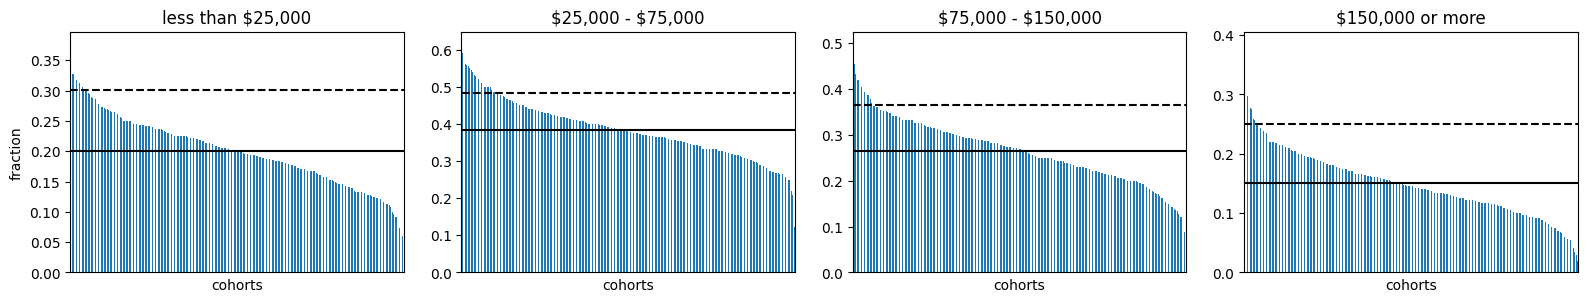


-----------
k=35

|C| = 370 total cohorts
k = 35
|C| / k = 10.571
cohort sizes:
count    370.000000
mean      57.472973
std       16.902737
min       35.000000
25%       43.000000
50%       55.000000
75%       69.000000
max      113.000000
Name: cohort_k35, dtype: float64


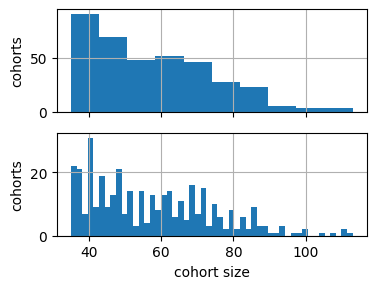

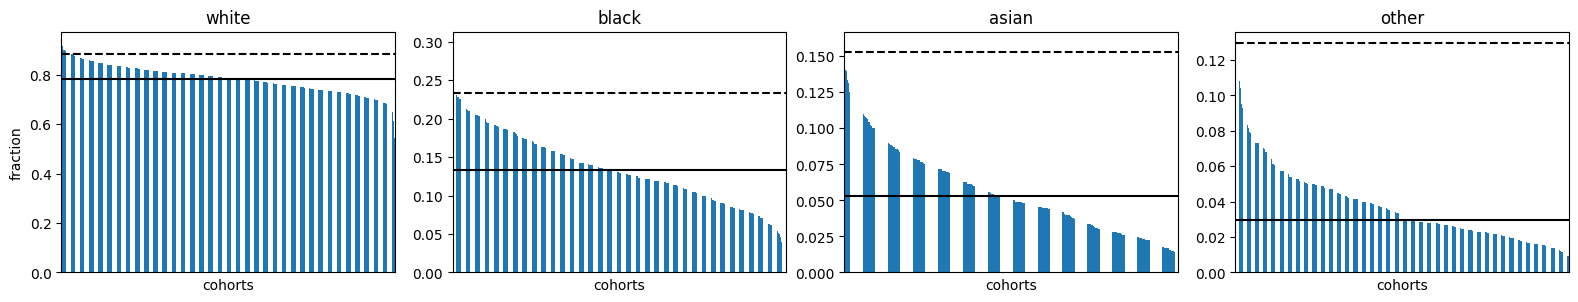

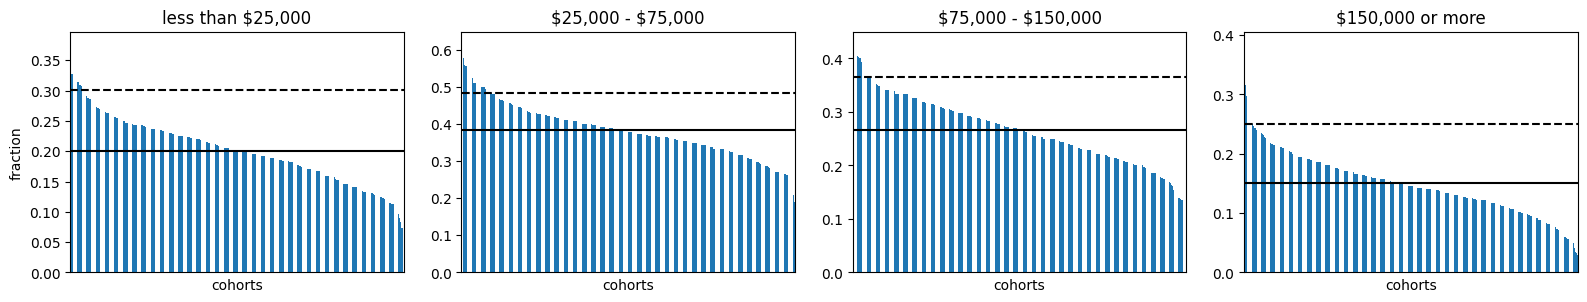


-----------
k=50

|C| = 249 total cohorts
k = 50
|C| / k = 4.980
cohort sizes:
count    249.000000
mean      85.401606
std       24.150222
min       50.000000
25%       68.000000
50%       81.000000
75%      100.000000
max      155.000000
Name: cohort_k50, dtype: float64


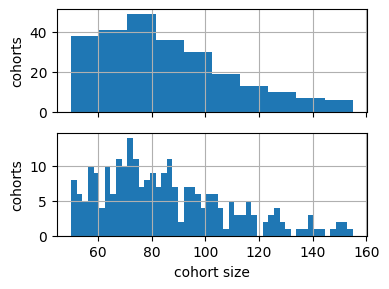

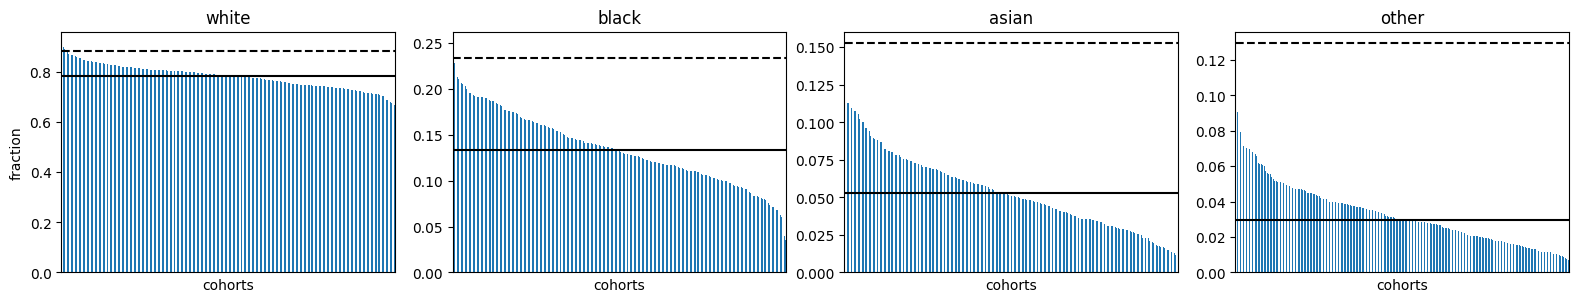

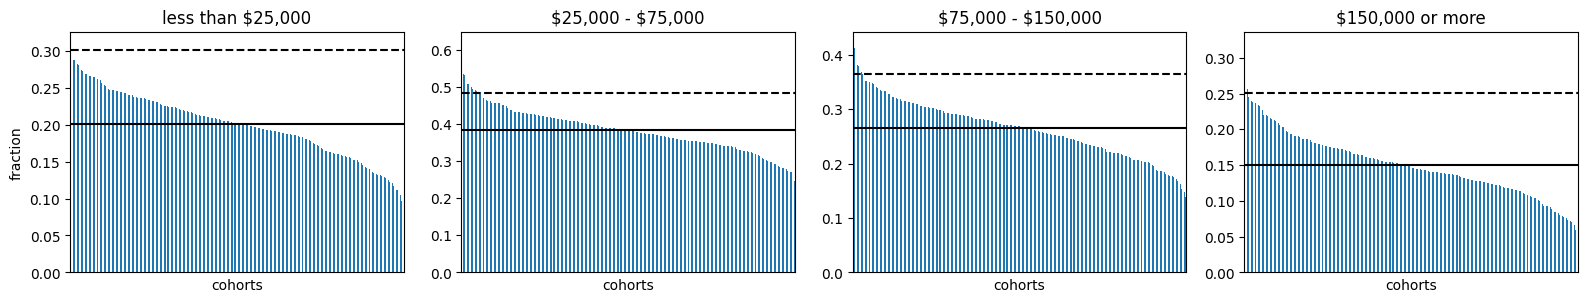


-----------
k=100

|C| = 138 total cohorts
k = 100
|C| / k = 1.380
cohort sizes:
count    138.000000
mean     154.094203
std       33.590251
min      101.000000
25%      127.000000
50%      148.000000
75%      180.000000
max      249.000000
Name: cohort_k100, dtype: float64


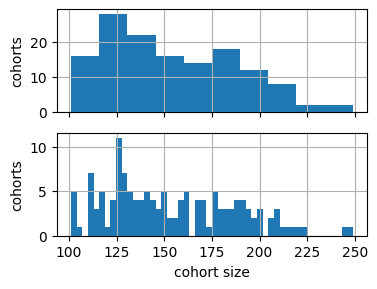

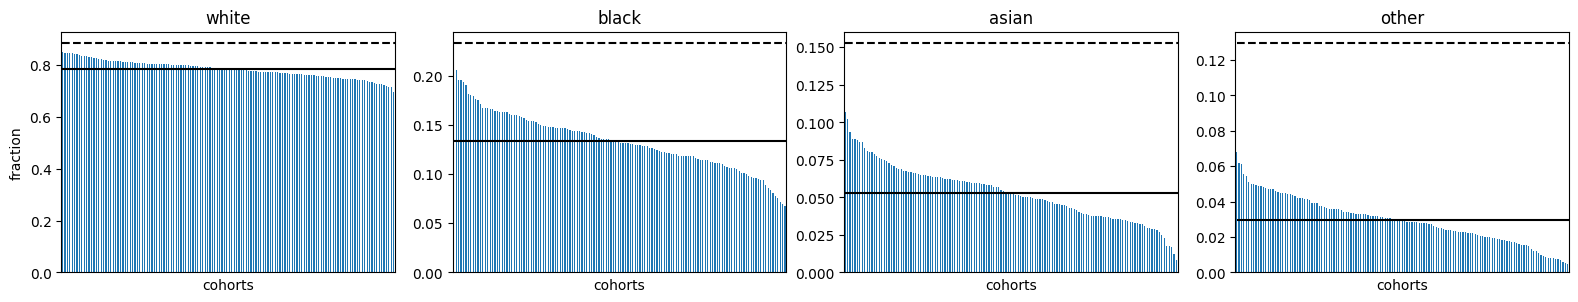

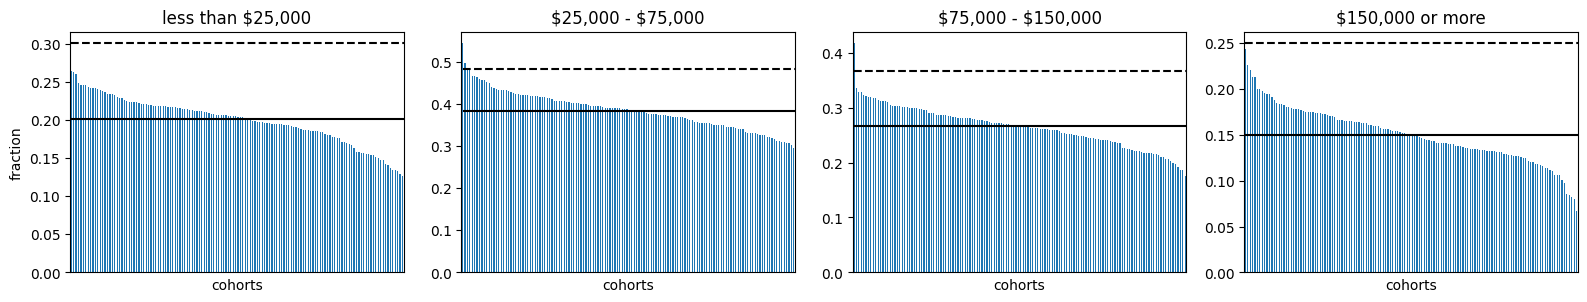


-----------
k=1000

|C| = 12 total cohorts
k = 1000
|C| / k = 0.012
cohort sizes:
count      12.000000
mean     1772.083333
std       481.244874
min      1143.000000
25%      1222.250000
50%      1888.500000
75%      2115.000000
max      2503.000000
Name: cohort_k1000, dtype: float64


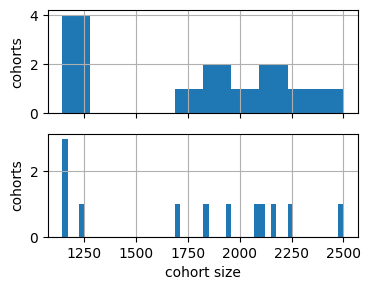

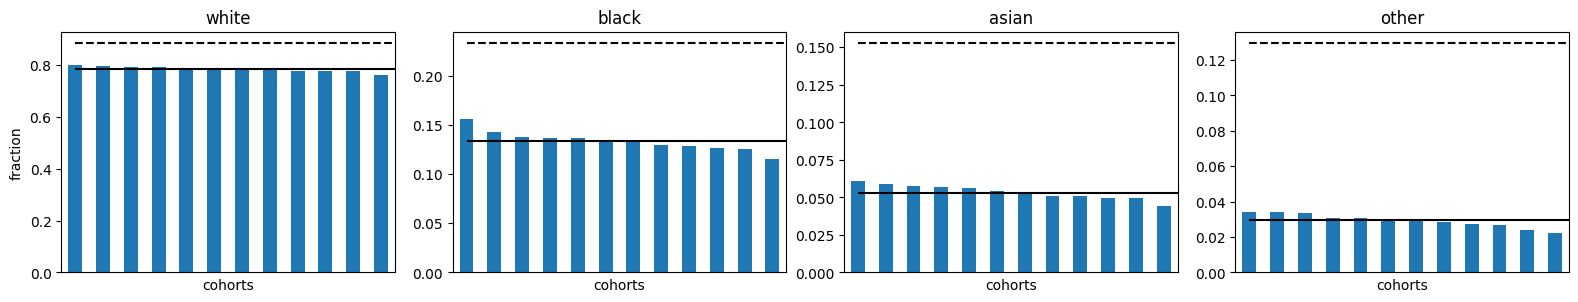

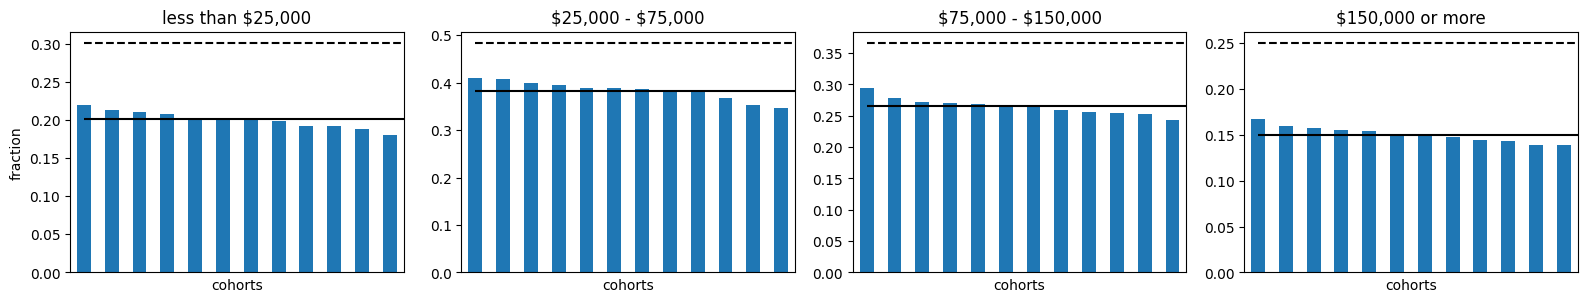


-----------
k=2000

|C| = 8 total cohorts
k = 2000
|C| / k = 0.004
cohort sizes:
count       8.000000
mean     2658.125000
std       495.149166
min      2076.000000
25%      2197.750000
50%      2684.500000
75%      3047.000000
max      3309.000000
Name: cohort_k2000, dtype: float64


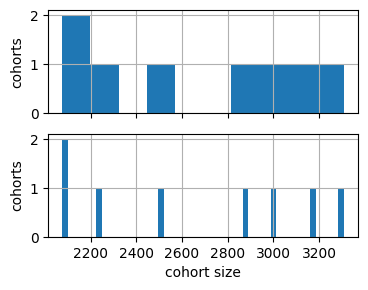

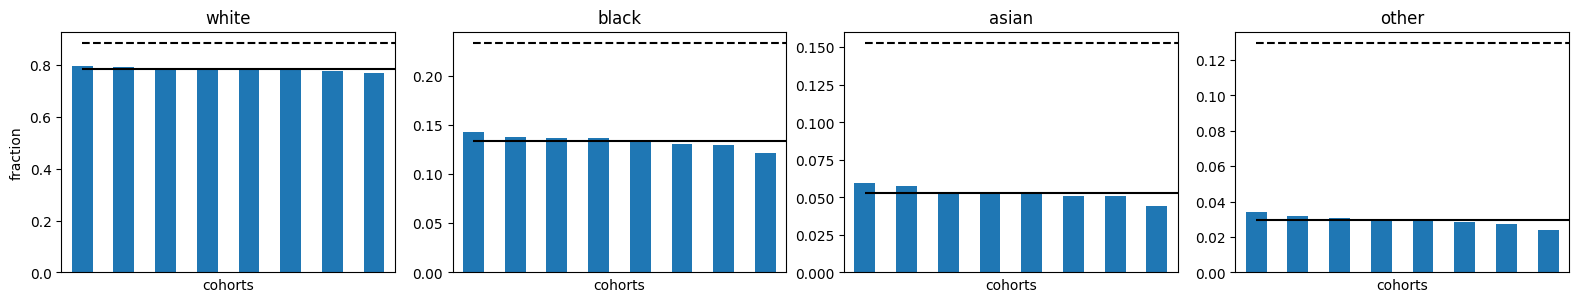

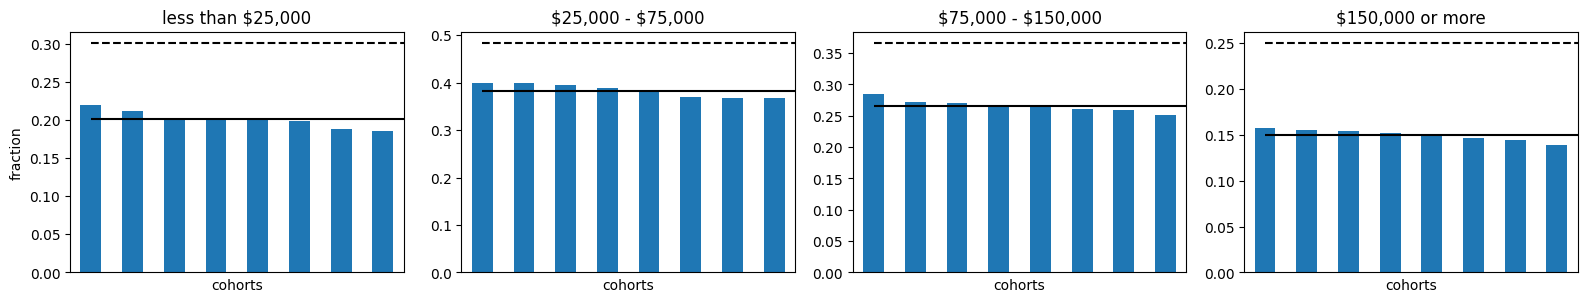

In [79]:
# sanity check we did this right.
# choose some random panel id
panel_id = random.choice(panel_ids)
print('inspecting panel id = %s' % panel_id)
panel_df = all_panels_randomly_shuffled_simhash_cohorts_df[
    (all_panels_randomly_shuffled_simhash_cohorts_df.panel_id==panel_id)
]
for k in k_values:
    print('\n-----------\nk=%s\n' % k)
    cohort_name = 'cohort_k%s'%k
    show_panel_info(panel_df, k=k, cohort_name=cohort_name)

### Panel size comparison

panel_size  avg_cohort_size  \
panel_id                                
260            18286        49.961749   
468            18286        51.655367   
416            18286        50.794444   
364            18286        50.513812   
312            18286        51.221289   

          avg_randomly_shuffled_simhash_cohort_size  
panel_id                                             
260                                       50.374656  
468                                       50.513812  
416                                       52.245714  
364                                       49.555556  
312                                       49.961749

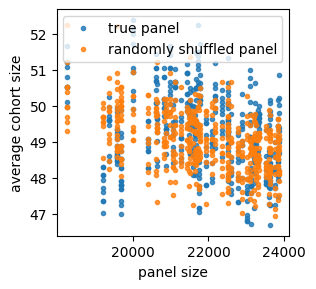

In [82]:
other_avg_cohort_size_name = 'avg_randomly_shuffled_simhash_cohort_size'

panel_sizes = compare_panel_cohort_sizes(
    all_panels_cohort_df,
    all_panels_randomly_shuffled_simhash_cohorts_df, 
    other_avg_cohort_size_name)

# plot the compared panel cohort sizes

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=100)
panel_sizes_sorted = panel_sizes.sort_values('panel_size')
ax.plot(
    panel_sizes_sorted['panel_size'],
    panel_sizes_sorted['avg_cohort_size'], '.', 
    alpha=0.8,
    label='true panel'
)
ax.plot(
    panel_sizes_sorted['panel_size'],
    panel_sizes_sorted[other_avg_cohort_size_name], '.',
    alpha=0.8,
    label='randomly shuffled panel'
)
ax.set_ylabel('average cohort size')
ax.set_xlabel('panel size')
_ = ax.legend()

panel_sizes_sorted.head()

That looks better! We use the randomly shuffled simhash cohorts data as the comparison to the true data.